# AP-1 Figures

In [1487]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"

### imports ###
import sys
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy
import pickle
from sklearn import preprocessing
import sklearn
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import svm, datasets
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn import ensemble
from sklearn import neighbors
import matplotlib_venn
from sklearn.cross_validation import train_test_split
from random import shuffle
from collections import Counter
import time
import ete3
from scipy import ndimage
### notebook specific configuration ###
%matplotlib inline
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(5000)
os.chdir('/gpfs/data01/glasslab/home/jtao/analysis/cobinding_auto_motif_analysis/')
sns.set_context('notebook')
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Functions

In [1488]:
def quantile_normalize(vals1, vals2):
    '''
    input: two scalar arrays
    output: two quantile normalized scalar arrays
    '''
    vals1 = np.array(vals1)
    vals2 = np.array(vals2)
    
    ranks_1 = scipy.stats.rankdata(vals1, method = 'ordinal')
    ranks_2 = scipy.stats.rankdata(vals2, method = 'ordinal')
    
    sorted_vals_1 = sorted(vals1)
    sorted_vals_2 = sorted(vals2)
    means = np.mean([sorted_vals_1,sorted_vals_2], axis=0)
    
    rank_mean_dict = dict(zip(sorted(ranks_1), sorted(means)))
    normalized_vals_1 = np.array([rank_mean_dict[x] for x in ranks_1])
    normalized_vals_2 = np.array([rank_mean_dict[x] for x in ranks_2])
    return normalized_vals_1, normalized_vals_2

In [1489]:
# split data into GC content matched training and test data
def get_split(features, labels, test_size):
    '''
    feature: 2D array (samples x features)
    labels: 1D boolean array (samples x)
    test_size: fraction of data to test on
    '''
    
    ### match GC content of samples labelled True with those labelled False by thowing out False samples
    # retrieve sequences using index of labels
    index_label_tuples = tuple(zip(labels.index.values, labels.values))
    
    true_ids = [x[0] for x in index_label_tuples if x[1]]
    
    false_ids = [x[0] for x in index_label_tuples if not x[1]]
       
    filtered_ids = true_ids + false_ids
    filtered_features = features[features.index.isin(filtered_ids)]
    filtered_labels = labels[labels.index.isin(filtered_ids)]

    if test_size <= 0.5:
        training_indices, test_indices = next(iter(
                sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/test_size), shuffle=True)))
    else:
        test_indices, training_indices = next(
            iter(sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/(1-test_size)), shuffle=True)))
    training_ids = [filtered_ids[i] for i in training_indices]
    test_ids = [filtered_ids[i] for i in test_indices]
    
    training_features = filtered_features[filtered_features.index.isin(training_ids)]
    test_features = filtered_features[filtered_features.index.isin(test_ids)]
    training_labels = filtered_labels[filtered_labels.index.isin(training_ids)]
    test_labels = filtered_labels[filtered_labels.index.isin(test_ids)]
    
    return training_features, test_features, training_labels, test_labels
    

In [1490]:
def train_classifier(affinity_features,
                     labels,
                     numIterations=5,
                     test_size=0.5):
    all_affinity_rocs = []
    all_affinity_precisions = []
    all_affinity_coefficients = []
    all_affinity_scores = []
    all_testLabels = []

    for i in range(numIterations):  

        # split data into training and test sets
        training_affinity_features, test_affinity_features, training_labels, test_labels = get_split(
            affinity_features, labels, test_size = test_size)

        #  Train affinity classifier
        affinity_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
        affinity_classifier.fit(training_affinity_features, training_labels)

        # score predictions
        affinity_probas = affinity_classifier.predict_proba(test_affinity_features)
        current_affinity_roc = sklearn.metrics.roc_auc_score(test_labels, 
                                                              affinity_probas[:, 1], 
                                                              average = None)
        current_affinity_precision = sklearn.metrics.average_precision_score(test_labels, 
                                                                             affinity_probas[:, 1], 
                                                                             average = None)

         # retrieve coefficients
        current_affinity_coefficients = affinity_classifier.coef_.flatten()
        
        all_affinity_rocs.append(current_affinity_roc)
        all_affinity_precisions.append(current_affinity_precision)
        all_affinity_coefficients.append(current_affinity_coefficients)
        all_affinity_scores.append(affinity_probas)
        all_testLabels.append(test_labels)
        
    results = (all_affinity_rocs, 
               all_affinity_precisions, 
               all_affinity_coefficients,
               all_affinity_scores,
               all_testLabels)
    return results
    

In [1491]:
def calculate_mean_weights(affinity_weights_dict, 
                           sorted_motif_names):
    '''
    '''
    
    factor_coeff_affinity_dict = {}

    # calculates the mean of each of the weights
    for factor_treatment in affinity_weights_dict.keys():
        current_affinity_weights = affinity_weights_dict[factor_treatment]
        mean_affinity_weights = np.mean(current_affinity_weights, axis=0)
        
        factor_coeff_affinity_dict[factor_treatment] = mean_affinity_weights
    coeff_affinity_frame = pd.DataFrame(factor_coeff_affinity_dict)
    coeff_affinity_frame.index = sorted_motif_names
        
    return coeff_affinity_frame

In [1492]:
def calculate_zscore_weights(affinity_weights_dict, 
                             sorted_motif_names):
    '''
        '''
    
    factor_zscore_coeff_affinity_dict = {}


    # calculates the mean of each of the weights
    for factor_treatment in affinity_weights_dict.keys():
        current_affinity_weights = affinity_weights_dict[factor_treatment]
        mean_affinity_weights = np.mean(current_affinity_weights, axis=0)
        
        # zscore normalize the weights
        zscore_affinity_weights = scipy.stats.zscore(mean_affinity_weights)
        
        factor_zscore_coeff_affinity_dict[factor_treatment] = zscore_affinity_weights

    
    zscore_coeff_affinity_frame = pd.DataFrame(factor_zscore_coeff_affinity_dict)

    zscore_coeff_affinity_frame.index = sorted_motif_names
        
    return zscore_coeff_affinity_frame

## Copy Score Files

In [1494]:
%%bash 
cp /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis_features/peak_sequences/C57BL6J.fa ./
cp /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis_features/group_summary.tsv ./

In [ ]:
%%bash
# random background files
cp /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis_background_features/background_group_summary.tsv ./
# cp /gpfs/data01/glasslab/home/jtao/analysis/random_background_analysis/motif_count_background_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis_background_features/motif_score_background_frame_C57BL6J.pickle ./  
cp /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis_background_features/motif_start_background_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis_background_features/motif_end_background_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis_background_features/motif_sequence_background_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis_background_features/motif_strand_background_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis_background_features/C57BL6J_background.fa ./

## Read in Score Files

In [ ]:
summary_frame = pd.read_csv('./group_summary.tsv' , sep='\t')
summary_frame = summary_frame.fillna('0')
for col in summary_frame.columns[5:]:
    floatValues = []
    for val in summary_frame[col].values.astype(str):
        if ',' in val:
            maxVal = np.mean([float(x) for x in val.split(',')])
            floatValues.append(maxVal)
        else:
            floatValues.append(float(val))
    summary_frame[col] = floatValues
summary_frame.index = summary_frame['ID'].values

# remove peaks in unknown/random chromosomes
summary_frame = summary_frame[~summary_frame['chr'].str.contains('random')]
summary_frame = summary_frame[~summary_frame['chr'].str.contains('Un')]

In [ ]:
summary_background_frame = pd.read_csv('./background_group_summary.tsv' , sep='\t')
summary_background_frame = summary_background_frame.fillna('0')
for col in summary_background_frame.columns[5:]:
    floatValues = []
    for val in summary_background_frame[col].values.astype(str):
        if ',' in val:
            maxVal = np.mean([float(x) for x in val.split(',')])
            floatValues.append(maxVal)
        else:
            floatValues.append(float(val))
    summary_background_frame[col] = floatValues
summary_background_frame.index = summary_background_frame['ID'].values

# remove peaks in unknown/random chromosomes
summary_background_frame = summary_background_frame[~summary_background_frame['chr'].str.contains('random')]
summary_background_frame = summary_background_frame[~summary_background_frame['chr'].str.contains('Un')]

In [ ]:
motif_score_frame = pd.read_pickle('motif_score_frame_C57BL6J.pickle')
motif_sequence_frame = pd.read_pickle('motif_sequence_frame_C57BL6J.pickle')
motif_strand_frame = pd.read_pickle('motif_strand_frame_C57BL6J.pickle')
motif_start_frame = pd.read_pickle('motif_start_frame_C57BL6J.pickle')
motif_end_frame = pd.read_pickle('motif_end_frame_C57BL6J.pickle')
# motif_count_frame = pd.read_pickle('motif_count_frame_C57BL6J.pickle')

_factors = sorted(list(set([x.split('_')[1] for x in summary_frame.columns if '_' in x])))
_factors.remove('atac')
   

In [ ]:
motif_score_balbc_frame = pd.read_pickle('motif_score_frame_BALBCJ.pickle')
motif_sequence_balbc_frame = pd.read_pickle('motif_sequence_frame_BALBCJ.pickle')
motif_strand_balbc_frame = pd.read_pickle('motif_strand_frame_BALBCJ.pickle')
motif_start_balbc_frame = pd.read_pickle('motif_start_frame_BALBCJ.pickle')
motif_end_balbc_frame = pd.read_pickle('motif_end_frame_BALBCJ.pickle')
# motif_count_balbc_frame = pd.read_pickle('motif_count_frame_BALBCJ.pickle')

In [ ]:
motif_score_background_frame = pd.read_pickle('motif_score_background_frame_C57BL6J.pickle')
motif_sequence_background_frame = pd.read_pickle('motif_sequence_background_frame_C57BL6J.pickle')
motif_strand_background_frame = pd.read_pickle('motif_strand_background_frame_C57BL6J.pickle')
motif_start_background_frame = pd.read_pickle('motif_start_background_frame_C57BL6J.pickle')
motif_end_background_frame = pd.read_pickle('motif_end_background_frame_C57BL6J.pickle')
# motif_count_background_frame = pd.read_pickle('motif_count_background_frame_C57BL6J.pickle')

# make sure background frames don't have IDs that overlap with target frame
motif_score_background_frame = motif_score_background_frame[~motif_score_background_frame.index.isin(motif_score_frame.index.values)]
motif_sequence_background_frame = motif_sequence_background_frame[~motif_sequence_background_frame.index.isin(motif_score_frame.index.values)]
motif_strand_background_frame = motif_strand_background_frame[~motif_strand_background_frame.index.isin(motif_score_frame.index.values)]
motif_start_background_frame = motif_start_background_frame[~motif_start_background_frame.index.isin(motif_score_frame.index.values)]
motif_end_background_frame = motif_end_background_frame[~motif_end_background_frame.index.isin(motif_score_frame.index.values)]
# motif_count_background_frame = motif_count_background_frame[~motif_count_background_frame.index.isin(motif_score_frame.index.values)]


In [ ]:
# rearrange columns
columns = list(motif_score_frame.columns.values)
columns.remove('ID')
columns.remove('chr')
columns.remove('Factors')
motifs = columns
sorted_columns = ['ID', 'chr' , 'Factors'] + sorted(motifs)

motif_score_frame = motif_score_frame[sorted_columns]
motif_sequence_frame = motif_sequence_frame[sorted_columns]
motif_strand_frame = motif_strand_frame[sorted_columns]
motif_start_frame = motif_start_frame[sorted_columns]
motif_end_frame = motif_end_frame[sorted_columns]
# motif_count_frame = motif_count_frame[sorted_columns]

motif_score_background_frame = motif_score_background_frame[sorted_columns]
motif_sequence_background_frame = motif_sequence_background_frame[sorted_columns]
motif_strand_background_frame = motif_strand_background_frame[sorted_columns]
motif_start_background_frame = motif_start_background_frame[sorted_columns]
motif_end_background_frame = motif_end_background_frame[sorted_columns]
# motif_count_background_frame = motif_count_background_frame[sorted_columns]

motif_score_balbc_frame = motif_score_balbc_frame[sorted_columns]
motif_sequence_balbc_frame = motif_sequence_balbc_frame[sorted_columns]
motif_strand_balbc_frame = motif_strand_balbc_frame[sorted_columns]
motif_start_balbc_frame = motif_start_balbc_frame[sorted_columns]
motif_end_balbc_frame = motif_end_balbc_frame[sorted_columns]
# motif_count_balbc_frame = motif_count_balbc_frame[sorted_columns]

In [ ]:
# concatent target and background frames
# scores
all_score_frame = pd.concat([motif_score_frame, motif_score_background_frame])
all_score_frame = all_score_frame[motif_score_frame.columns.values]
all_score_frame = all_score_frame[sorted_columns]

# # counts
# all_count_frame = pd.concat([motif_count_frame, motif_count_background_frame])
# all_count_frame = all_count_frame[motif_count_frame.columns.values]
# all_count_frame = all_count_frame.ix[:,3:]
# all_count_frame = all_count_frame[sorted(all_count_frame.columns.values)]

scaler = preprocessing.StandardScaler()
all_standardized_score_frame = pd.DataFrame(scaler.fit_transform(all_score_frame.ix[:,3:]))
all_standardized_score_frame.columns = all_score_frame.columns.values[3:]
all_standardized_score_frame.index = all_score_frame.index.values
all_standardized_score_frame = all_standardized_score_frame[sorted(all_standardized_score_frame.columns.values)]

scaler = preprocessing.RobustScaler()
all_robustScaled_score_frame = pd.DataFrame(scaler.fit_transform(all_score_frame.ix[:,3:]))
all_robustScaled_score_frame.columns = all_score_frame.columns.values[3:]
all_robustScaled_score_frame.index = all_score_frame.index.values
all_robustScaled_score_frame = all_robustScaled_score_frame[sorted(all_robustScaled_score_frame.columns.values)]

scaler = preprocessing.MinMaxScaler()
all_normed_score_frame = pd.DataFrame(scaler.fit_transform(all_score_frame.ix[:,3:]))
all_normed_score_frame.columns = all_score_frame.columns.values[3:]
all_normed_score_frame.index = all_score_frame.index.values
all_normed_score_frame = all_normed_score_frame[sorted(all_normed_score_frame.columns.values)]

# scaler = preprocessing.StandardScaler()
# all_standardized_count_frame = pd.DataFrame(scaler.fit_transform(all_count_frame))
# all_standardized_count_frame.columns = all_count_frame.columns.values
# all_standardized_count_frame.index = all_count_frame.index.values
# all_standardized_count_frame = all_standardized_count_frame[sorted(all_standardized_count_frame.columns.values)]

# scaler = preprocessing.MinMaxScaler()
# all_normed_count_frame = pd.DataFrame(scaler.fit_transform(all_count_frame))
# all_normed_count_frame.columns = all_count_frame.columns.values
# all_normed_count_frame.index = all_count_frame.index.values
# all_normed_count_frame = all_normed_count_frame[sorted(all_normed_count_frame.columns.values)]

In [ ]:
all_score_balbc_frame = pd.concat([motif_score_balbc_frame, motif_score_background_frame])
all_score_balbc_frame = all_score_balbc_frame[motif_score_balbc_frame.columns.values]
all_score_balbc_frame = all_score_balbc_frame[sorted_columns]

scaler = preprocessing.StandardScaler()
all_standardized_score_balbc_frame = pd.DataFrame(scaler.fit_transform(all_score_balbc_frame.ix[:,3:]))
all_standardized_score_balbc_frame.columns = all_score_balbc_frame.columns.values[3:]
all_standardized_score_balbc_frame.index = all_score_balbc_frame.index.values
all_standardized_score_balbc_frame = all_standardized_score_balbc_frame[sorted(all_standardized_score_balbc_frame.columns.values)]

In [ ]:
# Read in peak sequence
### read in target sequences as dictionary {peakID: sequence}
with open('./C57BL6J.fa') as f:
    data = f.readlines()

_id_sequence_dict = {}
for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        _id_sequence_dict[sequenceName] = line.strip().upper()  
### read in background sequences
with open('./C57BL6J_background.fa') as f:
    data = f.readlines()

for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        _id_sequence_dict[sequenceName] = line.strip().upper()  

In [ ]:
ap1_members=['atf3', 'cjun', 'fos','fra2', 'junb', 'jund']
contains_ap1 = summary_frame[['c57bl6_'+x+'_veh' for x in ap1_members]].sum(axis=1)>0
contains_ap1_tuples = tuple(zip(contains_ap1.index.values, contains_ap1.values, summary_frame['Factors'].values))
summary_frame['Factors'] = [x[2] + ',c57bl6_ap-1_veh' if x[1] == True else x[2] for x in contains_ap1_tuples]

contains_ap1 = summary_frame[['c57bl6_'+x+'_kla' for x in ap1_members]].sum(axis=1)>0
contains_ap1_tuples = tuple(zip(contains_ap1.index.values, contains_ap1.values, summary_frame['Factors'].values))
summary_frame['Factors'] = [x[2] + ',c57bl6_ap-1_kla' if x[1] == True else x[2] for x in contains_ap1_tuples]

# Figure 1

### Expression of AP-1 monomers before and after KLA treatment

In [ ]:
%%bash
analyzeRepeats.pl rna mm10 -count exons -condenseGenes -rpkm -d  ~/analysis/ap1_analysis/tag_directories_rna/*Veh*UT*CR*/ ~/analysis/ap1_analysis/tag_directories_rna/*Veh*UT*VML*/ ~/analysis/ap1_analysis/tag_directories_rna/*KLA-1h*UT*/> rpkm_untreated.tsv

# python ~/code/seq_merge_pipe/run_idr_homerRNA.py rpkm_untreated.tsv ./rna_idr_untreated KLA KLA Veh Veh

In [ ]:
# read in rpkm values
rpkm_frame = pd.read_csv('./rpkm_untreated.tsv', sep='\t')

rpkm_frame.index = [x.split('|')[0].upper() for x in rpkm_frame['Annotation/Divergence']]
rpkm_frame = rpkm_frame.ix[:,8:]
rpkm_frame.columns = [x.split('/')[-2].split('_')[3] for x in rpkm_frame.columns.values]

# rotate frame for plotting
rpkm_plotting_frame = pd.DataFrame(rpkm_frame.stack(), 
                                   columns=['RPKM'])
rpkm_plotting_frame['Gene'] = [x[0] for x in rpkm_plotting_frame.index.values]
rpkm_plotting_frame['Treatment'] = [x[1] for x in rpkm_plotting_frame.index.values]
rpkm_plotting_frame['Log2 RPKM'] = np.log2(rpkm_plotting_frame['RPKM'].values + 1)

In [ ]:
# from AP-1 as a regulator of cell life and death
# Jun (c-Jun, JunB, JunD), 
# Fos (c-Fos, FosB, Fra-1 and Fra2), 
# Maf (c-Maf, MafB, MafA, MafG/F/K and Nrl) and 
# ATF (ATF2, LRF1/ATF3, B-ATF, JDP1, JDP2) 
# BATF3 and JDP1 are the same thing
gene_list = ['JUN' , 'JUNB', 'JUND',
             'FOS', 'FOSL1', 'FOSL2', 'FOSB',
#              'MAF', 'MAFA','MAFB','MAFG', 'MAFF', 'MAFK', 'NRL',
             'ATF2', 'ATF3','BATF','JDP2','BATF3'#'JDP1'
             ]

plotting_frame = rpkm_plotting_frame[rpkm_plotting_frame['Gene'].isin(gene_list)]
gene_list_tuples = []
for gene in set(plotting_frame['Gene'].values):
    vals = plotting_frame[plotting_frame['Gene']==gene]['Log2 RPKM'].values
    gene_list_tuples.append((gene, np.max(vals)))
gene_list_tuples.sort(key=lambda x:x[1])
ordered_genes = [x[0] for x in gene_list_tuples]
with sns.axes_style('ticks'):
    sns.factorplot(data = plotting_frame, 
                   x='Log2 RPKM', 
                   y='Gene', 
                   hue='Treatment', 
                   kind='bar', 
                   order = ordered_genes,
                   hue_order=['Veh','KLA-1h'], 
                   ci=100,
                  size=4)
#     plt.xlabel('AP-1 Monomer')
    plt.ylabel('')

plt.xticks(rotation=90)
plt.savefig('./figures/figure_01_ap1_expression.svg', bbox_inches='tight')

In [ ]:
# from AP-1 as a regulator of cell life and death
# Jun (c-Jun, JunB, JunD), 
# Fos (c-Fos, FosB, Fra-1 and Fra2), 
# Maf (c-Maf, MafB, MafA, MafG/F/K and Nrl) and 
# ATF (ATF2, LRF1/ATF3, B-ATF, JDP1, JDP2) 
# BATF3 and JDP1 are the same thing
gene_list = ['JUN' , 'JUNB', 'JUND',
             'FOS', 'FOSL1', 'FOSL2', 'FOSB',
#              'MAF', 'MAFA','MAFB','MAFG', 'MAFF', 'MAFK', 'NRL',
             'ATF2', 'ATF3','BATF','JDP2','BATF3'#'JDP1'
             ]
gene_list = ['ATF3', 'FOS', 'FOSL2',
             'JUN' , 'JUNB', 'JUND']
plotting_frame = rpkm_plotting_frame[rpkm_plotting_frame['Gene'].isin(gene_list)]
gene_list_tuples = []
for gene in set(plotting_frame['Gene'].values):
    vals = plotting_frame[plotting_frame['Gene']==gene]['Log2 RPKM'].values
    gene_list_tuples.append((gene, np.max(vals)))
gene_list_tuples.sort(key=lambda x:x[1])
ordered_genes = [x[0] for x in gene_list_tuples]
with sns.axes_style('ticks'):
    sns.factorplot(data = plotting_frame, 
                   x='RPKM', 
                   y='Gene', 
                   hue='Treatment', 
                   kind='bar', 
                   order = gene_list,
                   hue_order=['Veh','KLA-1h'], 
                   ci=100,
                  size=4)
#     plt.xlabel('AP-1 Monomer')
    plt.ylabel('')

plt.xticks(rotation=90)
plt.savefig('./figures/figure_01_monomer_expression.svg', bbox_inches='tight')

In [ ]:
# from AP-1 as a regulator of cell life and death
# Jun (c-Jun, JunB, JunD), 
# Fos (c-Fos, FosB, Fra-1 and Fra2), 
# Maf (c-Maf, MafB, MafA, MafG/F/K and Nrl) and 
# ATF (ATF2, LRF1/ATF3, B-ATF, JDP1, JDP2) 
# BATF3 and JDP1 are the same thing
gene_list = ['JUN' , 'JUNB', 'JUND',
             'FOS', 'FOSL1', 'FOSL2', 'FOSB',
#              'MAF', 'MAFA','MAFB','MAFG', 'MAFF', 'MAFK', 'NRL',
             'ATF2', 'ATF3','BATF','JDP2','BATF3'#'JDP1'
             ]
gene_list = ['ATF3', 'FOS', 'FOSL2',
             'JUN' , 'JUNB', 'JUND']
plotting_frame = rpkm_plotting_frame[rpkm_plotting_frame['Gene'].isin(gene_list)]
gene_list_tuples = []
for gene in set(plotting_frame['Gene'].values):
    vals = plotting_frame[plotting_frame['Gene']==gene]['Log2 RPKM'].values
    gene_list_tuples.append((gene, np.max(vals)))
gene_list_tuples.sort(key=lambda x:x[1])
ordered_genes = [x[0] for x in gene_list_tuples]
with sns.axes_style('ticks'):
    sns.factorplot(data = plotting_frame, 
                   x='RPKM', 
                   y='Gene', 
                   hue='Treatment', 
                   kind='bar', 
                   order = gene_list,
                   hue_order=['Veh','KLA-1h'], 
                   ci=100,
                  size=4)
#     plt.xlabel('AP-1 Monomer')
    plt.ylabel('')

plt.xticks(rotation=90)
plt.savefig('./figures/figure_01_monomer_expression.svg', bbox_inches='tight')

### Heatmap of Cistrome

In [ ]:
%% capture
### create tag matrix
!annotatePeaks.pl ./merged_peaks_filtered_resized.tsv mm10 -size given -d ./tag_directories_ap1/*/ ./tag_directories_strains/*/> merged_annotated_peaks_ap1.tsv

In [ ]:
# average tag counts from both replicates
ap1_tag_frame = pd.read_csv('merged_annotated_peaks_ap1.tsv', sep='\t')
ap1_tag_frame.index = ap1_tag_frame.ix[:,0].values
ap1_tag_frame = ap1_tag_frame[[x for x in ap1_tag_frame.columns.values if 'Tag Count' in x]]
columns = [x.split(' ')[0].split('/')[2].lower() for x in ap1_tag_frame.columns.values]
ap1_tag_frame.columns = columns

factor_treatments = sorted(set(['_'.join(x.split('_')[:5]) for x in columns]))

ap1_meanTag_dict = {}
for ft in factor_treatments:
    cleaned_ft = ft.replace('thiomac_chip_','').replace('-1h','')
    ap1_meanTag_dict[cleaned_ft] = ap1_tag_frame[[x for x in ap1_tag_frame.columns if ft in x]].mean(axis=1).values
ap1_meanTag_frame = pd.DataFrame(ap1_meanTag_dict)
ap1_meanTag_frame.index = ap1_tag_frame.index.values

### Heatmap for both Vehicle and KLA

In [ ]:
strain = 'c57bl6'
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6_ap-1')].index.values
ap1_normedTag_frame = ap1_meanTag_frame[ap1_meanTag_frame.index.isin(c57bl6_indices)][[]]
for factor in ['atf3','cjun', 'fos', 'fra2', 'junb', 'jund']:
    for treatment in ['veh','kla']:
        ft = strain + '_' + factor + '_' + treatment
        ap1_normedTag_frame[ft] = (ap1_meanTag_frame[ft] + 1)/(ap1_meanTag_frame[strain + '_input_'+treatment]+1)

logged_data = np.log2(ap1_normedTag_frame+1)

cg = sns.clustermap(logged_data,
                    yticklabels=False,
                    xticklabels=logged_data.columns,
                    cmap='Greens',
                    col_cluster=False,
                    row_cluster = True,
                    vmax=6)
plt.savefig('./figures/figure_01_tag_count_heatmap.png', bbox_inches='tight')

### Barplot summarizing overlap of peaks before and after KLA

In [ ]:
# ap1_members = ['atf3', 'cjun', 'fos', 'fra1', 'fra2','jdp2', 'junb', 'jund']
ap1_members = ['atf3', 'cjun', 'fos', 'fra2', 'junb', 'jund']
factor_list = []
count_list = []
type_list = []

veh_columns = ['c57bl6_' + x + '_veh' for x in ap1_members]
kla_columns = ['c57bl6_' + x + '_kla' for x in ap1_members]

for i in range(len(ap1_members)):
    factor = ap1_members[i]
    
        
    veh_indices = set(summary_frame[summary_frame['c57bl6_' + factor + '_veh'] > 0].index.values)
    kla_indices = set(summary_frame[summary_frame['c57bl6_' + factor + '_kla'] > 0].index.values)
        
    veh_count = len(veh_indices.difference(kla_indices))
    both_count = len(veh_indices.intersection(kla_indices))
    kla_count = len(kla_indices.difference(veh_indices))

    factor_list = factor_list + 3*[factor]
    type_list = type_list + ['Veh Specific', 'Shared', 'KLA Specific']
    count_list.append(veh_count)
    count_list.append(both_count)
    count_list.append(kla_count)
    
plotting_frame = pd.DataFrame({'Factor':factor_list,
                              'Type':type_list,
                              'Number of Peaks': count_list})
with sns.axes_style('ticks'):
    sns.factorplot(data=plotting_frame, 
                   x = 'Factor',
                   y = 'Number of Peaks',
                   hue = 'Type',
                   hue_order = ['Veh Specific', 'Shared', 'KLA Specific'],
                   kind = 'bar')

    plt.savefig('./figures/figure_01_peak_counts.svg', bbox_inches='tight')

# Figure 2 

### Browser shots

In [ ]:
summary_frame[(summary_frame['c57bl6_cjun_veh'] == 0) &
              (summary_frame['c57bl6_cjun_kla'] > 0) &
              (summary_frame['c57bl6_p65_kla'] > 0) &
              (summary_frame['c57bl6_p65_veh'] == 0)].sort('c57bl6_cjun_kla', ascending=False)

### De Novo Motif Analysis

In [ ]:
%%bash
### create motif analysis directories
if [ ! -d ./denovo_motif_analysis ]; 
then 
    # make directories for peaks
    mkdir ./denovo_motif_analysis;
    mkdir ./denovo_motif_analysis/veh_peaks;
    mkdir ./denovo_motif_analysis/kla_peaks;
    mkdir ./denovo_motif_analysis/veh_nonoverlapping_peaks;
    mkdir ./denovo_motif_analysis/kla_nonoverlapping_peaks;
    mkdir ./denovo_motif_analysis/veh_monomers_peaks;
    mkdir ./denovo_motif_analysis/kla_monomers_peaks;
    
    # make directories for motif analysis
    mkdir ./denovo_motif_analysis/veh_motif_analysis_overlapping;
    mkdir ./denovo_motif_analysis/kla_motif_analysis_overlapping;
    mkdir ./denovo_motif_analysis/veh_motif_analysis_nonoverlapping;
    mkdir ./denovo_motif_analysis/kla_motif_analysis_nonoverlapping;
    mkdir ./denovo_motif_analysis/veh_motif_analysis_monomers;
    mkdir ./denovo_motif_analysis/kla_motif_analysis_monomers;

else
    rm -rf ./denovo_motif_analysis/*/*
fi


### For overlapping dimer and monomer peaks

In [ ]:
### create peak files for denovo motif
peak_threshold = 1000 # minimum number of peaks required for running motif analysis
factors = ['atf3', 'cjun', 'fos', 'fra2', 'junb', 'jund']

for treatment in ['veh', 'kla']:
    for i in range(len(factors)):
        factor1 = 'c57bl6_'+factors[i] + '_' + treatment
        for j in range(i, len(factors)):
            factor2 = 'c57bl6_'+ factors[j] + '_' + treatment

            if factor1 == factor2:
                outputPath = './denovo_motif_analysis/' + treatment + '_monomers_peaks/' + factor1 + '_peaks.tsv'

                current_frame = summary_frame[(summary_frame[factor1] > 0)]
            else:
                outputPath = './denovo_motif_analysis/' + treatment + '_peaks/' + factor1 + '_' + factor2 + '_peaks.tsv'
                current_frame = summary_frame[(summary_frame[factor1]> 0) &
                                             (summary_frame[factor2] > 0)]
            current_peak_frame = current_frame[['ID', 'chr', 'start', 'end']]
            current_peak_frame['strand'] = '+'
            columns = current_peak_frame.columns.values
            columns[0]='#PeakID'        
            current_peak_frame.columns = columns
            if current_peak_frame.shape[0]  > peak_threshold:
                outputPath = outputPath.replace('c57bl6_','')
                current_peak_frame.to_csv(outputPath,
                                         index=False,
                                         sep='\t')

In [ ]:
%%capture
%%bash
for peakFile in ./denovo_motif_analysis/veh_peaks/*_peaks.tsv
do
    peakName=${peakFile%_peaks.tsv}
    peakName=${peakName##*/}
    findMotifsGenome.pl $peakFile mm10 ./denovo_motif_analysis/veh_motif_analysis_overlapping/${peakName} -size 200 -len 8 -p 24 -S 25 &
    
done


In [ ]:
%%capture
%%bash
for peakFile in ./denovo_motif_analysis/kla_peaks/*_peaks.tsv
do
    peakName=${peakFile%_peaks.tsv}
    peakName=${peakName##*/}
    findMotifsGenome.pl $peakFile mm10 ./denovo_motif_analysis/kla_motif_analysis_overlapping/${peakName} -size 200 -len 8 -p 24 -S 25 &
done

In [ ]:
%%capture
%%bash
rm -rf ./denovo_motif_analysis/veh_motif_analysis_monomers/*
for peakFile in ./denovo_motif_analysis/veh_monomers_peaks/*_peaks.tsv
do
    peakName=${peakFile%_peaks.tsv}
    peakName=${peakName##*/}
    findMotifsGenome.pl $peakFile mm10 ./denovo_motif_analysis/veh_motif_analysis_monomers/${peakName} -size 200 -len 8 -p 24 -S 25 &
    
done

In [ ]:
%%capture
%%bash
rm -rf ./denovo_motif_analysis/kla_motif_analysis_monomers/*
for peakFile in ./denovo_motif_analysis/kla_monomers_peaks/*_peaks.tsv
do
    peakName=${peakFile%_peaks.tsv}
    peakName=${peakName##*/}
    findMotifsGenome.pl $peakFile mm10 ./denovo_motif_analysis/kla_motif_analysis_monomers/${peakName} -size 200 -len 24 -p 8 -S 25 &
    
done

### for non overlappinng monomer peaks

In [ ]:
### create peak files for denovo motif analysis 
peak_threshold = 50 # minimum number of peaks required for running motif analysis
strain = 'c57bl6'
factorPairs = []
# ap1_members = ['atf3','cjun', 'fos', 'fra1','fra2', 'jdp2', 'junb','jund']    
ap1_members = ['atf3','cjun', 'fos', 'junb','jund']    

for treatment in ['veh', 'kla']:
    c57bl6_columns = ['c57bl6_' + x + '_' + treatment for x in ap1_members]
    for i in range(len(ap1_members)):
        monomer1 = strain + '_' +ap1_members[i] + '_' + treatment
            
        outputPath = './denovo_motif_analysis/' + treatment + '_nonoverlapping_peaks/' + \
            ap1_members[i].replace('c57bl6_','') + '_peaks.tsv'
            
        current_frame = summary_frame[(summary_frame[[monomer1]].sum(axis=1) == summary_frame[c57bl6_columns].sum(axis=1))
                                     & (summary_frame[monomer1] > 0)]
        if current_frame.shape[0] >= peak_threshold:
            print(ap1_members[i], current_frame.shape)
            current_peak_frame = current_frame[['ID', 'chr', 'start', 'end']]
            current_peak_frame['strand'] = '+'
            columns = current_peak_frame.columns.values
            columns[0]='#PeakID'        
            current_peak_frame.columns = columns
            if current_peak_frame.shape[0]  > peak_threshold:
                current_peak_frame.to_csv(outputPath,
                                         index=False,
                                         sep='\t')

In [ ]:
%%bash
%%capture
for peakFile in ./denovo_motif_analysis/veh_nonoverlapping_peaks/*_peaks.tsv
do
    peakName=${peakFile%_peaks.tsv}
    peakName=${peakName##*/}
    findMotifsGenome.pl $peakFile mm10 ./denovo_motif_analysis/veh_motif_analysis_nonoverlapping/${peakName} -size 200 -len 8 -p 24 -S 25 &
done

for peakFile in ./denovo_motif_analysis/kla_nonoverlapping_peaks/*_peaks.tsv
do
    peakName=${peakFile%_peaks.tsv}
    peakName=${peakName##*/}
    findMotifsGenome.pl $peakFile mm10 ./denovo_motif_analysis/kla_motif_analysis_nonoverlapping/${peakName} -size 200 -len 8 -p 24 -S 25 &
done

### Using other monomers as background

#### create background peaks

In [1391]:
other_background_path = './denovo_motif_analysis/other_monomer_background'
if not os.path.isdir(other_background_path):
    os.mkdir(other_background_path)
else:
    os.system('rm -rf ' + other_background_path + '/*')

In [1410]:
!ls ./denovo_motif_analysis/veh_monomers_peaks/

atf3_veh_peaks.tsv  cjun_veh_peaks.tsv	fra2_veh_peaks.tsv  jund_veh_peaks.tsv


In [ ]:
%%bash
other_background_path='./denovo_motif_analysis/other_monomer_background'
for factor in atf3 cjun jund;
    do
    for background_factor in atf3 cjun jund;
        do
        if [ ! "$factor" == $"$background_factor" ]
        then
        factor_path="./denovo_motif_analysis/veh_monomers_peaks/${factor}_veh_peaks.tsv"
        background_path="./denovo_motif_analysis/veh_nonoverlapping_peaks/${background_factor}_peaks.tsv"
        echo findMotifsGenome.pl $factor_path mm10 ${other_background_path}/${factor}_bg_${background_factor} -bg $background_path -size 200 -p 24 -S 25
        findMotifsGenome.pl $factor_path mm10 ${other_background_path}/${factor}_bg_${background_factor} -bg $background_path -size 200 -p 24 -S 25 &
        fi
    done
done

### Combine Denovo Motifs

In [ ]:
def groupTopMotifs(numMotifs, denovo_result_dir, scanning_results_dir):
    '''
    move denovo motifs to scanning_results_dir
    '''
    if not os.path.isdir(scanning_results_dir):
        os.mkdir(scanning_results_dir)
   
    combinedFile = open(scanning_results_dir + '/combined.motif', 'w')

    # for each denovo motif analysis result for each monomer
    for monomer_result_dir in os.listdir(denovo_result_dir):
        for i in range(1, numMotifs+1):
            # construct path to motifs 1 through numMotifs
            motif_path = denovo_result_dir + '/' + monomer_result_dir + '/homerResults/motif' + str(i) + '.motif'
            # read in motif file
            if os.path.isfile(motif_path):
                with open(motif_path) as f:
                    data = f.readlines()

                # change motif header
                newMotifName = monomer_result_dir + '_' + str(i)
                os.system('cp ' + motif_path + ' ' + scanning_results_dir + '/' + newMotifName + '.motif')
                os.system('cp ' + motif_path.replace('.motif','.logo.png') + ' ' + scanning_results_dir + '/' + newMotifName + '.logo.png')
    combinedFile.close()

In [ ]:
def copyTopMotifLogos(numMotifs, denovo_result_dir, output_dir):
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)
    else:
        for f in os.listdir(output_dir):
            os.remove(output_dir + '/' + f)

    # for each denovo motif analysis result for each monomer
    for monomer_result_dir in os.listdir(denovo_result_dir):
        for i in range(1, numMotifs+1):
            # construct path to motifs 1 through numMotifs
            logo_path = denovo_result_dir + '/' + monomer_result_dir + '/homerResults/motif' + str(i) + '.logo.png'
            motif_path = denovo_result_dir + '/' + monomer_result_dir + '/homerResults/motif' + str(i) + '.motif'

            if os.path.isfile(motif_path):
                with open(motif_path) as f:
                    line = f.readline()
                motif_name = line.split()[0][1:]
                newMotifName = motif_name + '.logo.png'
                
                os.system('cp ' +logo_path + ' '+ output_dir +'/' + newMotifName)


In [ ]:
numMotifs = 25 # number of motifs to include
denovo_result_dir = './denovo_motif_analysis/veh_motif_analysis_nonoverlapping/'
scanning_results_dir = './denovo_motif_analysis/veh_motif_scanning/'
groupTopMotifs(numMotifs, denovo_result_dir, scanning_results_dir)

numMotifs = 25 # number of motifs to include
denovo_result_dir = './denovo_motif_analysis/kla_motif_analysis_nonoverlapping/'
scanning_results_dir = './denovo_motif_analysis/kla_motif_scanning/'
groupTopMotifs(numMotifs, denovo_result_dir, scanning_results_dir)



In [ ]:
numMotifs = 25 # number of motifs to include
denovo_result_dir = './denovo_motif_analysis/veh_motif_analysis_nonoverlapping/'
veh_logo_path = './denovo_motif_analysis/veh_motif_scanning_logos/'
copyTopMotifLogos(numMotifs, denovo_result_dir, veh_logo_path)

numMotifs = 25 # number of motifs to include
denovo_result_dir = './denovo_motif_analysis/kla_motif_analysis_nonoverlapping/'
kla_logo_path = './denovo_motif_analysis/kla_motif_scanning_logos/'
copyTopMotifLogos(numMotifs, denovo_result_dir, kla_logo_path)

### Cluster Motifs

In [1482]:
%%bash
# score motif similarity
python /gpfs/data01/glasslab/home/jtao/code/motif_tools/scoreMotifs.py ./denovo_motif_analysis/veh_scanning_motif_clustering/ ./denovo_motif_analysis/veh_motif_scanning/*motif
python /gpfs/data01/glasslab/home/jtao/code/motif_tools/scoreMotifs.py ./denovo_motif_analysis/kla_scanning_motif_clustering/ ./denovo_motif_analysis/kla_motif_scanning/*motif

# cluster motifs
rm -rf ./denovo_motif_analysis/veh_scanning_motif_clustering/clustered_motifs/
rm -rf ./denovo_motif_analysis/kla_scanning_motif_clustering/clustered_motifs/
python /gpfs/data01/glasslab/home/jtao/code/motif_tools/thresholdClusterMotifs.py ./denovo_motif_analysis/veh_scanning_motif_clustering/correlation.npz ./denovo_motif_analysis/veh_scanning_motif_clustering/ 0.80 ./denovo_motif_analysis/veh_motif_scanning/*motif 
python /gpfs/data01/glasslab/home/jtao/code/motif_tools/thresholdClusterMotifs.py ./denovo_motif_analysis/kla_scanning_motif_clustering/correlation.npz ./denovo_motif_analysis/kla_scanning_motif_clustering/ 0.80 ./denovo_motif_analysis/kla_motif_scanning/*motif 

Reading motif files...
Calculating alignments between motifs and scoring motifs
Creating visualizations...
Serializing scores... 
correlation should be used for clustering.
Reading motif files...
Calculating alignments between motifs and scoring motifs
Creating visualizations...
Serializing scores... 
correlation should be used for clustering.


In [1483]:
veh_correlation_data = np.load('./denovo_motif_analysis/veh_scanning_motif_clustering/correlation.npz')
veh_correlations = veh_correlation_data['arr_0']
veh_motif_names = veh_correlation_data['arr_1']

In [1484]:
kla_correlation_data = np.load('./denovo_motif_analysis/kla_scanning_motif_clustering/correlation.npz')
kla_correlations = kla_correlation_data['arr_0']
kla_motif_names = kla_correlation_data['arr_1']

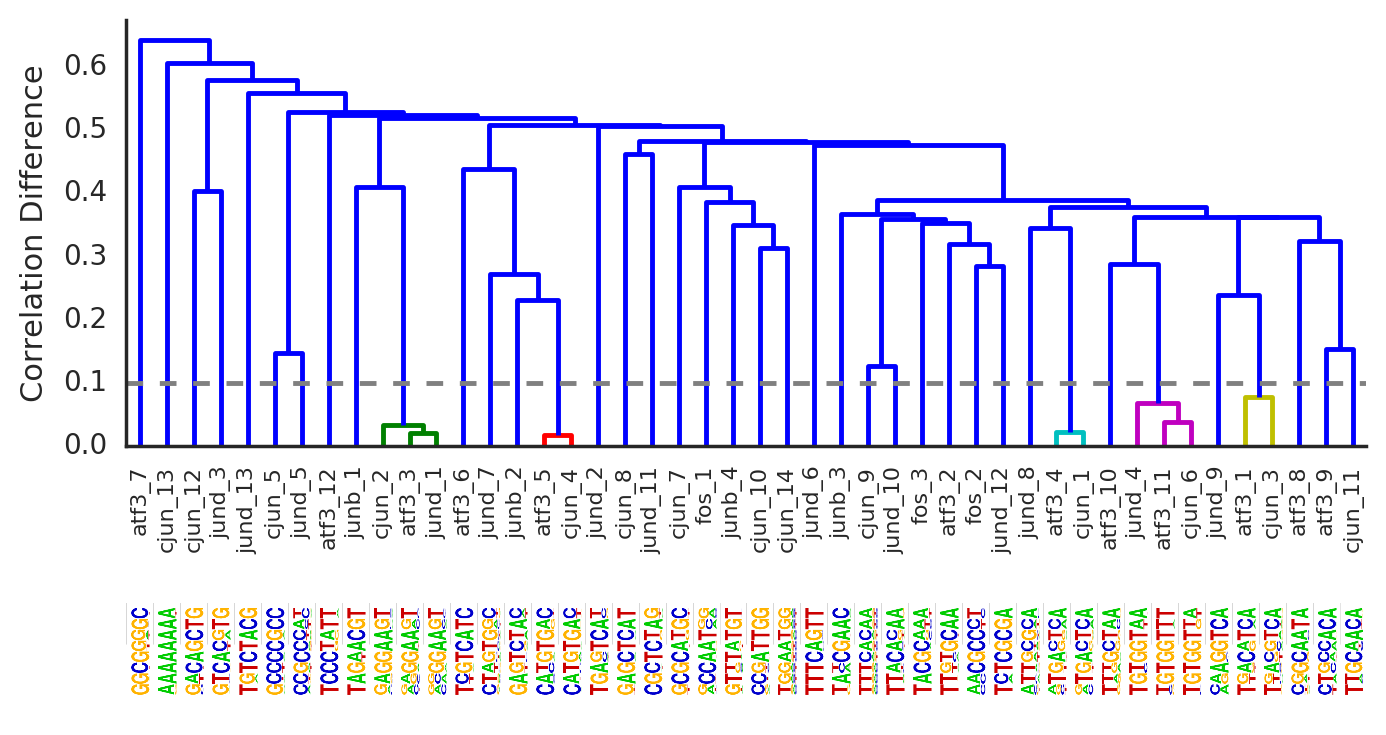

In [1485]:
motif_path = './denovo_motif_analysis/veh_motif_scanning/'
motif_names = veh_motif_names
# fig = plt.figure(figsize=(10,10))
with sns.axes_style('white'):
    Z=scipy.cluster.hierarchy.linkage(veh_correlations, 
                                      'single', 
                                      'correlation')
    gs = matplotlib.gridspec.GridSpec(2, len(motif_names), wspace=0.0, hspace=0.0)
    dendrogram_axis = plt.subplot(gs[0,:len(motif_names)])
    sns.despine()
    scipy.cluster.hierarchy.dendrogram(Z, 
                                       color_threshold=0.1,
                                       ax=dendrogram_axis,
                                       labels=motif_names)
    plt.axhline(0.1, linestyle='--', color='grey')
    plt.ylabel('Correlation Difference')
    
    sorted_motif_names = [x.get_text() for x in  dendrogram_axis.get_xticklabels()]
    for i in range(len(motif_names)):
        current_axis = plt.subplot(gs[1, i])
        mn = sorted_motif_names[i]
        img = plt.imread(motif_path + '/' + mn + '.logo.png')
        rotated_img = scipy.ndimage.rotate(img, 90)
        current_axis.imshow(rotated_img)
        current_axis.set_xticks([])
        current_axis.set_yticks([])
        current_axis.axis('off')
plt.savefig('./figures/figure_02_veh_motif_clustering.svg', bbox_inches='tight')

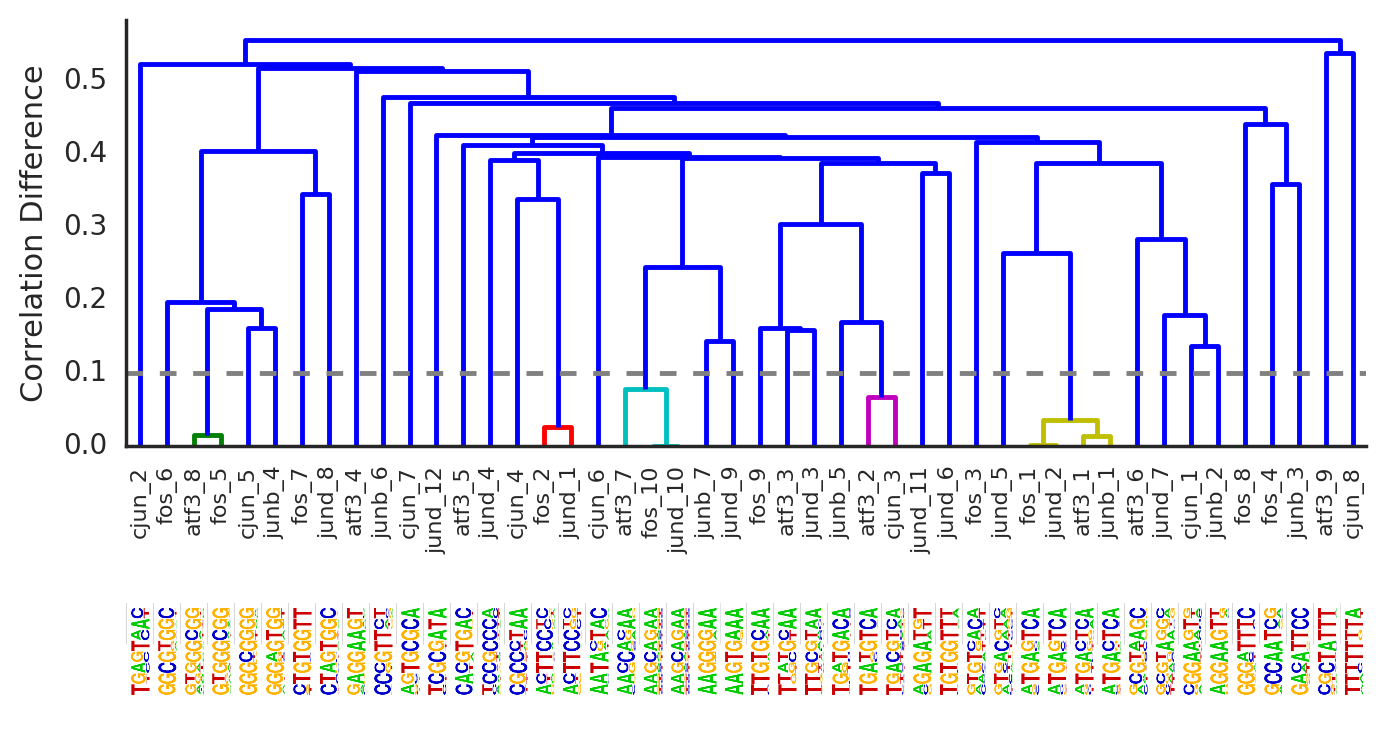

In [1486]:
motif_path = './denovo_motif_analysis/kla_motif_scanning/'
motif_names = kla_motif_names
# fig = plt.figure(figsize=(10,10))
with sns.axes_style('white'):
    Z=scipy.cluster.hierarchy.linkage(kla_correlations, 
                                      'single', 
                                      'correlation')
    gs = matplotlib.gridspec.GridSpec(2, len(motif_names), wspace=0.0, hspace=0.0)
    dendrogram_axis = plt.subplot(gs[0,:len(motif_names)])
    sns.despine()
    scipy.cluster.hierarchy.dendrogram(Z, 
                                       color_threshold=0.1,
                                       ax=dendrogram_axis,
                                       labels=motif_names)
    plt.axhline(0.1, linestyle='--', color='grey')
    plt.ylabel('Correlation Difference')
    
    sorted_motif_names = [x.get_text() for x in  dendrogram_axis.get_xticklabels()]
    for i in range(len(motif_names)):
        current_axis = plt.subplot(gs[1, i])
        mn = sorted_motif_names[i]
        img = plt.imread(motif_path + '/' + mn + '.logo.png')
        rotated_img = scipy.ndimage.rotate(img, 90)
        current_axis.imshow(rotated_img)
        current_axis.set_xticks([])
        current_axis.set_yticks([])
        current_axis.axis('off')
plt.savefig('./figures/figure_02_kla_motif_clustering.svg', bbox_inches='tight')

In [ ]:
%%bash
### combine motifs for motif scanning ###
out_path="./denovo_motif_analysis/veh_scanning_motif_clustering/combined.motif"
rm $out_path
touch $out_path
for f in ./denovo_motif_analysis/veh_scanning_motif_clustering/clustered_motifs/*motif;
do 
    if [[ ! "$f" == *"merged"* ]]; 
    then 
    unmerged=${f##*/}
    cat ./denovo_motif_analysis/veh_motif_scanning/$unmerged >> $out_path
    else
    # find first motif that was match
    merged=${f##*/}
    first_original=${merged:0:10}
    first_original=${first_original%_*}.motif
    cat ./denovo_motif_analysis/veh_motif_scanning/$first_original >> $out_path
    fi;
done

out_path="./denovo_motif_analysis/kla_scanning_motif_clustering/combined.motif"
rm $out_path
touch $out_path
for f in ./denovo_motif_analysis/kla_scanning_motif_clustering/clustered_motifs/*motif;
do 
    if [[ ! "$f" == *"merged"* ]]; 
    then 
    unmerged=${f##*/}
    cat ./denovo_motif_analysis/kla_motif_scanning/$unmerged >> $out_path
    else
    # find first motif that was match
    merged=${f##*/}
    first_original=${merged:0:10}
    first_original=${first_original%_*}.motif
    cat ./denovo_motif_analysis/kla_motif_scanning/$first_original >> $out_path
    fi;
done


In [ ]:
%%bash
### scan for top denovo motifs ###
rm -rf ./denovo_motif_analysis/veh_motif_scanning/*/
for peakFile in ./denovo_motif_analysis/veh_monomers_peaks/*_peaks.tsv
do
    peakName=${peakFile%_peaks.tsv}
    peakName=${peakName##*/}
    findMotifsGenome.pl $peakFile mm10 ./denovo_motif_analysis/veh_motif_scanning/${peakName} -nomotif -mknown ./denovo_motif_analysis/veh_scanning_motif_clustering/combined.motif -size 200 -p 8 &
    
done

rm -rf ./denovo_motif_analysis/kla_motif_scanning/*/
for peakFile in ./denovo_motif_analysis/kla_monomers_peaks/*_peaks.tsv
do
    peakName=${peakFile%_peaks.tsv}
    peakName=${peakName##*/}
    findMotifsGenome.pl $peakFile mm10 ./denovo_motif_analysis/kla_motif_scanning/${peakName} -nomotif -mknown ./denovo_motif_analysis/kla_scanning_motif_clustering/combined.motif -size 200 -p 8 &
    
done

In [ ]:
def combineKnownMotifResults(scanning_results_dir):
    sorted_motif_names = None
    monomer_fractions_dict = {}
    for result_dir in os.listdir(scanning_results_dir):
        if os.path.isdir(scanning_results_dir + '/' + result_dir):
            knownResults_path = scanning_results_dir + '/' + result_dir + '/knownResults.txt'
            knownResults_frame = pd.read_csv(knownResults_path, sep='\t')
            motif_names = knownResults_frame['Motif Name'].values
            if sorted_motif_names == None:
                sorted_motif_names = sorted(motif_names)

            string_target_fractions = knownResults_frame['% of Target Sequences with Motif'].values
            target_fractions = np.array([float(x[:-1]) for x in string_target_fractions])

            string_background_fractions = knownResults_frame['% of Background Sequences with Motif'].values
            background_fractions = np.array([float(x[:-1]) for x in string_background_fractions])

            enrichment = target_fractions/background_fractions
            # sort fractions by motif name
            name_fraction_dict =  dict(zip(motif_names, target_fractions))
            sorted_fractions = [name_fraction_dict[x] for x in sorted_motif_names]

            monomer_fractions_dict[result_dir] = sorted_fractions
    monomer_fractions_frame = pd.DataFrame(monomer_fractions_dict, 
                                           index = [x.split(',')[0] for x in sorted_motif_names])
    monomer_fractions_frame['Best Match'] = [x.split(',')[1].split('/')[0].split(':')[1] for x in sorted_motif_names]
    return monomer_fractions_frame

In [ ]:
# combine motif scanning results into one table
scanning_results_dir = './denovo_motif_analysis/veh_motif_scanning/'

veh_monomer_fractions_frame = combineKnownMotifResults(scanning_results_dir)

scanning_results_dir = './denovo_motif_analysis/kla_motif_scanning/'

kla_monomer_fractions_frame = combineKnownMotifResults(scanning_results_dir)

In [ ]:
monomers = ['atf3_veh', 'cjun_veh', 'jund_veh']
text_padding=20
logo_path = './denovo_motif_analysis/veh_motif_scanning_logos/'
with sns.axes_style('whitegrid', {'font.family':'monospace'}):
    
    fig = plt.figure(figsize=(4,13))

    data = veh_monomer_fractions_frame.ix[[x for x in veh_monomer_fractions_frame.index.values if not 'junb' in x and not 'fos' in x],: 
                                        ]
    numRows = data.shape[0]

    gs = matplotlib.gridspec.GridSpec(numRows, 
                                      len(monomers) + 1, 
                                      wspace=0.0, 
                                      hspace=0.0)
    
    heatmap_axis = plt.subplot(gs[:,1:len(monomers)])
    
    sorted_data = data.sort('atf3_veh', ascending=True)
    plotting_data = sorted_data[monomers].values
    img = heatmap_axis.pcolor(plotting_data, 
                        cmap = matplotlib.cm.Blues,
                       )
    fig.colorbar(img)
    
    # annotate data
#     for y in range(plotting_data.shape[0]):
#         for x in range(plotting_data.shape[1]):
#             plt.text(x + 0.5, y + 0.5, '%.2f' % plotting_data[y, x],
#                      horizontalalignment='center',
#                      verticalalignment='center',
#                      color='grey'
#                      )
    
    labels = []
    for t in list(zip(sorted_data.index.values, sorted_data['Best Match'].values)):
        l = t[0].rjust(text_padding,' ') + t[1].rjust(text_padding,' ') +  ' '.rjust(text_padding,' ')
        labels.append(l)
    
    heatmap_axis.set_yticks(np.array(range(len(labels))) + 0.5 );
    heatmap_axis.set_yticklabels(labels, size =10);
    
    heatmap_axis.set_xticks(np.array(range(len(monomers)))+0.5)
    heatmap_axis.set_xticklabels(monomers, rotation=90)
    
    heatmap_axis.set_ylim(0,numRows)
    
    motif_names = sorted_data.index.values
    for i in range(len(motif_names)):
        current_axis = plt.subplot(gs[numRows - 1 - i,0])
        mn = motif_names[i].split('-')[1]
        img = plt.imread(logo_path + '/' + mn + '.logo.png')
        current_axis.imshow(img, aspect='auto')
        current_axis.axis('Off')
        current_axis.set_xticks([])
        current_axis.set_yticks([])
        
        
plt.tight_layout()
plt.savefig('./figures/figure_02_veh_denovo_motif_matrix.svg', bbox_inches='tight')

In [ ]:
monomers = ['atf3_kla', 'cjun_kla', 'fos_kla', 'fra2_kla', 'junb_kla', 'jund_kla']
text_padding = 40
logo_path = './denovo_motif_analysis/kla_motif_scanning_logos/'
with sns.axes_style('whitegrid', {'font.family':'monospace'}):
    
    fig = plt.figure(figsize=(4,13))

    data = kla_monomer_fractions_frame
    data.sort('atf3_kla')
    numRows = data.shape[0]
    gs = matplotlib.gridspec.GridSpec(numRows, len(monomers) + 1, wspace=0.0, hspace=0.0)
    
    heatmap_axis = plt.subplot(gs[:,1:len(monomers)])
    sorted_data = data.sort('atf3_kla', ascending=True)
    plotting_data = sorted_data[monomers].values
    
    img = heatmap_axis.pcolor(plotting_data, 
                        cmap = matplotlib.cm.Reds,
#                         vmin = 0,
#                         vmax = 50
                       )
    
    # annotate data
#     for y in range(plotting_data.shape[0]):
#         for x in range(plotting_data.shape[1]):
#             plt.text(x + 0.5, y + 0.5, '%.2f' % plotting_data[y, x],
#                      horizontalalignment='center',
#                      verticalalignment='center',
#                      )
    cb = fig.colorbar(img)
    
    labels = []
    for t in list(zip(sorted_data.index.values, sorted_data['Best Match'].values)):
        l = t[0].rjust(text_padding,' ') + t[1].rjust(text_padding,' ') +  ' '.rjust(text_padding,' ')
        labels.append(l)
    
    heatmap_axis.set_yticks(np.array(range(len(labels))) + 0.5 );
    heatmap_axis.set_yticklabels(labels, size =10);
    
    heatmap_axis.set_xticks(np.array(range(len(monomers)))+0.5)
    heatmap_axis.set_xticklabels(monomers, rotation=90)
    
    heatmap_axis.set_ylim(0,numRows)

    motif_names = sorted_data.index.values
    for i in range(len(motif_names)):
        current_axis = plt.subplot(gs[numRows - 1 - i,0])
        mn = motif_names[i].split('-')[1]
        img = plt.imread(logo_path + '/' + mn + '.logo.png')
        current_axis.imshow(img, aspect='auto')
        current_axis.axis('Off')
        current_axis.set_xticks([])
        current_axis.set_yticks([])
plt.tight_layout()
# plt.subplots_adjust(left  = 0.0,  # the left side of the subplots of the figure
#                     right = 1,    # the right side of the subplots of the figure
#                     bottom = 0.0,   # the bottom of the subplots of the figure
#                     top = 1,      # the top of the subplots of the figure
#                     wspace = 0.0,   # the amount of width reserved for blank space between subplots
#                     hspace = 0.0,   # the amount of height reserved for white space between subplots
#                    )
plt.savefig('./figures/figure_02_kla_denovo_motif_matrix.svg', bbox_inches='tight')

### Peak Overlap Representations

#### Vehicle

In [ ]:
plt.figure(figsize=(3,3))
atf3_indices = set(summary_frame[summary_frame['c57bl6_atf3_veh'] > 0].index.values)
cjun_indices = set(summary_frame[summary_frame['c57bl6_cjun_veh'] > 0].index.values)
jund_indices = set(summary_frame[summary_frame['c57bl6_jund_veh'] > 0].index.values)
matplotlib_venn.venn3([atf3_indices, cjun_indices, jund_indices], set_labels=['atf3', 'cjun', 'jund'])
plt.savefig('./figures/figure_02_monomer_venn_veh.svg',  bbox_inches='tight')

In [ ]:
monomers = ['atf3_kla', 'cjun_kla', 'fos_kla', 'fra2_kla', 'junb_kla', 'jund_kla']
monomer_index_dict = dict(zip(monomers, 
                              range(len(monomers))))
matrix = np.zeros((len(monomers), len(monomers)))
# monomer_1 occupies which fraction of monomer_2
for monomer_1 in monomers:
    monomer_1_indices = set(summary_frame[summary_frame['c57bl6_' + monomer_1] > 0].index.values)
    ind_1 = monomer_index_dict[monomer_1]
    for monomer_2 in monomers:
        monomer_2_indices = set(summary_frame[summary_frame['c57bl6_' + monomer_2] > 0].index.values)
        ind_2 = monomer_index_dict[monomer_2]
        
        overlap = monomer_1_indices.intersection(monomer_2_indices)
        overlap_fraction = len(overlap)/len(monomer_2_indices)
        if not ind_1 == ind_2:
            matrix[ind_1][ind_2] = overlap_fraction
#         print(monomer_1, 'occupies', overlap_fraction, 'of', monomer_2)
labels = [x.replace('_kla','') for x in monomers]
matrix = pd.DataFrame(matrix, index = labels, columns = labels)


cg = sns.clustermap(matrix)
plt.close()
sorted_matrix = cg.data2d
for monomer in matrix.columns.values:
    sorted_matrix.ix[monomer, monomer] = 1
sns.heatmap(sorted_matrix,
            square=True,
            annot=True,
            fmt='0.2f',
            cmap='Blues')
plt.xlabel('... of Monomer 2 peaks')
plt.ylabel('Monomer 1 occupies...')
plt.savefig('./figures/figure_02_kla_overlap_matrix.svg',  bbox_inches='tight')

#### Chow Ruskey Diagram

In [ ]:
out_file = open('./chow_ruskey.R', 'w')
monomers = ['atf3', 'cjun', 'fos', 'fra2', 'junb', 'jund']
# monomer_1 occupies which fraction of monomer_2
out_file.write('library(Vennerable)\n')
for monomer in monomers:
    monomer_indices = summary_frame[summary_frame['c57bl6_' + monomer + '_kla'] > 0].index.values
    out_file.write(monomer + " <- make.unique(c('" + "','".join([x.replace('Merged-','') for x in monomer_indices])+ "'))\n")
out_file.write('x = list('+ ','.join([x + '=' + x for x in monomers]) +')\n')
out_file.write('vx=Venn(x)\n')
out_file.write('plot(vx, type="ChowRuskey", doWeights=TRUE)\n')
out_file.close()

#### Venn Diagram

In [ ]:
plt.figure(figsize=(3,3))
atf3_indices = set(summary_frame[summary_frame['c57bl6_atf3_kla'] > 0].index.values)
cjun_indices = set(summary_frame[summary_frame['c57bl6_cjun_kla'] > 0].index.values)
jund_indices = set(summary_frame[summary_frame['c57bl6_jund_kla'] > 0].index.values)
matplotlib_venn.venn3([atf3_indices, cjun_indices, jund_indices], set_labels=['atf3', 'cjun', 'jund'])
plt.savefig('./figures/figure_02_monomer_venn_kla.svg',  bbox_inches='tight')

### Enrichment of Cre vs Tre Motif

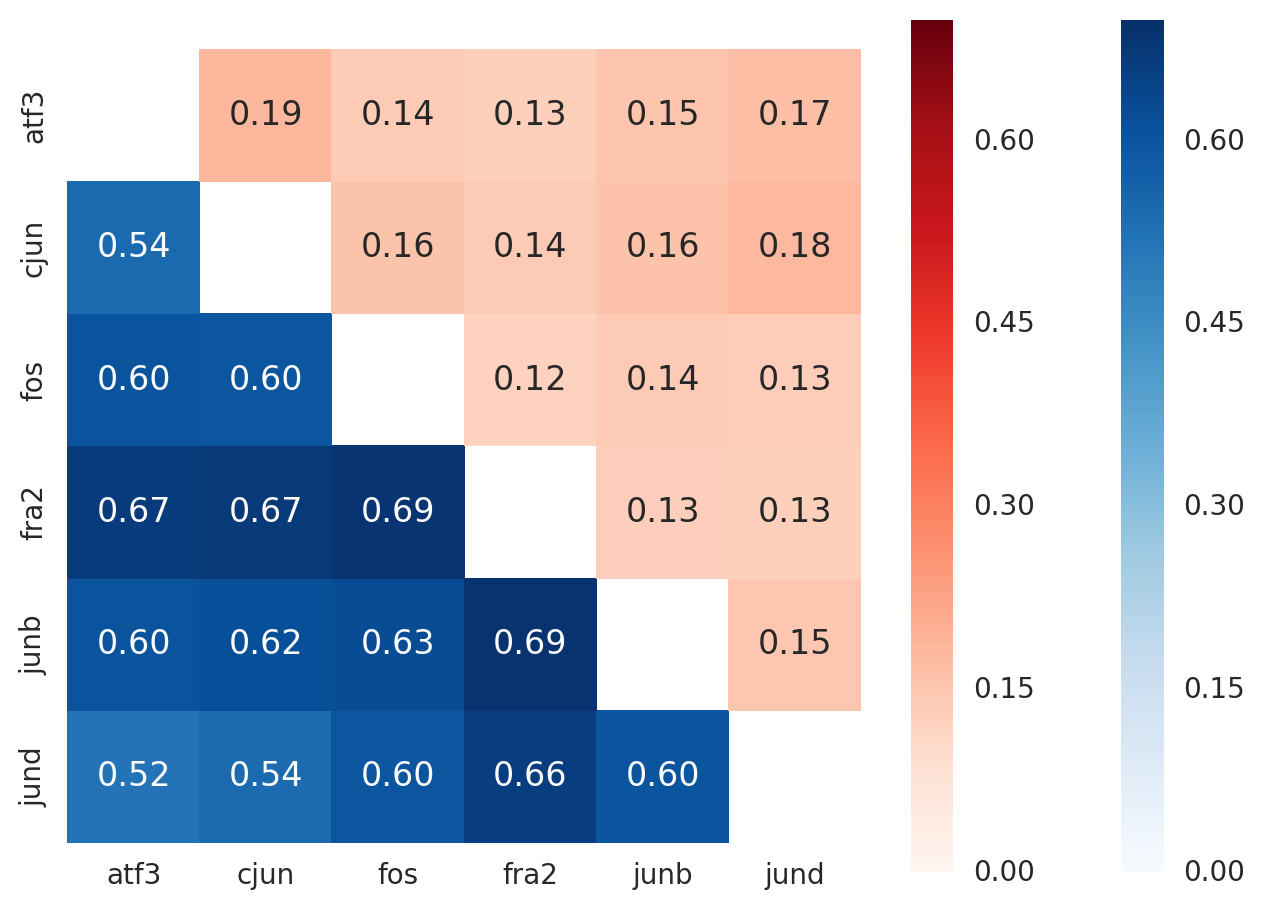

In [1421]:
# TRE - one spacer motif
# CRE - two spacer motif
# motif_score_frame['ap-1'] # TRE motif
# motif_score_frame['atf7_batf3_creb5'] # CRE motif
threshold = 5
monomers = ['atf3_kla', 'cjun_kla', 'fos_kla', 'fra2_kla', 'junb_kla', 'jund_kla']
c57bl6_columns = ['c57bl6_' + x  for x in monomers]
monomer_index_dict = dict(zip(monomers, 
                              range(len(monomers))))
tre_matrix = np.zeros((len(monomers), len(monomers)))
cre_matrix = np.zeros((len(monomers), len(monomers)))
# monomer_1 occupies which fraction of monomer_2
for monomer_1 in monomers:
    monomer_1_indices = set(summary_frame[summary_frame['c57bl6_' + monomer_1] > 0].index.values)
    ind_1 = monomer_index_dict[monomer_1]
    for monomer_2 in monomers:
        ind_2 = monomer_index_dict[monomer_2]
        if not ind_1 == ind_2:
            # look for monomers
            monomer_2_indices = set(summary_frame[summary_frame['c57bl6_' + monomer_2] > 0].index.values)
            intersection_indices = monomer_1_indices.intersection(monomer_2_indices)
        else:
            monomer_2_indices = set(summary_frame[summary_frame['c57bl6_' + monomer_2] > 0].index.values)
            intersection_indices = monomer_1_indices.intersection(monomer_2_indices)
        tre_scores = motif_score_frame.ix[intersection_indices, 'ap-1'].values
        cre_scores = motif_score_frame.ix[intersection_indices, 'atf7_batf3_creb5'].values

        tre_fraction = np.sum(tre_scores >= threshold)/len(tre_scores)
        cre_fraction = np.sum(cre_scores >= threshold)/len(cre_scores)

        tre_matrix[ind_2][ind_1] = tre_fraction
        cre_matrix[ind_1][ind_2] = cre_fraction
#             print(monomer_1, monomer_2, 'tre_fraction', tre_fraction, 'cre_fraction',cre_fraction)
        

labels = [x.replace('_kla','') for x in monomers]
# plot TRE fractions
mask = np.zeros_like(tre_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# for i in range(mask.shape[0]):
#     mask[i][i] = False
    
sns.heatmap(tre_matrix, 
            yticklabels=labels,
            xticklabels=labels,
            mask=mask,
            square=True,
            annot=True,
            fmt='0.2f',
            cmap='Blues',
            vmin=0,
            vmax=0.7)


mask = np.ones_like(cre_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = False
for i in range(mask.shape[0]):
    mask[i][i] = True
sns.heatmap(cre_matrix, 
            yticklabels=labels,
            xticklabels=labels,
            mask=mask,
            square=True,
            annot=True,
            fmt='0.2f',
            cmap='Reds',
            vmin=0,
            vmax=0.7)
plt.savefig('./figures/figure_02_cre_tre_matrix.svg',  bbox_inches='tight')

### Fraction of Unique Peaks

#### Vehicle

In [ ]:
fraction_list = []
threshold_list = []
factor_list = []
thresholds = np.arange(0,100,10)
strain = 'c57bl6'
treatment = 'veh'
factors = ['atf3', 'cjun', 'jund']
for factor in factors:
    print(factor)
    factor_indices = set(summary_frame[summary_frame['_'.join([strain, factor, treatment])] > 0].index.values)
    factor_tagCounts = ap1_meanTag_frame[ap1_meanTag_frame.index.isin(factor_indices)]['_'.join([strain, factor, treatment])]
    
    for threshold in thresholds:
        factor_threshold = np.percentile(factor_tagCounts, threshold)
        factor_filtered_indices = set(factor_tagCounts[factor_tagCounts >= factor_threshold].index.values)
        
        other_filtered_indices = set()
        for of in factors:
            if not of == factor:
                of_indices = set(summary_frame[summary_frame['_'.join([strain, of, treatment])] > 0].index.values)
                of_tagCounts = ap1_meanTag_frame[ap1_meanTag_frame.index.isin(of_indices)]['_'.join([strain, of, treatment])]
                
                of_threshold = np.percentile(of_tagCounts, threshold)
                of_filtered_indices = set(of_tagCounts[of_tagCounts >= of_threshold].index.values)

                other_filtered_indices = other_filtered_indices.union(of_filtered_indices)

        factor_unique_indices = factor_filtered_indices - other_filtered_indices
        unique_fraction = len(factor_unique_indices)/len(factor_filtered_indices)
        
        fraction_list.append(unique_fraction)
        threshold_list.append(threshold)
        factor_list.append(factor)
frame = pd.DataFrame({'Unique Peaks (% of Total Peaks)':fraction_list,
                      'Percentile Threshold':threshold_list,
                      'Monomer':factor_list}, 
                     )
with sns.axes_style('ticks'):
    sns.factorplot(data=frame, x = 'Percentile Threshold', y='Unique Peaks (% of Total Peaks)', hue='Monomer')
    plt.savefig('./figures/figure_02_unique_peak_fraction_veh.svg')



#### KLA

In [ ]:
fraction_list = []
threshold_list = []
factor_list = []
thresholds = np.arange(0,100,10)
strain = 'c57bl6'
treatment = 'kla'
factors = ['atf3', 'cjun', 'fos', 'fra2', 'junb', 'jund']
# factors = ['atf3', 'cjun', 'jund']


for factor in factors:
    print(factor)
    factor_indices = set(summary_frame[summary_frame['_'.join([strain, factor, treatment])] > 0].index.values)
    factor_tagCounts = ap1_meanTag_frame[ap1_meanTag_frame.index.isin(factor_indices)]['_'.join([strain, factor, treatment])]
    
    for threshold in thresholds:
        factor_threshold = np.percentile(factor_tagCounts, threshold)
        factor_filtered_indices = set(factor_tagCounts[factor_tagCounts >= factor_threshold].index.values)
        
        other_filtered_indices = set()
        for of in factors:
            if not of == factor:
                of_indices = set(summary_frame[summary_frame['_'.join([strain, of, treatment])] > 0].index.values)
                of_tagCounts = ap1_meanTag_frame[ap1_meanTag_frame.index.isin(of_indices)]['_'.join([strain, of, treatment])]
                
                of_threshold = np.percentile(of_tagCounts, threshold)
                of_filtered_indices = set(of_tagCounts[of_tagCounts >= of_threshold].index.values)

                other_filtered_indices = other_filtered_indices.union(of_filtered_indices)

        factor_unique_indices = factor_filtered_indices - other_filtered_indices
        unique_fraction = len(factor_unique_indices)/len(factor_filtered_indices)
        
        fraction_list.append(unique_fraction)
        threshold_list.append(threshold)
        factor_list.append(factor)
frame = pd.DataFrame({'Unique Peaks (% of Total Peaks)':fraction_list,
                      'Percentile Threshold':threshold_list,
                      'Monomer':factor_list}, 
                     )
with sns.axes_style('ticks'):
    sns.factorplot(data=frame, x = 'Percentile Threshold', y='Unique Peaks (% of Total Peaks)', hue='Monomer')
    plt.ylim(0,0.25)
    plt.savefig('./figures/figure_02_unique_peak_fraction_kla.svg')



### Create Bed Files for Use with GREAT

In [ ]:
outdir = './great_bed_files/'
if not os.path.isdir(outdir):
    os.mkdir(outdir)
else:
    for f in os.listdir(outdir):
        os.remove(outdir + '/' + f)
strain = 'c57bl6'
for treatment in ['veh', 'kla']:
    for monomer in ['atf3', 'cjun', 'fos', 'junb', 'jund']:
        position_frame = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0][['chr', 'start', 'end']]
        position_frame.to_csv(outdir + '/' + strain + '_' + monomer + '_' + treatment + '.bed', 
                              sep='\t', 
                              header = False,
                              index=False)

In [ ]:
atf3_indices = set(summary_frame[summary_frame['c57bl6_atf3_veh'] > 0].index.values)
cjun_indices = set(summary_frame[summary_frame['c57bl6_cjun_veh'] > 0].index.values)
jund_indices = set(summary_frame[summary_frame['c57bl6_jund_veh'] > 0].index.values)

atf3_unique_indices = atf3_indices - (cjun_indices.union(jund_indices))
cjun_unique_indices = cjun_indices - (atf3_indices.union(jund_indices))
jund_unique_indices = jund_indices - (atf3_indices.union(cjun_indices))

position_frame = summary_frame[summary_frame.index.isin(atf3_unique_indices)][['chr', 'start', 'end']]
position_frame.to_csv(outdir + '/' + strain + '_unique_atf3_veh_' + treatment + '.bed', 
                      sep='\t', 
                      header = False,
                      index=False)
position_frame = summary_frame[summary_frame.index.isin(cjun_unique_indices)][['chr', 'start', 'end']]
position_frame.to_csv(outdir + '/' + strain + '_unique_cjun_veh_' + treatment + '.bed', 
                      sep='\t', 
                      header = False,
                      index=False)
position_frame = summary_frame[summary_frame.index.isin(jund_unique_indices)][['chr', 'start', 'end']]
position_frame.to_csv(outdir + '/' + strain + '_unique_jund_veh_' + treatment + '.bed', 
                      sep='\t', 
                      header = False,
                      index=False)

# Figure 3 - Machine Learning Overview

### Schematic of classifier workflow

## VIF Analysis for Features

In [ ]:
def calculateVIF(features):
    '''
    calculates the VIF for each feature
    inputs: features, n X m (numSamples x numFeatures) vector of features
    output: VIFS, list of m VIFS
    '''
    vifs = []
    all_motifs = features.columns.values
    for motif in all_motifs:
        current_motif_scores = features[[motif]]
        other_motif_scores = features[[x for x in all_motifs if not x == motif]]
        lr = sklearn.linear_model.LinearRegression(n_jobs=-1)
        lr.fit(other_motif_scores, current_motif_scores)
        
        # calculate the coefficient of determination
        coeff_det = lr.score(other_motif_scores, current_motif_scores)
        # calculate VIF
        if coeff_det == 1:
            vif = 10
        else:
            vif = 1/(1-coeff_det)
        vifs.append(vif)
    toReturn = pd.Series(data = vifs, index = all_motifs)
    return toReturn

In [ ]:
strain = 'c57bl6'
factorTreatment_vif_dict = {}

### calculate VIFs for vehicle data ###
treatment = 'veh'
ap1_members = ['atf3','cjun','jund']    
for factor in ap1_members:
    start = time.time()
    target_indices = summary_frame[summary_frame[strain + '_' + factor + '_' + treatment] > 0.0].index.values
    background_indices = motif_score_background_frame[
        motif_score_background_frame['Factors'] == strain + '_' + factor + '_' + treatment + '-background'].index.values
    # select subset of background indices to use
    target_affinity_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(target_indices)]
    background_affinity_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(background_indices)]

    # merge target and background features together 
    affinity_features = pd.concat([target_affinity_features, background_affinity_features])
    print(factor, treatment, affinity_features.shape)
    vifs = calculateVIF(affinity_features)
    factorTreatment_vif_dict['_'.join([strain, factor, treatment])] = vifs
    end = time.time()
    print(factor, treatment, end - start)


### calculate VIFs for KLA data ###
treatment = 'kla'  
ap1_members = ['atf3','cjun', 'fos', 'fra2', 'junb','jund']    
for factor in ap1_members:
    start = time.time()
    target_indices = summary_frame[summary_frame[strain + '_' + factor + '_' + treatment] > 0.0].index.values
    background_indices = motif_score_background_frame[
        motif_score_background_frame['Factors'] == strain + '_' + factor + '_' + treatment + '-background'].index.values
    # select subset of background indices to use
    target_affinity_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(target_indices)]
    background_affinity_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(background_indices)]

    # merge target and background features together 
    affinity_features = pd.concat([target_affinity_features, background_affinity_features])
    print(factor, treatment, affinity_features.shape)
    vifs = calculateVIF(affinity_features)
    factorTreatment_vif_dict['_'.join([strain, factor, treatment])] = vifs
    end = time.time()
    print(factor, treatment, end - start)



In [ ]:
vif_frame = pd.DataFrame(factorTreatment_vif_dict)

frame = pd.DataFrame(vif_frame.stack(), columns = ['VIF'])
indices = vif_frame.stack().index.values
frame['Motif'] = [x[0] for x in indices]
frame['Factor'] = [x[1].split('_')[1] for x in indices]
frame['Treatment'] = [x[1].split('_')[2] for x in indices]

In [ ]:
with sns.axes_style('ticks'):
    sns.factorplot(data = frame[frame['Treatment'] == 'veh'],
                   x = 'Factor',
                   y = 'VIF',
                   kind = 'box',
                  size=4,
                  )
plt.ylim(0,10)
plt.xticks(rotation=90)
# plt.plot([-1,3], [10,10], c = 'black', linestyle='--')
plt.savefig('./figures/figure_04_vif_analysis_veh.svg', bbox_inches='tight')


with sns.axes_style('ticks'):
    sns.factorplot(data = frame[frame['Treatment'] == 'kla'],
                   x = 'Factor',
                   y = 'VIF',
                   kind = 'box',
                  size=4,
                  )
plt.ylim(0,10)
plt.xticks(rotation=90)
# plt.plot([-1,3], [10,10], c = 'black', linestyle='--')
plt.savefig('./figures/figure_04_vif_analysis_kla.svg', bbox_inches='tight')


### Stability of Coefficients

In [ ]:
# calculate top motifs
motif_names = list(motif_score_frame.columns[3:])

treatment_list = []
factor_list = []
mad_list = []
ratio_list = []
weight_list = []
motifName_list = []

for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        current_affinity_weights = factor_coeff_dict[monomer + '_' + treatment]
        current_affinity_weight_frame = pd.DataFrame(current_affinity_weights, 
                                                     ).T                
        mean_affinity_weights = current_affinity_weight_frame.mean(axis=1).values
        affinity_weight_mads = current_affinity_weight_frame.mad(axis=1).values
        
        ratios = np.abs(mean_affinity_weights)/ np.abs(affinity_weight_mads)
                
        treatment_list = treatment_list + [treatment] * len(mean_affinity_weights)
        factor_list = factor_list + [monomer] * len(mean_affinity_weights)
        mad_list = mad_list + list(affinity_weight_mads)
        ratio_list = ratio_list + list(ratios)
        weight_list = weight_list + list(mean_affinity_weights)
        motifName_list = motifName_list + motif_names
frame = pd.DataFrame({'Factor':factor_list,
                      'Treatment':treatment_list,
                      'MAD':mad_list,
                      'Weight/MAD Ratio': ratio_list,
                      'Log Weight/MAD Ratio': np.log2(ratio_list),
                      'Weight':weight_list,
                      'Motif': motifName_list})
        

In [ ]:
weight_threshold = 1.0

weights = mean_coeff_affinity_frame[monomer + '_' + treatment].abs()
        weights.sort(ascending=False)
        sorted_motifs = list(weights.index.values)
        top_motifs = sorted_motifs[:num_motifs_threshold]
        
top_veh_motifs = zscore_coeff_affinity_veh_frame[
    (zscore_coeff_affinity_veh_frame.max(axis=1) > 1* weight_threshold) |
    (zscore_coeff_affinity_veh_frame.min(axis=1) < -1* weight_threshold)
].index.values

top_kla_motifs = zscore_coeff_affinity_kla_frame[
    (zscore_coeff_affinity_kla_frame.max(axis=1) > 1* weight_threshold) |
    (zscore_coeff_affinity_kla_frame.min(axis=1) < -1* weight_threshold)
].index.values



In [ ]:
data = frame[(frame['Factor'].isin(['atf3','cjun', 'jund'])) &
             (frame['Treatment'] == 'veh') &
             (frame['Motif'].isin(top_veh_motifs))]
sns.factorplot(data = data, 
               x = 'Factor', 
#                y = 'Weight/MAD Ratio', 
               y = 'Log Weight/MAD Ratio',
               kind = 'swarm')
plt.title('Stability of Veh Motif Weights')
plt.savefig('./figures/figure_04_weight_stability_veh.svg', bbox_inches='tight')

data = frame[(frame['Treatment'] == 'kla') &
             (frame['Motif'].isin(top_kla_motifs))]
sns.factorplot(data = data, 
               x = 'Factor', 
#                y = 'Weight/MAD Ratio', 
               y = 'Log Weight/MAD Ratio',
               kind = 'swarm')
plt.title('Stability of KLA Motif Weights')
plt.savefig('./figures/figure_05_weight_stability_kla.svg', bbox_inches='tight')



# Figure 4 - Motifs for Vehicle Dimers

### All Motifs

In [ ]:
numIterations = 10
test_size = 0.2
background_ratio = 1.0
ap1_members = ['atf3','cjun', 'fos', 'fra2', 'junb','jund']    
factors = ['atf3','cjun', 'fos', 'junb','jund', 'cebpa', 'pu1', 'p65']

In [ ]:
# for monomers using the best motif scores for each motif
strain = 'c57bl6'

factor_coeff_dict = {}
factor_roc_dict = {}
factor_precision_dict = {}
factor_score_dict = {}
factor_testLabel_dict = {}

for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values

        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:np.ceil(background_ratio*len(target_indices))]
        
        target_affinity_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(target_indices)]
        background_affinity_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(background_indices)]

        # merge target and background features together 
        affinity_features = pd.concat([target_affinity_features, background_affinity_features])

        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = affinity_features.index.values)
        print(np.sum(labels), len(labels))
                
        results = train_classifier(affinity_features, 
                                    labels,
                                    numIterations = numIterations,
                                    test_size = test_size,
                                    )
        # unpack result tuples
        all_affinity_rocs = results[0]
        all_affinity_precisions = results[1]
        all_affinity_coefficients = results[2]
        all_affinity_scores = results[3]
        all_affinity_testLabels = results[4]
        
        factor_roc_dict[monomer + '_' + treatment] = all_affinity_rocs
        factor_precision_dict[monomer + '_' + treatment] = all_affinity_precisions
        factor_coeff_dict[monomer + '_' + treatment] = all_affinity_coefficients
        factor_score_dict[monomer + '_' + treatment] = all_affinity_scores
        factor_testLabel_dict[monomer + '_' + treatment] = all_affinity_testLabels
        print(monomer + '_' + treatment,
              'roc:', np.mean(all_affinity_rocs),
              'precision:', np.mean(all_affinity_precisions),
             )

In [ ]:
# for monomers using motif counts and best motif score 
strain = 'c57bl6'

for treatment in ['veh']:
    for monomer in ['cjun']:
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values

        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:np.ceil(background_ratio*len(target_indices))]
        
        target_affinity_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(target_indices)]
        background_affinity_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(background_indices)]

        # merge target and background features together 
        affinity_features = pd.concat([target_affinity_features, background_affinity_features])

        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = affinity_features.index.values)
        print(np.sum(labels), len(labels))
                
        results = train_classifier(affinity_features, 
                                    labels,
                                    numIterations = 50,
                                    test_size = test_size,
                                    )
        # unpack result tuples
        all_affinity_rocs = results[0]
        all_affinity_precisions = results[1]
        all_affinity_coefficients = results[2]
        all_affinity_scores = results[3]
        all_affinity_testLabels = results[4]
        
        factor_roc_dict[monomer + '_' + treatment] = all_affinity_rocs
        factor_precision_dict[monomer + '_' + treatment] = all_affinity_precisions
        factor_coeff_dict[monomer + '_' + treatment] = all_affinity_coefficients
        factor_score_dict[monomer + '_' + treatment] = all_affinity_scores
        factor_testLabel_dict[monomer + '_' + treatment] = all_affinity_testLabels
        print(monomer + '_' + treatment,
              'roc:', np.mean(all_affinity_rocs),
              'precision:', np.mean(all_affinity_precisions),
             )

In [ ]:
zscore_coeff_affinity_frame = calculate_zscore_weights(factor_coeff_dict,
                                  all_standardized_score_frame.columns.values)

zscore_coeff_affinity_veh_frame = zscore_coeff_affinity_frame[['atf3_veh', 'cjun_veh', 'jund_veh']]
zscore_coeff_affinity_kla_frame = zscore_coeff_affinity_frame[['atf3_kla', 'cjun_kla', 'fos_kla', 'fra2_kla', 'junb_kla', 'jund_kla']]

zscore_coeff_affinity_frame.to_pickle('zscore_coeff_affinity_frame.pickle')


In [ ]:
mean_coeff_affinity_frame = calculate_mean_weights(factor_coeff_dict,
                                  all_standardized_score_frame.columns.values)

mean_coeff_affinity_veh_frame = mean_coeff_affinity_frame[['atf3_veh', 'cjun_veh', 'jund_veh']]
mean_coeff_affinity_kla_frame = mean_coeff_affinity_frame[['atf3_kla', 'cjun_kla', 'fos_kla', 'fra2_kla', 'junb_kla', 'jund_kla']]

mean_coeff_affinity_frame.to_pickle('mean_coeff_affinity_frame.pickle')



### AP-1 Motif Only

In [ ]:
# for monomers using motif counts and best motif score 
strain = 'c57bl6'

factor_roc_ap1Only_dict = {}
factor_precision_ap1Only_dict = {}
factor_scores_ap1Only_dict = {}
factor_testLabel_ap1Only_dict = {}

for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values

        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:np.ceil(background_ratio*len(target_indices))]
        
        target_affinity_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(target_indices)]
        background_affinity_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(background_indices)]
        

        # merge target and background features together 
        affinity_features = pd.concat([target_affinity_features, background_affinity_features])
        
        affinity_features = affinity_features[['ap-1','atf7_batf3_creb5']]
        
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = affinity_features.index.values)
        print(np.sum(labels), len(labels))
                
        results = train_classifier(affinity_features, 
                                    labels,
                                    numIterations = 5,
                                    test_size = test_size,
                                    )
        # unpack result tuples
        all_affinity_rocs = results[0]
        all_affinity_precisions = results[1]
        all_affinity_coefficients = results[2]
        all_affinity_scores = results[3]
        all_affinity_testLabels = results[4]
        
        factor_roc_ap1Only_dict[monomer + '_' + treatment] = all_affinity_rocs
        factor_precision_ap1Only_dict[monomer + '_' + treatment] = all_affinity_precisions
        factor_scores_ap1Only_dict[monomer + '_' + treatment] = all_affinity_scores
        factor_testLabel_ap1Only_dict[monomer + '_' + treatment] = all_affinity_testLabels
        
        print(monomer + '_' + treatment,
              'roc:', np.mean(all_affinity_rocs),
              'precision:', np.mean(all_affinity_precisions),
             )

### Top Motif

#### Greedy Forward Feature Selection

In [ ]:
strain = 'c57bl6'
numIterations = 1
test_size = 0.2
background_ratio = 1.0
ap1_members = ['atf3','cjun', 'fos', 'fra2', 'junb','jund']    
num_to_select = 50

factor_roc_forward_dict = {}

for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        print('***starting selection for',monomer, treatment)
        selected_motifs = []
        performances = []
        motifs_to_consider = sorted(list(all_standardized_score_frame.columns.values))
        
        while len(motifs_to_consider) > 0 and len(selected_motifs) < num_to_select:
            best_motif = None
            best_performance = -1

            for motif in motifs_to_consider:
                motifs_to_use = selected_motifs + [motif]
                target_features = all_standardized_score_frame[
                    all_standardized_score_frame.index.isin(target_indices)][motifs_to_use]
                background_features = all_standardized_score_frame[
                    all_standardized_score_frame.index.isin(background_indices)][motifs_to_use]

                # merge target and background features together 
                features = pd.concat([target_features, background_features])

                labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                                   index = features.index.values)

                results = train_classifier(features, 
                                            labels,
                                            numIterations = numIterations,
                                            test_size = test_size,
                                            )
                # unpack result tuples
                all_rocs = results[0]
                all_precisions = results[1]

                mean_roc = np.mean(all_rocs)

                if mean_roc > best_performance:
                    best_performance = mean_roc
                    best_motif = motif
            performances.append(best_performance)
            selected_motifs.append(best_motif)
            motifs_to_consider.remove(best_motif)
            
            print('selection made', monomer, treatment, len(selected_motifs), best_performance, best_motif, )
        factor_roc_forward_dict[monomer + '_' + treatment] = list(zip(selected_motifs, performances))

In [ ]:
if "factor_roc_forward_dict" in locals():
    if len(factor_roc_forward_dict) > 1:
        pickle.dump(factor_roc_forward_dict, open('./factor_roc_forward_dict.pickle','wb'))
else:
    factor_roc_forward_dict = pickle.load(open('./factor_roc_forward_dict.pickle','rb'))

In [ ]:
for treatment in ['veh', 'kla']:
    if treatment == 'veh':
        members = ['atf3', 'cjun', 'jund']
    else:
        members = ['atf3', 'cjun', 'fos', 'fra2', 'junb', 'jund']
    for monomer in members:
        key = monomer + '_' + treatment
        rocs = [x[1] for x in factor_roc_forward_dict[key]]
        motifs = [x[0] for x in factor_roc_forward_dict[key]]
#         print(monomer, treatment, motifs[:40])
        plt.plot(range(len(rocs)), rocs, label = key)
    plt.xlabel('Motifs Included in Model')
    plt.ylabel('Model Performance')
    plt.xlim(0,50)
    
    plt.legend(loc='lower right')
    sns.despine()
    plt.show()
    

#### Fraction of top motifs that are unique to each monomer

In [ ]:
total_motifs = 50
thresholds = range(total_motifs)

for treatment in ['veh', 'kla']:
    if treatment == 'veh':
        members = ['atf3', 'cjun', 'jund']
    else:
        members = ['atf3', 'cjun', 'fos', 'fra2', 'junb', 'jund']
    plt.figure(figsize=(3,3))
    for monomer in members:
        fraction_list = []
        weights = mean_coeff_affinity_frame[monomer + '_' + treatment].abs()
        weights.sort(ascending=False)
        sorted_motifs = list(weights.index.values)
        
        for num_motifs in thresholds:
            current_motifs = sorted_motifs[:total_motifs]
            current_unique_motifs = set(current_motifs)
        
            for of in members:
                if not of == monomer:
                    other_weights = mean_coeff_affinity_frame[of + '_' + treatment].abs()
                    other_weights.sort(ascending=False)
                    other_motifs = set(list(other_weights.index.values)[:total_motifs])               
                    current_unique_motifs = current_unique_motifs - other_motifs

            selected_motifs = current_motifs[:num_motifs]
            selected_unique_motifs = set(selected_motifs).intersection(current_unique_motifs)
            unique_fraction = len(selected_unique_motifs)/max(1,len(current_unique_motifs))

            fraction_list.append(len(selected_unique_motifs))
        with sns.axes_style('white'):
            plt.plot(thresholds, fraction_list, label = monomer + '_' + treatment)
    plt.legend(loc = 'upper left')
    plt.xlabel('Number of Motifs Considered')
    plt.ylabel('Number of Unique Motifs')
    sns.despine()
    plt.savefig('./figures/figure_04_unique_motifs_' + treatment +'.svg', bbox_inches='tight')
    plt.show()


#### Overlap of Top Motifs

In [ ]:
total_motifs = 10
treatment = 'veh'
members = ['atf3', 'cjun', 'jund']
sets = []
labels = []
plt.figure(figsize=(3,3))
for monomer in members:
    fraction_list = []
    weights = mean_coeff_affinity_frame[monomer + '_' + treatment].abs()
    weights.sort(ascending=False)
    sorted_motifs = list(weights.index.values)

    current_motifs = sorted_motifs[:total_motifs]
    current_unique_motifs = set(current_motifs)
    sets.append(current_unique_motifs)
    labels.append(monomer)
matplotlib_venn.venn3(sets, set_labels=labels)
plt.title('Overlap of Top ' + str(total_motifs) + ' Motifs')
plt.savefig('./figures/figure_04_unique_motifs_veh_venn_top10.svg', bbox_inches='tight')

In [ ]:
total_motifs = 50
treatment = 'veh'
members = ['atf3', 'cjun', 'jund']
sets = []
labels = []
plt.figure(figsize=(3,3))
for monomer in members:
    fraction_list = []
    weights = mean_coeff_affinity_frame[monomer + '_' + treatment].abs()
    weights.sort(ascending=False)
    sorted_motifs = list(weights.index.values)

    current_motifs = sorted_motifs[:total_motifs]
    current_unique_motifs = set(current_motifs)
    sets.append(current_unique_motifs)
    labels.append(monomer)
matplotlib_venn.venn3(sets, set_labels=labels)
plt.title('Overlap of Top ' + str(total_motifs) + ' Motifs')
plt.savefig('./figures/figure_04_unique_motifs_veh_venn_top50.svg', bbox_inches='tight')

#### Train Model on Top Motifs

In [ ]:
# for monomers using motif counts and best motif score for top motifs
strain = 'c57bl6'
num_motifs_threshold = 20
factor_roc_top_dict = {}
factor_precision_top_dict = {}
factor_scores_top_dict = {}
factor_testLabel_top_dict = {}
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        # determine top motifs
        weights = mean_coeff_affinity_frame[monomer + '_' + treatment].abs()
        weights.sort(ascending=False)
        sorted_motifs = list(weights.index.values)
        top_motifs = sorted_motifs[:num_motifs_threshold]
        print(len(top_motifs))
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values
       
        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:np.ceil(background_ratio*len(target_indices))]
        
        target_affinity_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(target_indices)]
        background_affinity_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(background_indices)]
        
        # merge target and background features together 
        affinity_features = pd.concat([target_affinity_features, background_affinity_features])
        
        affinity_features = affinity_features[top_motifs]
        
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = affinity_features.index.values)
                
        results = train_classifier(affinity_features, 
                                    labels,
                                    numIterations = numIterations,
                                    test_size = test_size,
                                    )
        # unpack result tuples
        all_affinity_rocs = results[0]
        all_affinity_precisions = results[1]
        all_affinity_coefficients = results[2]
        all_affinity_scores = results[3]
        all_affinity_testLabels = results[4]
        
        factor_roc_top_dict[monomer + '_' + treatment] = all_affinity_rocs
        factor_precision_top_dict[monomer + '_' + treatment] = all_affinity_precisions
        factor_testLabel_top_dict[monomer + '_' + treatment] = all_affinity_testLabels

        print(monomer + '_' + treatment,
              'roc:', np.mean(all_affinity_rocs),
              'precision:', np.mean(all_affinity_precisions),
             )

### Polynomial Features

In [ ]:
def make_interaction_features(features):
    '''
    input: raw unstandardized scores
    output: motif features with dgree 2 interaction terms
    creates motif features with degree 2 interaction terms 
    '''
    polynomial_transformer = sklearn.preprocessing.PolynomialFeatures(degree=2, 
                                                                      interaction_only=True)
    interaction_features = pd.DataFrame(polynomial_transformer.fit_transform(features))
    
    # drop first column which is invariant and always 1
    interaction_features = interaction_features.ix[:,1:]  
    
    # fix column names
    motifs = features.columns.values
    interaction_term_columns = list(motifs)
    for i in range(len(motifs)-1):
        for j in range(i+1,len(motifs)):
            interaction_term_columns.append(motifs[i]+'::'+motifs[j])
    interaction_features.columns = interaction_term_columns
    interaction_features.index = features.index.values
    
    # standardize features
    scaler = preprocessing.StandardScaler()
    standardized_interaction_features = pd.DataFrame(scaler.fit_transform(interaction_features))
    standardized_interaction_features.columns = interaction_features.columns.values
    standardized_interaction_features.index = interaction_features.index.values
    standardized_interaction_features = standardized_interaction_features[sorted(standardized_interaction_features.columns.values)]


    return standardized_interaction_features, interaction_features, interaction_term_columns

In [ ]:
# for monomers using motif counts and best motif score for polynomial motifs
strain = 'c57bl6'
background_ratio =1.0
weight_threshold = 1.0

# top_veh_motifs = zscore_coeff_affinity_veh_frame[(zscore_coeff_affinity_veh_frame.max(axis=1) >= weight_threshold) |
#                                 (zscore_coeff_affinity_veh_frame.min(axis=1) < -1 * weight_threshold)
#                                 ].index.values

# top_kla_motifs = zscore_coeff_affinity_kla_frame[(zscore_coeff_affinity_kla_frame.max(axis=1) >= weight_threshold) |
#                                 (zscore_coeff_affinity_kla_frame.min(axis=1) < -1 * weight_threshold)
#                                 ].index.values
top_veh_motifs = zscore_coeff_affinity_veh_frame[(zscore_coeff_affinity_veh_frame.max(axis=1) >= weight_threshold)
                                ].index.values

top_kla_motifs = zscore_coeff_affinity_kla_frame[(zscore_coeff_affinity_kla_frame.max(axis=1) >= weight_threshold)
                                ].index.values
top_motifs = sorted(set(top_veh_motifs).union(top_kla_motifs))

factor_coeff_interaction_dict = {}
factor_roc_interaction_dict = {}
factor_precision_interaction_dict = {}
factor_testLabel_interaction_dict = {}
factor_scores_interaction_dict = {}
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values

        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:np.ceil(background_ratio*len(target_indices))]
        
        target_affinity_features = all_score_frame[all_score_frame.index.isin(target_indices)]
        background_affinity_features = all_score_frame[all_score_frame.index.isin(background_indices)]
        # merge target and background features together 
        affinity_features = pd.concat([target_affinity_features, background_affinity_features])
        affinity_features = affinity_features[top_motifs]
        print(affinity_features.shape)
        
        standardized_interaction_score_features, interaction_score_features, motif_names = make_interaction_features(affinity_features)
        
        print(standardized_interaction_score_features.shape)
               
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = affinity_features.index.values)
        
        results = train_classifier(standardized_interaction_score_features, 
                                    labels,
                                    numIterations = 5,
                                    test_size = test_size,
                                    )
        # unpack result tuples
        all_affinity_rocs = results[0]
        all_affinity_precisions = results[1]
        all_affinity_coefficients = results[2]
        all_affinity_scores = results[3]
        all_affinity_testLabels = results[4]
        
        factor_coeff_interaction_dict[monomer + '_' + treatment] = all_affinity_coefficients
        factor_roc_interaction_dict[monomer + '_' + treatment] = all_affinity_rocs
        factor_precision_interaction_dict[monomer + '_' + treatment] = all_affinity_precisions
        factor_testLabel_interaction_dict[monomer + '_' + treatment] = all_affinity_testLabels
        factor_scores_interaction_dict[monomer + '_' + treatment] = all_affinity_scores


        print(monomer + '_' + treatment,
              'roc:', np.mean(all_affinity_rocs),
              'precision:', np.mean(all_affinity_precisions),
             )

In [ ]:
# combine weights
interaction_names = list(top_motifs)
for i in range(len(top_motifs)-1):
    for j in range(i+1,len(top_motifs)):
        interaction_names.append(top_motifs[i]+'::'+top_motifs[j])

coeff_affinity_interaction_frame = calculate_mean_weights(factor_coeff_interaction_dict,
                                                         interaction_names
                                                         )

In [ ]:
if "coeff_affinity_interaction_frame" in locals():
    if coeff_affinity_interaction_frame.shape[1] > 1:
        coeff_affinity_interaction_frame.to_pickle('coeff_affinity_interaction_frame.pickle')
else:
    coeff_affinity_interaction_frame = pd.read_pickle('coeff_affinity_interaction_frame.pickle')

### gkmSVM

In [ ]:
!if [ ! -d ./gkmsvm_files ]; then mkdir ./gkmsvm_files; fi


In [ ]:
! rm ./gkmsvm_files/*

In [ ]:
numIterations = 5
test_size = 0.5
background_ratio = 1.0
ap1_members = ['atf3','cjun', 'fos', 'fra2', 'junb','jund']    
factors = ['atf3','cjun', 'fos', 'junb','jund', 'cebpa', 'pu1', 'p65']

In [ ]:
### for all peaks in vehicle using gapped k-mers on background data
### write script
background_ratio = 1.0
numIterations = 5
for treatment in ['veh', 'kla']:
    script_file = open('gkmsvm_' + treatment + '.sh', 'w')
    for monomer in ap1_members:
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values

        shuffle(background_indices)
        background_indices = background_indices[:np.ceil(background_ratio*len(target_indices))]
        
        target_affinity_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(target_indices)]
        background_affinity_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(background_indices)]
        
        # merge target and background features together 
        features = pd.concat([target_affinity_features, background_affinity_features])
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = features.index.values)

        if np.sum(labels) > 100:
            print(monomer + '_' + treatment)
            all_aucs = []
            all_precisions = []
            for iteration in range(numIterations):  
                # split data into training and test sets
                training_features, test_features, training_labels, test_labels = get_split(
                    features, labels, test_size = test_size)

                # create fasta files for positive and negative sequences
                training_positive_path = './gkmsvm_files/' + monomer + '_' + treatment+ '_training_positive_' +str(iteration) + '.fa'
                training_negative_path = './gkmsvm_files/' + monomer + '_' + treatment+ '_training_negative_' +str(iteration) + '.fa'

                training_positive_file = open(training_positive_path,'w' )
                training_negative_file = open(training_negative_path,'w' )
                test_path = './gkmsvm_files/' + monomer + '_' + treatment+ '_test_' + str(iteration) + '.fa'

                test_file = open(test_path,'w')

                numPositiveSeqs = np.sum(training_labels)
                count=0
                for i in range(len(training_labels)):
                    index = training_labels.index[i]
                    label = training_labels[i]
                    seq = _id_sequence_dict[index]

                    if label == True:
                        training_positive_file.write('>' + index + '\n')
                        training_positive_file.write(seq + '\n')
                    else:
                        training_negative_file.write('>' + index + '\n')
                        training_negative_file.write(seq + '\n')
                        count+=1
                for i in range(len(test_labels)):
                    index = test_labels.index[i]
                    label = test_labels[i]
                    seq = _id_sequence_dict[index]
                    test_file.write('>' + index + '\n')
                    test_file.write(seq + '\n')

                training_positive_file.close()
                training_negative_file.close()
                test_file.close()

                #  Run classifier
                model_prefix = './gkmsvm_files/' + monomer + '_' + treatment + '_' +str(iteration)
                model_path = model_prefix + '.model.txt'
                results_path = model_prefix + '_results.txt'

                script_file.write('(gkmtrain '+ training_positive_path + ' ' + training_negative_path + ' ' + model_prefix +
                          ' -T 8 -m 64000;')
                if iteration == (numIterations - 1):
                    script_file.write('gkmpredict '+ test_path + ' ' + model_path + ' ' +  results_path + ' -T 8)\n')
                else:
                    script_file.write('gkmpredict '+ test_path + ' ' + model_path + ' ' +  results_path + ' -T 8)&\n')
                
    script_file.close()

In [ ]:
%%bash
chmod a+x ./gkmsvm_veh.sh 
./gkmsvm_veh.sh

In [ ]:
%%bash
chmod a+x ./gkmsvm_kla.sh 
./gkmsvm_kla.sh

In [ ]:
### for all peaks in vehicle using gapped k-mers on background data
### read performance
factor_auc_dict_gkmSVM = {}
factor_precision_dict_gkmSVM = {}

for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        background_indices = motif_score_background_frame.index.values

        target_affinity_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(target_indices)]
        background_affinity_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(background_indices)]
        
        # merge target and background features together 
        features = pd.concat([target_affinity_features, background_affinity_features])
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = features.index.values)

        if np.sum(labels) > 100:
            print(monomer + '_' + treatment)
            all_aucs = []
            all_precisions = []
            for iteration in range(numIterations):  
                model_prefix = './gkmsvm_files/' + monomer  + '_' + treatment+ '_' +str(iteration)
                results_path = model_prefix + '_results.txt'


                index_score_dict = {} #{peakID: gkmSVM score}
                with open(results_path) as f:
                    data = f.readlines()
                for line in data:
                    tokens=line.strip().split()
                    score = float(tokens[1])
                    index = tokens[0]
                    index_score_dict[index] = score
                # define true labels
                index_label_dict = dict(zip(labels.index.values, labels.values))

                sorted_indices = sorted(index_score_dict.keys())

                sorted_scores = np.array([index_score_dict[x] for x in sorted_indices])
                test_labels = np.array([index_label_dict[x] for x in sorted_indices])

                min_score = np.min(sorted_scores)
                if min_score < 0:
                    normalized_scores = sorted_scores + abs(min_score)
                normalized_scores = normalized_scores/np.max(normalized_scores)
                normalized_scores = sorted_scores
                # score predictions  

                current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, normalized_scores, average = None)
                current_precision = sklearn.metrics.average_precision_score(test_labels, normalized_scores, average = None)
                all_precisions.append(current_precision)
                all_aucs.append(current_roc_auc)

            # average scoring metrics 

            mean_roc_auc = np.mean(all_aucs) 
            mean_precision = np.mean(all_precisions)

            factor_auc_dict_gkmSVM[monomer + '_' + treatment]= all_aucs
            factor_precision_dict_gkmSVM[monomer + '_' + treatment]= all_precisions

            print(monomer + '_' + treatment,
                  'roc:', mean_roc_auc, 
                  'precision:', mean_precision,
                  'numTestPositives:', np.sum(test_labels)
                 )

### Motif Scores

In [ ]:
background_ratio = 1.0
ap1_members = ['atf3','cjun', 'fos', 'fra2', 'junb','jund']    
factors = ['atf3','cjun', 'fos', 'junb','jund', 'cebpa', 'pu1', 'p65']

In [ ]:
factor_auc_dict_motifScore = {}
factor_precision_dict_motifScore = {}
strain = 'c57bl6'

for treatment in ['veh', 'kla']:
    for monomer in ap1_members:    

        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values

        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:np.ceil(background_ratio*len(target_indices))]
        
        target_features = motif_score_frame[motif_score_frame.index.isin(target_indices)][['ap-1']]
        background_features = motif_score_background_frame[motif_score_background_frame.index.isin(background_indices)][['ap-1']]
        
        # merge target and background features together 
        features = pd.concat([target_features, background_features])
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                   index = features.index.values)

        roc_pwm = sklearn.metrics.roc_auc_score(labels, features)
        precision_pwm = sklearn.metrics.roc_auc_score(labels, features)

        print(monomer, treatment, roc_pwm, precision_pwm)
        factor_auc_dict_motifScore[monomer + '_' + treatment]= [roc_pwm]
        factor_precision_dict_motifScore[monomer + '_' + treatment]= [precision_pwm]
    

### Bayesian Markov Models

In [ ]:
sequence_path = './individual_peak_sequences/'
if not os.path.isdir(sequence_path):
    os.mkdir(sequence_path)
else:
    for f in os.listdir(sequence_path):
        os.remove(sequence_path + '/' + f)
background_ratio = 1.0
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values

        background_indices = background_indices[:np.ceil(background_ratio*len(target_indices))]
        
        # write positive sequences
        positive_sequence_file = open(sequence_path + '/' + monomer + '_' + treatment + '.fasta', 'w')
        for ind in target_indices:
            seq = _id_sequence_dict[ind]
            positive_sequence_file.write('>'+ind+'\n')
            positive_sequence_file.write(seq + '\n')
        positive_sequence_file.close()
        
        # write negative sequences
        negative_sequence_file = open(sequence_path + '/' + monomer + '_' + treatment + '_background.fasta', 'w')
        for ind in background_indices:
            seq = _id_sequence_dict[ind]
            negative_sequence_file.write('>'+ind+'\n')
            negative_sequence_file.write(seq + '\n')
        negative_sequence_file.close()        
        
        

In [ ]:
%%bash
num_proc=20 # number of motifs to calculate at once

if [ ! -d ./bamm_output ]; then mkdir ./bamm_output; fi

script_path="./calculate_bamm.sh"
if [ -f $script_path ]; then rm $script_path; fi
counter=0
for neg_seq in ./individual_peak_sequences/*background*;
    # define output path
    do out_path=${neg_seq/individual_peak_sequences/bamm_output};
    out_path=${out_path/_background.fasta}
    if [ ! -d $out_path ]; then 
    counter=$[counter + 1]
    

    # find path to negative sequences
    pos_seq=${neg_seq/_background}

#     echo BaMMmotif $out_path $pos_seq --negSequenceSet $neg_seq --reverseComp --scorePosSequenceSet --scoreNegSequenceSet --maxPWMs 3 >>$script_path;
        if [ "$counter" -eq "$num_proc" ]; then
            echo "BaMMmotif $out_path $pos_seq --negSequenceSet $neg_seq --reverseComp --scorePosSequenceSet --scoreNegSequenceSet --maxPWMs 3" >>$script_path;
        else
            echo "BaMMmotif $out_path $pos_seq --negSequenceSet $neg_seq --reverseComp --scorePosSequenceSet --scoreNegSequenceSet --maxPWMs 3 &" >>$script_path;
        fi;
        if [ "$counter" -eq "$num_proc" ]; then counter=0; fi
    fi
done



In [ ]:
!bash ./calculate_bamm.sh

In [ ]:
# score BAMM performance
factor_auc_dict_bammScore = {}
factor_precision_dict_bammScore = {}

for treatment in ['veh', 'kla']:
    for monomer in ap1_members:           
        # read in positive scores
        positive_scores = []
        with open('./bamm_output/' + monomer + '_' + treatment +'/'+ monomer + '_' + treatment + '-1.logOdds') as f:
            data = f.readlines()

        for line in data:
            tokens = line.strip().split()
            log_odds = [float(x) if not x =='NA' else 0.0 for x in tokens]
            positive_scores.append(max(log_odds))
        
        # read in negative scores
        negative_scores = []
        with open('./bamm_output/' + monomer + '_' + treatment +'/'+ monomer + '_' + treatment + '_background-1.logOdds') as f:
            data = f.readlines()
        for line in data:
            tokens = line.strip().split()
            log_odds = [float(x) if not x =='NA' else 0.0 for x in tokens]
            negative_scores.append(max(log_odds))
        
        labels = [True] * len(positive_scores) + [False] * len(negative_scores)
        scores = positive_scores + negative_scores
        roc_bamm = sklearn.metrics.roc_auc_score(labels, scores)
        precision_bamm = sklearn.metrics.roc_auc_score(labels, scores)
        
        factor_auc_dict_bammScore[monomer + '_' + treatment] = [roc_bamm]
        factor_precision_dict_bammScore[monomer + '_' + treatment] = [precision_bamm]
        
        print(monomer, treatment, roc_bamm, precision_bamm) 

#### Add Motifs According to overall weight

In [ ]:
strain = 'c57bl6'
numIterations = 1
test_size = 0.2
background_ratio = 1.0
ap1_members = ['atf3','cjun', 'fos', 'fra2', 'junb','jund']    
factor_roc_overall_forward_dict = {}
num_motifs = 50


for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        factor_roc_overall_forward_dict[monomer + '_' + treatment] = []
        weights = mean_coeff_affinity_frame[monomer + '_' + treatment].abs()
        weights.sort(ascending=False)
        sorted_motifs = list(weights.index.values)
        print(monomer, treatment)
        for i in range(num_motifs):
            motifs_to_use = sorted_motifs[:i+1]
            target_features = all_standardized_score_frame[
                all_standardized_score_frame.index.isin(target_indices)][motifs_to_use]
            background_features = all_standardized_score_frame[
                all_standardized_score_frame.index.isin(background_indices)][motifs_to_use]

            # merge target and background features together 
            features = pd.concat([target_features, background_features])

            labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                               index = features.index.values)

            results = train_classifier(features, 
                                        labels,
                                        numIterations = numIterations,
                                        test_size = test_size,
                                        )
            # unpack result tuples
            all_rocs = results[0]
            all_precisions = results[1]

            mean_roc = np.mean(all_rocs)
            print(monomer, treatment, i+1, mean_roc)
            factor_roc_overall_forward_dict[monomer + '_' + treatment].append(mean_roc)

In [ ]:
if "factor_roc_overall_forward_dict" in locals():
    if len(factor_roc_overall_forward_dict) > 1:
        pickle.dump(factor_roc_overall_forward_dict, open('./factor_roc_overall_forward_dict.pickle','wb'))
else:
    factor_roc_overall_forward_dict = pickle.load(open('./factor_roc_overall_forward_dict.pickle','rb'))

In [ ]:
with sns.axes_style('white'):
    for treatment in ['veh', 'kla']:
        plt.figure(figsize=(3,3))
        if treatment == 'veh':
            members = ['atf3', 'cjun', 'jund']
        else:
            members = ['atf3', 'cjun', 'fos', 'fra2', 'junb', 'jund']
        for monomer in members:
            key = monomer + '_' + treatment
            rocs = [x for x in factor_roc_overall_forward_dict[key]]
            plt.plot(range(len(rocs)), rocs, label = key)
        plt.xlabel('Motifs Included in Model')
        plt.ylabel('Model Performance')
        plt.xlim(0,50)
        plt.ylim(0.5,0.95)
        # Fix axes
        ax = plt.gca()
        x0,x1 = ax.get_xlim()
        y0,y1 = ax.get_ylim()
        ax.set_aspect(abs(x1-x0)/abs(y1-y0))
        plt.legend(loc='lower right')
        sns.despine()
        plt.savefig('./figures/figure_04_numMotifs_vs_performance_'+treatment+'.svg', bbox_inches='tight')
        plt.show()
    
    

In [ ]:
strain = 'c57bl6'
numIterations = 1
test_size = 0.2
background_ratio = 1.0
ap1_members = ['atf3','cjun', 'fos', 'fra2', 'junb','jund']    
factor_roc_overall_backward_dict = {}
num_motifs = 196


for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        factor_roc_overall_backward_dict[monomer + '_' + treatment] = []
        weights = mean_coeff_affinity_frame[monomer + '_' + treatment].abs()
        weights.sort(ascending=False)
        sorted_motifs = list(weights.index.values)
        print(monomer, treatment)
        for i in range(num_motifs):
            motifs_to_use = sorted_motifs[i:]
            target_features = all_standardized_score_frame[
                all_standardized_score_frame.index.isin(target_indices)][motifs_to_use]
            background_features = all_standardized_score_frame[
                all_standardized_score_frame.index.isin(background_indices)][motifs_to_use]

            # merge target and background features together 
            features = pd.concat([target_features, background_features])

            labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                               index = features.index.values)

            results = train_classifier(features, 
                                        labels,
                                        numIterations = numIterations,
                                        test_size = test_size,
                                        )
            # unpack result tuples
            all_rocs = results[0]
            all_precisions = results[1]

            mean_roc = np.mean(all_rocs)
#             print(monomer, treatment, i+1, mean_roc)
            factor_roc_overall_backward_dict[monomer + '_' + treatment].append(mean_roc)

In [ ]:
if "factor_roc_overall_backward_dict" in locals():
    if len(factor_roc_overall_backward_dict) > 1:
        pickle.dump(factor_roc_overall_backward_dict, open('./factor_roc_overall_backward_dict.pickle','wb'))
else:
    factor_roc_overall_backward_dict = pickle.load(open('./factor_roc_overall_backward_dict.pickle','rb'))

In [ ]:
with sns.axes_style('white'):
    for treatment in ['veh', 'kla']:
        plt.figure(figsize=(3,3))
        if treatment == 'veh':
            members = ['atf3', 'cjun', 'jund']
        else:
            members = ['atf3', 'cjun', 'fos', 'fra2', 'junb', 'jund']
        # calculate average motif score performance
        motif_score_rocs = []
        for monomer in members:
            motif_score_rocs.append(factor_auc_dict_motifScore[monomer + '_' + treatment][0])
        mean_motif_score_roc = np.mean(motif_score_rocs)
        for monomer in members:
            key = monomer + '_' + treatment
            rocs = [x for x in factor_roc_overall_backward_dict[key]]
            plt.plot(range(len(rocs)), rocs, label = key)
        
        plt.plot([0,len(rocs)], [mean_motif_score_roc, mean_motif_score_roc], linestyle='--', c='black', label = 'Avg Motif Score')


        plt.xlabel('Motifs Removed from Model')
        plt.ylabel('Model Performance')
        plt.xlim(-0.9,200)
        plt.ylim(0.5,0.95)
        # Fix axes
        ax = plt.gca()
        x0,x1 = ax.get_xlim()
        y0,y1 = ax.get_ylim()
        ax.set_aspect(abs(x1-x0)/abs(y1-y0))
        plt.legend(loc='upper right')
        sns.despine()
        plt.savefig('./figures/figure_04_numMotifsRemoved_vs_performance_'+treatment+'.svg', bbox_inches='tight')
        plt.show()
    
    

## Classifier Performance

In [ ]:
numIterations = 5


In [ ]:
monomers = []
rocs = []
feature_set = []
for factor in ['atf3_veh', 'cjun_veh', 'jund_veh']:
    monomers = monomers  + [factor]
    rocs = rocs + factor_auc_dict_motifScore[factor]
    feature_set = feature_set + ['Motif Score']
    
    monomers = monomers  + [factor]
    rocs = rocs + factor_auc_dict_bammScore[factor]
    feature_set = feature_set + ['BAMM Motif Score']
    
    monomers = monomers + numIterations * [factor]
    rocs = rocs + factor_roc_ap1Only_dict[factor][:numIterations]
    feature_set = feature_set + numIterations * ['Known Motif Model']
    
    monomers = monomers + numIterations * [factor]
    rocs = rocs + factor_roc_dict[factor][:numIterations]
    feature_set = feature_set + numIterations * ['All Motifs Model']
    
    monomers = monomers + numIterations * [factor]
    rocs = rocs + factor_roc_top_dict[factor][:numIterations]
    feature_set = feature_set + numIterations * ['Top 20 Motifs Model']
    
#     monomers = monomers + numIterations * [factor]
#     rocs = rocs + factor_roc_interaction_dict[factor]
#     feature_set = feature_set + numIterations * ['Interaction Motifs']
    
    monomers = monomers + numIterations * [factor]
    rocs = rocs + factor_auc_dict_gkmSVM[factor][:numIterations]
    feature_set = feature_set + numIterations * ['gkmSVM']
    
    
    
data = pd.DataFrame({'Factor':monomers,
                     'roc':rocs,
                     'Feature Set': feature_set
                     })

for treatment in ['veh']:
    factor_roc_tuples = [(x, np.mean(factor_roc_dict[x])) for x in factor_roc_dict if treatment in x]
    sorted_monomers = [y[0] for y in sorted(factor_roc_tuples, key=lambda x:x[1])]
    with sns.axes_style('ticks'):
        plottingFrame = sns.factorplot(data = data[data['Factor'].str.contains(treatment)],
                                    x='Factor',
                                    y='roc',
#                                     order = sorted_monomers,
                                    palette='Set1',
                                    size=3,
                                    hue='Feature Set',
                                    kind = 'bar')
                                    #markers = '.', s='0.01')
        sns.despine()
        plt.xticks(rotation=90)
        plt.ylabel('aucROC')
        plt.xlabel('AP-1 Monomer')
        plt.ylim(0.5,0.99)
        plt.title('Classifier Performance')
        plt.savefig('./figures/figure_04_performance.pdf')
        plt.show()

    

### Distribution of Motif Weights

In [ ]:
with sns.axes_style('ticks'):
    plt.figure(figsize=(4,4))
    sns.distplot(mean_coeff_affinity_frame['cjun_veh'])
    sns.despine()
    plt.xlabel('Motif Weight')
    plt.ylabel('Frequency (KDE)')
plt.savefig('./figures/figure_04_motif_weight_distribution.svg', bbox_inches='tight')

### Visualization of significant weights

In [ ]:
num_motifs = 50
treatment = 'veh'
members = ['atf3', 'cjun', 'jund']
top_motifs = []
for monomer in members:
    weights = mean_coeff_affinity_frame[monomer + '_' + treatment].abs()
    weights.sort(ascending=False)
    sorted_motifs = list(weights.index.values)
#     print(len(sorted_motifs[:num_motifs]))
#     print(monomer, treatment, sorted_motifs[:num_motifs])
    top_motifs = top_motifs + sorted_motifs[:num_motifs]
top_motifs = sorted(set(top_motifs)) 

# print(len(top_motifs))

signed_ranks_frame = mean_coeff_affinity_frame[[]]
for monomer in members:
    weights = mean_coeff_affinity_frame[monomer + '_' + treatment]
    ranks = mean_coeff_affinity_frame[monomer + '_' + treatment].abs().rank(ascending=True)
    signed_ranks = [-1 * ranks[i] if weights[i] <0 else ranks[i] for i in range(len(weights))]
    signed_ranks_frame[monomer + '_' + treatment] = signed_ranks


In [ ]:
data = signed_ranks_frame.ix[top_motifs]
negative_data = data[data.min(axis=1) < -1*num_motifs]
positive_data = data[data.max(axis=1) > num_motifs]

In [ ]:
negative_data['mean'] = signed_ranks_frame.abs().mean(axis=1)
negative_data = negative_data.sort('mean', ascending=False)
del negative_data['mean']


hm = sns.heatmap(negative_data, 
                 square=True,
                 cmap = 'Blues_r',
                 vmin = -196,
                 vmax = -50
                 )
pos = hm.get_position()
hm.set_position([pos.x0, pos.y0, pos.width, pos.height*1.4])
hm.set_yticklabels(size=8, labels = negative_data.index.values[::-1]);
hm.set_xticklabels(size=8, labels = negative_data.columns.values);
plt.savefig('./figures/figure_04_weight_heatmap_negative.svg', bbox_inches='tight')



In [ ]:
positive_data['max'] = signed_ranks_frame.abs().max(axis=1)
positive_data = positive_data.sort('max', ascending=False)
del positive_data['max']


hm = sns.heatmap(positive_data, 
                 square=True,
                 cmap = 'Reds',
                 vmax = 196,
                 vmin = 50
                 )
pos = hm.get_position()
hm.set_position([pos.x0, pos.y0, pos.width, pos.height*1.4])
hm.set_yticklabels(size=8, labels = positive_data.index.values[::-1]);
hm.set_xticklabels(size=8, labels = positive_data.columns.values);
plt.savefig('./figures/figure_04_weight_heatmap_positive.svg', bbox_inches='tight')




### Visualize Interactions

In [ ]:
# for monomers using motif counts and best motif score for polynomial motifs
strain = 'c57bl6'
background_ratio =1.0
weight_threshold = 1.0

# top_veh_motifs = zscore_coeff_affinity_veh_frame[(zscore_coeff_affinity_veh_frame.max(axis=1) >= weight_threshold) |
#                                 (zscore_coeff_affinity_veh_frame.min(axis=1) < -1 * weight_threshold)
#                                 ].index.values

# top_kla_motifs = zscore_coeff_affinity_kla_frame[(zscore_coeff_affinity_kla_frame.max(axis=1) >= weight_threshold) |
#                                 (zscore_coeff_affinity_kla_frame.min(axis=1) < -1 * weight_threshold)
#                                 ].index.values
top_veh_motifs = zscore_coeff_affinity_veh_frame[(zscore_coeff_affinity_veh_frame.max(axis=1) >= weight_threshold)
                                ].index.values

top_kla_motifs = zscore_coeff_affinity_kla_frame[(zscore_coeff_affinity_kla_frame.max(axis=1) >= weight_threshold)
                                ].index.values
top_motifs = sorted(set(top_veh_motifs).union(top_kla_motifs))



In [ ]:
factor_additiveInteraction_dict = {}
factor_multiplicativeInteraction_dict = {}


for factor_treatment in coeff_affinity_interaction_frame.columns.values:
    weights = coeff_affinity_interaction_frame[factor_treatment]
    additive_interactions = []
    multiplicative_interactions = []
    for i in range(len(top_motifs)-1):
        motif1 = top_motifs[i]
        weight1 = weights.ix[motif1]
        for j in range(i+1,len(top_motifs)):
            motif2 = top_motifs[j]
            interaction_term = motif1 + '::' + motif2
            weight2 = weights.ix[motif2]
            interaction_weight = weights.ix[interaction_term]
            
            additive_interaction = np.exp(weight1 + weight2 + interaction_weight) - np.exp(weight1) - np.exp(weight2) + 1
            multiplicative_interaction = (np.exp(weight1 + weight2 + interaction_weight))/((np.exp(weight1)) * (np.exp(weight2)))
            
            additive_interactions.append(additive_interaction)
            multiplicative_interactions.append(multiplicative_interaction)
    factor_additiveInteraction_dict[factor_treatment] = additive_interactions
    factor_multiplicativeInteraction_dict[factor_treatment] = multiplicative_interactions
    
interaction_terms = []
for i in range(len(top_motifs)-1):
    motif1 = top_motifs[i]
    for j in range(i+1,len(top_motifs)):
        motif2 = top_motifs[j]
        interaction_term = motif1 + '::' + motif2
        interaction_terms.append(interaction_term)
interaction_additive_frame = pd.DataFrame(factor_additiveInteraction_dict, index = interaction_terms) 
interaction_multiplicative_frame = pd.DataFrame(factor_multiplicativeInteraction_dict, index = interaction_terms) 

In [ ]:
interaction_additive_veh_frame = interaction_additive_frame[['atf3_veh','cjun_veh', 'jund_veh']]
interaction_multiplicative_veh_frame = interaction_multiplicative_frame[['atf3_veh','cjun_veh', 'jund_veh']]

interaction_additive_kla_frame = interaction_additive_frame[['atf3_kla','cjun_kla','fos_kla', 'junb_kla', 'jund_kla']]
interaction_multiplicative_kla_frame = interaction_multiplicative_frame[['atf3_kla','cjun_kla','fos_kla', 'junb_kla', 'jund_kla']]

In [ ]:
interaction_threshold = 1.0
data = interaction_additive_veh_frame[
    (interaction_additive_veh_frame.max(axis=1) > 1* interaction_threshold)
]
plotting_data = pd.DataFrame(data.stack(), columns= ['Weight'])
index = plotting_data.index.values
plotting_data['Motif'] = [x[0] for x in index]
plotting_data['Monomer'] = [x[1] for x in index]
plotting_data.sort(['Weight'], inplace=True)

sns.factorplot(data = plotting_data, 
               x = 'Motif', 
               y='Weight', 
               kind = 'bar',
               hue = 'Monomer',
               hue_order = ['atf3_veh','cjun_veh', 'jund_veh'],
               size=7)
plt.xticks(rotation = 90, size=10);
plt.title('Veh Additive Interactions')

data = interaction_additive_kla_frame[
    (interaction_additive_kla_frame.max(axis=1) > 1* interaction_threshold)
]
plotting_data = pd.DataFrame(data.stack(), columns= ['Weight'])
index = plotting_data.index.values
plotting_data['Motif'] = [x[0] for x in index]
plotting_data['Monomer'] = [x[1] for x in index]
plotting_data.sort(['Weight'], inplace=True)

sns.factorplot(data = plotting_data, 
               x = 'Motif', 
               y='Weight', 
               kind = 'bar',
               hue = 'Monomer',
               hue_order = ['atf3_kla','cjun_kla','fos_kla', 'junb_kla', 'jund_kla'],
               size=7)
plt.xticks(rotation = 90, size=10);
plt.title('KLA Additive Interactions')

In [ ]:
interaction_threshold = 1.5
data = interaction_multiplicative_veh_frame[
    (interaction_multiplicative_veh_frame.max(axis=1) > 1* interaction_threshold)
]
plotting_data = pd.DataFrame(data.stack(), columns= ['Weight'])
index = plotting_data.index.values
plotting_data['Motif'] = [x[0] for x in index]
plotting_data['Monomer'] = [x[1] for x in index]
plotting_data.sort(['Weight'], inplace=True)

sns.factorplot(data = plotting_data, 
               x = 'Motif', 
               y='Weight', 
               kind = 'bar',
               hue = 'Monomer',
               hue_order = ['atf3_veh','cjun_veh', 'jund_veh'],
               size=7)
plt.xticks(rotation = 90, size=10);
plt.title('Veh multiplicative Interactions')

data = interaction_multiplicative_kla_frame[
    (interaction_multiplicative_kla_frame.max(axis=1) > 1* interaction_threshold)
]
plotting_data = pd.DataFrame(data.stack(), columns= ['Weight'])
index = plotting_data.index.values
plotting_data['Motif'] = [x[0] for x in index]
plotting_data['Monomer'] = [x[1] for x in index]
plotting_data.sort(['Weight'], inplace=True)

sns.factorplot(data = plotting_data, 
               x = 'Motif', 
               y='Weight', 
               kind = 'bar',
               hue = 'Monomer',
               hue_order = ['atf3_kla','cjun_kla','fos_kla', 'junb_kla', 'jund_kla'],
               size=7)
plt.xticks(rotation = 90, size=10);
plt.title('KLA multiplicative Interactions')

# Figure 5 - Context Change after KLA treatment

In [ ]:
numIterations = 5
test_size = 0.5
background_ratio = 1.0
ap1_members = ['atf3','cjun', 'fos', 'junb','jund']    
factors = ['atf3','cjun', 'fos', 'junb','jund', 'atac', 'cebpa', 'pu1', 'p65']

### Classifier Performance

In [ ]:
monomers = []
rocs = []
feature_set = []
for factor in ['atf3_kla','cjun_kla', 'fos_kla','fra2_kla', 'junb_kla','jund_kla']:
    monomers = monomers  + [factor]
    rocs = rocs + factor_auc_dict_motifScore[factor]
    feature_set = feature_set + ['Motif Score']
    
    monomers = monomers  + [factor]
    rocs = rocs + factor_auc_dict_bammScore[factor]
    feature_set = feature_set + ['BAMM Motif Score']
    
    monomers = monomers + numIterations * [factor]
    rocs = rocs + factor_roc_ap1Only_dict[factor][:numIterations]
    feature_set = feature_set + numIterations * ['Known Motif Model']
    
    monomers = monomers + numIterations * [factor]
    rocs = rocs + factor_roc_dict[factor][:numIterations]
    feature_set = feature_set + numIterations * ['All Motifs Model']
    
    monomers = monomers + numIterations * [factor]
    rocs = rocs + factor_roc_top_dict[factor][:numIterations]
    feature_set = feature_set + numIterations * ['Top 20 Motifs Model']
    
#     monomers = monomers + numIterations * [factor]
#     rocs = rocs + factor_roc_interaction_dict[factor]
#     feature_set = feature_set + numIterations * ['Interaction Motifs']
    
    monomers = monomers + numIterations * [factor]
    rocs = rocs + factor_auc_dict_gkmSVM[factor][:numIterations]
    feature_set = feature_set + numIterations * ['gkmSVM']
    
data = pd.DataFrame({'Factor':monomers,
                     'roc':rocs,
                     'Feature Set': feature_set
                     })

for treatment in ['kla']:
    factor_roc_tuples = [(x, np.mean(factor_roc_dict[x])) for x in factor_roc_dict if treatment in x]
    sorted_monomers = [y[0] for y in sorted(factor_roc_tuples, key=lambda x:x[1])]
    with sns.axes_style('ticks'):
        plottingFrame = sns.factorplot(data = data[data['Factor'].str.contains(treatment)],
                                    x='Factor',
                                    y='roc',
#                                     order = sorted_monomers,
                                    palette='Set1',
                                    size=3,
                                    hue='Feature Set',
                                    kind = 'bar')
                                    #markers = '.', s='0.01')
        sns.despine()
        plt.xticks(rotation=90)
        plt.ylabel('aucROC')
        plt.xlabel('AP-1 Monomer')
        plt.ylim(0.5,0.99)
        plt.title('Classifier Performance')
        plt.savefig('./figures/figure_05_performance.svg', bbox_inches='tight')
        plt.show()

    

### Scatter plot for motif weights before and after Vehicle

In [ ]:
# scatterplot of weights
factor1 = 'jund_veh'
factor2 = 'jund_kla'
delta_threshold = 1.0
targets = ['ap-1', 'cebp', 'rel', 'egr']
# targets = []
motifs = mean_coeff_affinity_veh_frame.index.values

for factor in ['atf3', 'cjun', 'jund']:
    factor1 = factor + '_veh'
    factor2 = factor + '_kla'
    with sns.axes_style('ticks',{'axes.edgecolor': 'black',
                             }):
        plt.figure(figsize=(2,2))
        x_vals = mean_coeff_affinity_veh_frame[factor1]
        y_vals = mean_coeff_affinity_kla_frame[factor2]
        # calculate colors
        plt.scatter(x_vals,
                    y_vals,
                    marker = '.', 
                    s=15,
                    edgecolor='None')
        plt.xlabel(factor1.replace('c57bl6_','') + ' Vehicle Motif Weight')
        plt.ylabel(factor2.replace('c57bl6_','') + ' KLA Motif Weight')
        sns.despine()


        # calculate labels
        for i in range(len(x_vals)):
            x = x_vals[i]
            y = y_vals[i]
            if motifs[i] in targets:
                plt.annotate(motifs[i], xy=(x,y) , size=10)
        
        plt.xlim(-1,1)
        plt.ylim(-1,1)
        # Fix axes
        ax = plt.gca()
        x0,x1 = ax.get_xlim()
        y0,y1 = ax.get_ylim()
        ax.set_aspect(abs(x1-x0)/abs(y1-y0))
        plt.savefig('./figures/figure_05_weight_scatter_'+factor1+'.png', bbox_inches='tight')
        plt.savefig('./figures/figure_05_weight_scatter_'+factor1+'.pdf', bbox_inches='tight')
        plt.show()


In [ ]:
# scatterplot of weights
motifs = mean_coeff_affinity_veh_frame.index.values
threshold = 0.1
for factor in ['atf3', 'cjun', 'jund']:
    factor1 = factor + '_veh'
    factor2 = factor + '_kla'
    with sns.axes_style('ticks'):
        x_vals = mean_coeff_affinity_veh_frame[factor1]
        differences = mean_coeff_affinity_frame[factor2] - mean_coeff_affinity_frame[factor1]
#         fractional_differences = (differences+0.2)/(mean_coeff_affinity_frame[factor1]+0.2)
        y_vals = differences
        # calculate colors
        jg = sns.jointplot(data=pd.DataFrame({'Veh Motif Weight':x_vals, 
                                   'Change in Weight (KLA-Veh)':y_vals}),
                     x='Veh Motif Weight',
                     y='Change in Weight (KLA-Veh)',
                     size=3,
                     stat_func=None,
                     xlim=(-0.6,1),
                     ylim=(-0.2,0.4),
                     kind='reg',
                     marginal_kws={'hist':False},
                     joint_kws = {'fit_reg':False,
                                  'scatter_kws':{
                                  'marker':'.', 
                                  's':5,
                                  'edgecolor':'None'}}
                     )  

#         calculate labels
        for i in range(len(x_vals)):
            x = x_vals[i]
            y = y_vals[i]
            if(abs(y)) >= threshold:
                jg.ax_joint.annotate(motifs[i], xy=(x,y) , size=8)
                print(factor, motifs[i])
        jg.ax_joint.set_xticks(np.arange(-1,1.1,0.5))
        plt.savefig('./figures/figure_05_weight_differences_scatter_'+factor1+'.pdf', bbox_inches='tight')
        plt.show()



### Heatmap of Differences

In [ ]:
motifs = mean_coeff_affinity_veh_frame.index.values
threshold = 0.095
differences = mean_coeff_affinity_frame[['atf3_kla', 'cjun_kla', 'jund_kla']].values -mean_coeff_affinity_frame[['atf3_veh', 'cjun_veh', 'jund_veh']].values
kla_veh_difference_frame = pd.DataFrame(differences, columns = ['atf3', 'cjun', 'jund'], index = mean_coeff_affinity_frame.index.values)

data = kla_veh_difference_frame[kla_veh_difference_frame.abs().max(axis=1)> threshold]
data['sum'] = data.sum(axis=1)
data.sort('sum', inplace=True, ascending = False)
del data['sum']
sns.heatmap(data,
           square = True,
           vmin=-0.25,
           vmax=0.25)
plt.savefig('./figures/figure_05_weight_differences_heatmap.pdf', bbox_inches='tight')



### Venn Diagrams

In [ ]:
p65_indices = set(summary_frame[summary_frame['c57bl6_p65_kla'] > 0].index.values)
for monomer in ['atf3', 'cjun', 'jund']:
    plt.figure(figsize=(3,3))
    veh_indices = set(summary_frame[summary_frame['c57bl6_' + monomer + '_veh'] > 0].index.values)
    kla_indices = set(summary_frame[summary_frame['c57bl6_' + monomer + '_kla'] > 0].index.values)
    matplotlib_venn.venn3([veh_indices, kla_indices, p65_indices],
                         set_labels=[monomer + '_veh', monomer+'_kla', 'p65_kla'])
    plt.savefig('./figures/figure_05_venn_'+monomer+'.svg', bbox_inches='tight')
    plt.show()

### Weight Heatmap

In [ ]:
zscore_threshold = 0.5
indices = zscore_coeff_affinity_kla_frame[
    (zscore_coeff_affinity_kla_frame.max(axis=1) > 1* zscore_threshold)
].index.values
data = mean_coeff_affinity_kla_frame.ix[indices,:]
# data = zscore_coeff_combined_kla_frame[
#     (zscore_coeff_combined_kla_frame.max(axis=1) > 1* weight_threshold) |
#     (zscore_coeff_combined_kla_frame.min(axis=1) < -1* weight_threshold)
# ]
mins = data.min(axis=1)
maxes = data.mean(axis=1)
differences = data[[]]
for col in data.columns:
    differences[col] = data[col].values - mins.values
mins.sort()
sorted_maxes = maxes[mins.index.values]
sorted_differences = differences.ix[mins.index.values,:]
sorted_fractional_differences = (sorted_differences.T/sorted_maxes).T
cm = sns.clustermap(sorted_fractional_differences,
                    col_cluster=False,
                    row_cluster=False,
                    cmap='Reds',
#                    vmax=2,
                   )
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), 
         fontsize=10, 
         rotation=0);
plt.setp(cm.ax_heatmap.xaxis.get_majorticklabels(), 
         fontsize=10, 
         rotation=90);

cm.ax_row_dendrogram.clear()
cm.ax_row_dendrogram.plot(sorted(mins, reverse=True), range(len(mins)))
cm.ax_row_dendrogram.set_yticks([])
cm.ax_row_dendrogram.set_xlim(0,1)
cm.ax_row_dendrogram.set_ylim(0,len(mins))

hm = cm.ax_heatmap.get_position()
cm.ax_heatmap.set_position([hm.x0, hm.y0, hm.width*0.25, hm.height])
plt.savefig('./figures/figure_05_weight_heatmap_kla.png', bbox_inches='tight')


### Visualization of significant weights

In [ ]:
num_motifs = 50
treatment = 'kla'
members = ['atf3', 'cjun', 'fos', 'fra2', 'junb', 'jund']
top_motifs = []
for monomer in members:
    weights = mean_coeff_affinity_frame[monomer + '_' + treatment].abs()
    weights.sort(ascending=False)
    sorted_motifs = list(weights.index.values)
#     print(len(sorted_motifs[:num_motifs]))
#     print(monomer, treatment, sorted_motifs[:num_motifs])
    top_motifs = top_motifs + sorted_motifs[:num_motifs]
top_motifs = sorted(set(top_motifs)) 

# print(len(top_motifs))

signed_ranks_frame = mean_coeff_affinity_frame[[]]
for monomer in members:
    weights = mean_coeff_affinity_frame[monomer + '_' + treatment]
    ranks = mean_coeff_affinity_frame[monomer + '_' + treatment].abs().rank(ascending=True)
    signed_ranks = [-1 * ranks[i] if weights[i] <0 else ranks[i] for i in range(len(weights))]
    signed_ranks_frame[monomer + '_' + treatment] = signed_ranks


In [ ]:
data = signed_ranks_frame.ix[top_motifs]
negative_data = data[data.min(axis=1) < -1*num_motifs]
positive_data = data[data.max(axis=1) > num_motifs]

In [ ]:
negative_data['mean'] = signed_ranks_frame.abs().mean(axis=1)
negative_data = negative_data.sort('mean', ascending=False)
del negative_data['mean']


hm = sns.heatmap(negative_data, 
                 square=True,
                 cmap = 'Blues_r',
                 vmin = -196,
                 vmax = -50
                 )
pos = hm.get_position()
hm.set_position([pos.x0, pos.y0, pos.width, pos.height*1.4])
hm.set_yticklabels(size=8, labels = negative_data.index.values[::-1]);
hm.set_xticklabels(size=8, labels = negative_data.columns.values);
plt.savefig('./figures/figure_05_weight_heatmap_negative.svg', bbox_inches='tight')



In [ ]:
positive_data['max'] = signed_ranks_frame.abs().max(axis=1)
positive_data = positive_data.sort('max', ascending=False)
del positive_data['max']


hm = sns.heatmap(positive_data, 
                 square=True,
                 cmap = 'Reds',
                 vmax = 196,
                 vmin = 50
                 )
pos = hm.get_position()
hm.set_position([pos.x0, pos.y0, pos.width, pos.height*1.4])
hm.set_yticklabels(size=8, labels = positive_data.index.values[::-1]);
hm.set_xticklabels(size=8, labels = positive_data.columns.values);
plt.savefig('./figures/figure_05_weight_heatmap_positive.svg', bbox_inches='tight')




### Barplots showing inducible RNA-seq expression for motifs that are different between vehicle and KLA

In [ ]:
!analyzeRepeats.pl rna mm10 -count exons -condenseGenes -noadj -d  ~/analysis/ap1_analysis/tag_directories_rna/C57Bl6_*Veh*UT*TKS*/ ~/analysis/ap1_analysis/tag_directories_rna/C57*KLA-1h*UT*/> raw_untreated.tsv



In [ ]:
!getDiffExpression.pl ./raw_untreated.tsv veh veh kla kla -edgeR -AvsA>./diff_expression.tsv

In [ ]:
diffExpression_frame = pd.read_csv('diff_expression.tsv', sep='\t')

In [ ]:
diff_expressed_genes = [x.split('|')[0].upper() for x in diffExpression_frame[diffExpression_frame['veh vs. kla adj. p-value'] <= 0.05]['Annotation/Divergence']]

In [ ]:
# read in rpkm values
rpkm_frame = pd.read_csv('./rpkm_untreated.tsv', sep='\t')

rpkm_frame.index = [x.split('|')[0].upper() for x in rpkm_frame['Annotation/Divergence']]
rpkm_frame = rpkm_frame.ix[:,8:]
rpkm_frame.columns = [x.split('/')[-2].split('_')[3] for x in rpkm_frame.columns.values]

# rotate frame for plotting
rpkm_plotting_frame = pd.DataFrame(rpkm_frame.stack(), 
                                   columns=['RPKM'])
rpkm_plotting_frame['Gene'] = [x[0] for x in rpkm_plotting_frame.index.values]
rpkm_plotting_frame['Treatment'] = [x[1] for x in rpkm_plotting_frame.index.values]
rpkm_plotting_frame['Log2 RPKM'] = np.log2(rpkm_plotting_frame['RPKM'].values + 1)

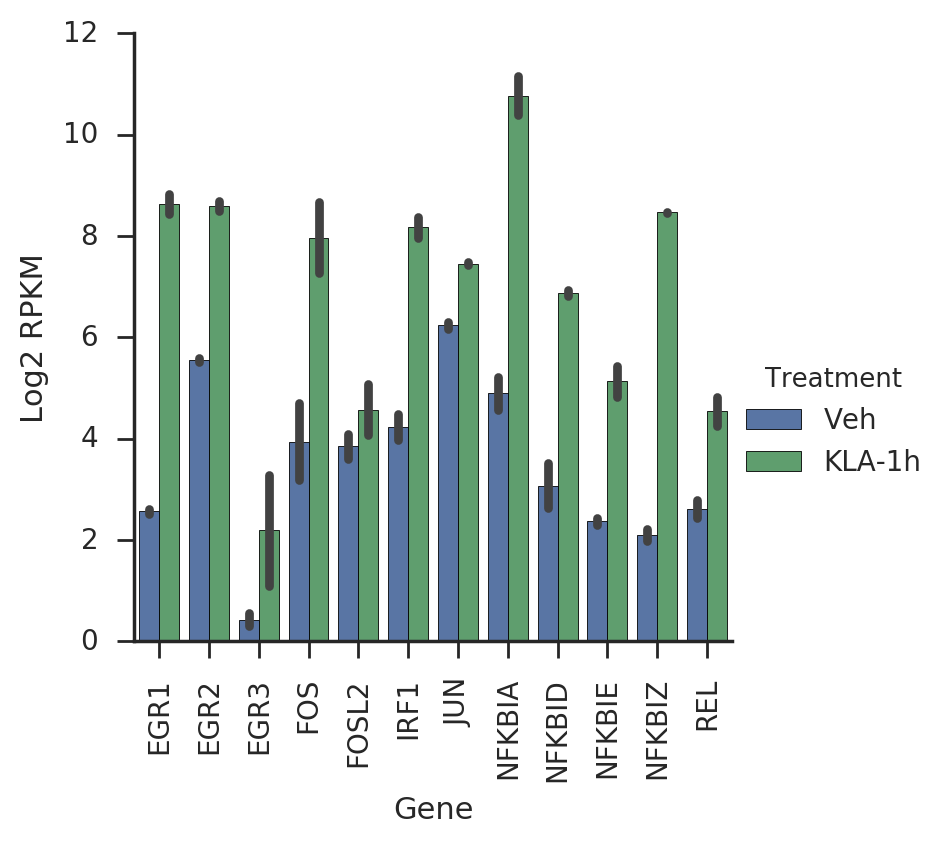

In [1379]:
# gene_list = ['REL', 'EGR1', 'ESR1', 'ESR2', 'RXRA', 'RXRB', 'IRF1', 'IRF7', 'IRF8', 'IRF9']
gene_list = ['EGR1', 
             'REL', 
             'EGR2', 
             'EGR3', 
             'IRF1',
             'FOS', 
             'FOSL2', 
             'JUN',
             'NFKBIA',
             'NFKBID',
             'NFKBIE',
             'NFKBIZ']#, 'RXRA', 'RXRB','PPARG','NR1H2']


plottingFrame = rpkm_plotting_frame[rpkm_plotting_frame['Gene'].isin(gene_list)]

with sns.axes_style('ticks'):
    sns.factorplot(data = plottingFrame, x='Gene', y='Log2 RPKM', hue='Treatment', kind='bar', 
                   order = sorted(gene_list),
                   hue_order=['Veh','KLA-1h'], 
                   ci=100,
                  size=4)

plt.xticks(rotation=90)
plt.savefig('./figures/figure_05_factor_expression.svg', bbox_inches='tight')

### Dimer Analysis in KLA

In [ ]:
plt.figure(figsize=(3.5,14))
atf3_indices = set(summary_frame[summary_frame['c57bl6_atf3_kla'] > 0].index.values)
cjun_indices = set(summary_frame[summary_frame['c57bl6_cjun_kla'] > 0].index.values)
fos_indices = set(summary_frame[summary_frame['c57bl6_fos_kla'] > 0].index.values)
fra2_indices = set(summary_frame[summary_frame['c57bl6_fra2_kla'] > 0].index.values)
junb_indices = set(summary_frame[summary_frame['c57bl6_junb_kla'] > 0].index.values)
jund_indices = set(summary_frame[summary_frame['c57bl6_jund_kla'] > 0].index.values)
plt.subplot(4,1,1)
matplotlib_venn.venn3([atf3_indices, fos_indices, fra2_indices], set_labels=['atf3', 'fos', 'fra2'])
plt.subplot(4,1,2)
matplotlib_venn.venn3([atf3_indices, junb_indices, jund_indices], set_labels=['atf3', 'junb', 'jund'])
plt.subplot(4,1,3)
matplotlib_venn.venn3([cjun_indices, junb_indices, jund_indices], set_labels=['cjun', 'junb', 'jund'])
plt.subplot(4,1,4)
matplotlib_venn.venn3([atf3_indices, cjun_indices, jund_indices], set_labels=['atf3', 'cjun', 'jund'])

# plt.savefig('./figures/figure_02_c_venn_kla.svg')
# plt.savefig('./figures/figure_02_c_venn_kla.png')

In [ ]:
numIterations = 5
test_size = 0.5
background_ratio = 1.0
ap1_members = ['atf3','cjun', 'fos', 'fra2', 'junb','jund']    
factors = ['atf3','cjun', 'fos', 'junb','jund', 'cebpa', 'pu1', 'p65']
ap1_dimers = []
for i in range(len(ap1_members) - 1):
    for j in range(i+1, len(ap1_members)):
        ap1_dimers.append((ap1_members[i], ap1_members[j]))

In [ ]:
# for monomers using motif counts and best motif score 
strain = 'c57bl6'

factor_coeff_dimer_dict = {}
factor_roc_dimer_dict = {}
factor_precision_dimer_dict = {}
factor_score_dimer_dict = {}
factor_testLabel_dimer_dict = {}

for treatment in ['kla']:
    for dimer in ap1_dimers:
        monomer1 = dimer[0]
        monomer2 = dimer[1]
        
        monomer1_indices = summary_frame[summary_frame[strain + '_' + monomer1 + '_' + treatment] > 0.0].index.values
        monomer1_background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == strain + '_' + monomer1 + '_' + treatment + '-background'].index.values
        
        monomer2_indices = summary_frame[summary_frame[strain + '_' + monomer2 + '_' + treatment] > 0.0].index.values
        monomer2_background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == strain + '_' + monomer2 + '_' + treatment + '-background'].index.values
        
        dimer_indices = np.array(list(set(monomer1_indices).intersection(set(monomer2_indices))))
        # select subset of background indices to use
        shuffle(monomer1_background_indices)
        monomer1_background_indices = monomer1_background_indices[:np.ceil(background_ratio*len(dimer_indices)/2)]
        shuffle(monomer2_background_indices)
        monomer2_background_indices = monomer2_background_indices[:np.ceil(background_ratio*len(dimer_indices)/2)]
        
        background_indices = np.concatenate([monomer1_background_indices, monomer2_background_indices])

        target_affinity_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(dimer_indices)]
        background_affinity_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(background_indices)]

        # merge target and background features together 
        affinity_features = pd.concat([target_affinity_features, background_affinity_features])

        labels = pd.Series(data = [True] * len(dimer_indices) + [False] * len(background_indices),
                           index = affinity_features.index.values)
        print(np.sum(labels), len(labels))
                
        results = train_classifier(affinity_features, 
                                    labels,
                                    numIterations = 5,
                                    test_size = test_size,
                                    )
        # unpack result tuples
        all_affinity_rocs = results[0]
        all_affinity_precisions = results[1]
        all_affinity_coefficients = results[2]
        all_affinity_scores = results[3]
        all_affinity_testLabels = results[4]
        
        factor_roc_dimer_dict['_'.join(dimer)] = all_affinity_rocs
        factor_precision_dimer_dict['_'.join(dimer)] = all_affinity_precisions
        factor_coeff_dimer_dict['_'.join(dimer)] = all_affinity_coefficients
        factor_score_dimer_dict['_'.join(dimer)] = all_affinity_scores
        factor_testLabel_dimer_dict['_'.join(dimer)] = all_affinity_testLabels
        
        print('_'.join(dimer) + '_' + treatment,
              'roc:', np.mean(all_affinity_rocs),
              'precision:', np.mean(all_affinity_precisions),
             )

In [ ]:
zscore_coeff_affinity_dimer_frame = calculate_zscore_weights(factor_coeff_dimer_dict,
                                                              all_standardized_score_frame.columns.values)
mean_coeff_affinity_dimer_frame = calculate_mean_weights(factor_coeff_dimer_dict,
                                                              all_standardized_score_frame.columns.values)

In [ ]:
data = pd.concat([mean_coeff_affinity_kla_frame, mean_coeff_affinity_dimer_frame], axis=1)
model = sklearn.decomposition.PCA(n_components=2)

reduced_features = model.fit_transform(data.T)
explained_variance_ratios = model.explained_variance_ratio_

In [ ]:
sns.set_style('white')
# f = plt.figure(figsize=(5,5))
labels = [x.replace('_kla','') for x in data.columns.values]
colors = ['red' if '_' in x else 'blue' for x in labels]
# 1st and 2nd principal component
x_vals = reduced_features[:, 0]
y_vals = reduced_features[:, 1]
plt.scatter(x_vals, y_vals, s=20, c=colors)

for i in range(len(x_vals)):
        x = x_vals[i]
        y = y_vals[i]
        plt.annotate(labels[i], xy=(x,y) , size=10)

plt.xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
plt.xticks([])
plt.ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
plt.yticks([])
ax = plt.gca()
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))

plt.savefig('./figures/figure_05_dimer_weight_pca.svg', bbox_inches='tight')





# Figure 6 - Strains Based Confirmation

### Expression of AP-1 Monomers in Balbc and C57

In [ ]:
%%capture
! analyzeRepeats.pl rna mm10 -count exons -condenseGenes -rpkm -d  ~/analysis/ap1_analysis/tag_directories_rna/C57Bl6_*Veh*UT*/ ~/analysis/ap1_analysis/tag_directories_rna/*KLA-1h*UT*/ /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna/Balbc*/ > rpkm_strains.tsv



In [ ]:
# read in rpkm values
rpkm_strains_frame = pd.read_csv('./rpkm_strains.tsv', sep='\t')

rpkm_strains_frame.index = [x.split('|')[0].upper() for x in rpkm_strains_frame['Annotation/Divergence']]
rpkm_strains_frame = rpkm_strains_frame.ix[:,8:]
rpkm_strains_frame.columns = ['_'.join(x.split('/')[-2].split('_')[0:4]).replace('Thiomac_RNA_','') for x in rpkm_strains_frame.columns.values]

# rotate frame for plotting
rpkm_plotting_frame = pd.DataFrame(rpkm_strains_frame.stack(), 
                                   columns=['RPKM'])
rpkm_plotting_frame['Gene'] = [x[0] for x in rpkm_plotting_frame.index.values]
rpkm_plotting_frame['Genotype'] = [x[1].split('_')[0] for x in rpkm_plotting_frame.index.values]
rpkm_plotting_frame['Treatment'] = [x[1].split('_')[1] for x in rpkm_plotting_frame.index.values]
rpkm_plotting_frame['Log2 RPKM'] = np.log2(rpkm_plotting_frame['RPKM'].values + 1)

In [ ]:
gene_list = ['ATF3', 'FOS', 'JUN', 'JUNB', 'JUND']


plottingFrame = rpkm_plotting_frame[rpkm_plotting_frame['Gene'].isin(gene_list)]

with sns.axes_style('ticks'):
    sns.factorplot(data = plottingFrame, x='Gene', y='Log2 RPKM', hue='Genotype', kind='bar', 
                   order = gene_list,
                   col='Treatment',
                   ci=100,
                   size=3)

plt.xticks(rotation=90)
plt.savefig('./figures/figure_06_strains_monomer_expression.svg', bbox_inches='tight')




### Find Position of SNPs at strain specific sites

### read in sequences

In [ ]:
def read_fasta(file_path):
    '''
    reads in a fasta file and returns a list of sequence ids and a list of sequences
    inputs: filepath - path to a fasta file
    outputs: sequence_list - a list of sequences
             id_list - a list of ids
    '''
    with open(file_path) as f:
        data = f.readlines()
    id_list = []
    sequence_list = []
    # loop through each sequence
    for line in data:
        if '>' in line:
            seq_id = line.strip()[1:]
            id_list.append(seq_id)
        else:
            seq = line.strip()
            sequence_list.append(seq)
    return sequence_list, id_list

In [ ]:
def convert_sequences_to_array(sequences):
    '''
    inputs: sequence of nucleotides represented as a string composed of A, C, G, T
    outputs: a list of numpy array representations of a sequence with:
             A = [1, 0, 0, 0]
             C = [0, 1, 0, 0]
             G = [0, 0, 1, 0]
             T = [0, 0, 0, 1]
             
    '''
    nucleotide_array_dict = {'A': [1, 0, 0, 0],
                             'C': [0, 1, 0, 0],
                             'G': [0, 0, 1, 0],
                             'T': [0, 0, 0, 1],
                             'N': [0, 0, 0, 0]}
    sequence_array_list = []
    for seq in sequences:
        seq_array = []
        for nuc in seq:
            seq_array.append(nucleotide_array_dict[nuc])
        seq_array = np.array(seq_array, dtype=np.int8)
        sequence_array_list.append(seq_array)
    return sequence_array_list

In [ ]:
balbc_sequences, balbc_ids = read_fasta('./peak_sequences/BALBCJ.fa')
c57bl6_sequences, c57bl6_ids = read_fasta('./peak_sequences/C57BL6J.fa')

# convert sequences to arrays
balbc_seq_arrays = convert_sequences_to_array(balbc_sequences)
c57bl6_seq_arrays = convert_sequences_to_array(c57bl6_sequences)

# create pandas series
c57bl6_seq_arrays = pd.Series(c57bl6_seq_arrays, c57bl6_ids)
balbc_seq_arrays = pd.Series(balbc_seq_arrays, balbc_ids)


In [ ]:
id_sequence_balbc_dict = dict(zip(balbc_ids, balbc_sequences))

id_sequence_c57bl6_dict = dict(zip(c57bl6_ids, c57bl6_sequences))

#### Distribution of Tag Counts Strain Comparison

In [ ]:
monomer_list = []
treatment_list = []
type_list = []
tag_list = []
pseudocount = 1
for treatment in ['veh', 'kla']:
    if treatment == 'veh':
        monomers = monomers = ['atf3', 'cjun', 'jund']
    else:
        monomers = monomers = ['atf3', 'cjun', 'fos', 'junb', 'jund']
    for i in range(len(monomers)):
        monomer = monomers[i]
        # find where monomer binds
        monomer_indices= summary_frame[(summary_frame['c57bl6_' + monomer + '_'+ treatment] > 0) |
                                       summary_frame['balbc_' + monomer + '_'+ treatment] > 0].index.values 
        
        balbc_tags = ap1_meanTag_frame.ix[monomer_indices,'balbc_' + monomer + '_' + treatment] + pseudocount
        c57bl6_tags = ap1_meanTag_frame.ix[monomer_indices,'c57bl6_' + monomer + '_' + treatment] + pseudocount
        
        tag_list = tag_list + list(balbc_tags) + list(c57bl6_tags)
        type_list = type_list + ['Balbc'] * len(balbc_tags) + ['C57Bl6'] * len(c57bl6_tags)
        monomer_list = monomer_list + [monomer] * (len(balbc_tags) + len(c57bl6_tags))
        treatment_list = treatment_list + [treatment] * (len(balbc_tags) + len(c57bl6_tags))
        

frame = pd.DataFrame({'Normalized Tags':tag_list,
                      'Log Normalized Tags':np.log2(np.array(tag_list) +1),
                      'Strain':type_list,
                      'Treatment': treatment_list,
                      'Monomer':monomer_list})

sns.factorplot(data = frame,
               kind= 'violin',
               col = 'Treatment',
               hue = 'Strain',
               x = 'Monomer',
               y= 'Log Normalized Tags')

#### Change in Rank After Quantile Normalization

In [ ]:
monomer_list = []
treatment_list = []
strain_list = []
change_list = []

for treatment in ['veh', 'kla']:
#     monomers = ['fos']
    if treatment == 'veh':
        monomers = monomers = ['atf3', 'cjun', 'jund']
    else:
        monomers = monomers = ['atf3', 'cjun', 'fos', 'junb', 'jund']
    for i in range(len(monomers)):
        monomer = monomers[i]
        # find where monomer binds
        monomer_indices= summary_frame[(summary_frame['c57bl6_' + monomer + '_'+ treatment] > 0) |
                                       summary_frame['balbc_' + monomer + '_'+ treatment] > 0].index.values 
        
        balbc_tags = ap1_meanTag_frame.ix[monomer_indices,'balbc_' + monomer + '_' + treatment]
        c57bl6_tags = ap1_meanTag_frame.ix[monomer_indices,'c57bl6_' + monomer + '_' + treatment]
        
        normed_balbc_tags, normed_c57bl6_tags = quantile_normalize(balbc_tags, c57bl6_tags)       
        
        balbc_ranks = scipy.stats.rankdata(balbc_tags, method = 'ordinal')
        c57bl6_ranks = scipy.stats.rankdata(c57bl6_tags, method = 'ordinal')
        
        normed_balbc_ranks = scipy.stats.rankdata(normed_balbc_tags, method = 'ordinal')
        normed_c57bl6_ranks = scipy.stats.rankdata(normed_c57bl6_tags, method = 'ordinal')
        
        balbc_rank_changes = np.abs(balbc_ranks - normed_balbc_ranks)
        c57bl6_rank_changes = np.abs(c57bl6_ranks - normed_c57bl6_ranks)
        
        
        monomer_list = monomer_list + [monomer] * (len(balbc_rank_changes) + len(c57bl6_rank_changes))
        treatment_list = treatment_list + [treatment] * (len(balbc_rank_changes) + len(c57bl6_rank_changes))
        change_list = change_list + list(balbc_rank_changes) + list(c57bl6_rank_changes)
        strain_list = strain_list + ['Balbc'] *len(balbc_rank_changes) + ['C57Bl6'] * len(c57bl6_rank_changes)
sns.factorplot(data = pd.DataFrame({'Rank Change':change_list,
                                    'Strain':strain_list,
                                    'Treatment':treatment_list,
                                    'Monomer':monomer_list}),
               kind='violin',
               x='Monomer',
               y='Rank Change',
               hue='Strain',
               col='Treatment')

#### Fraction of Peaks with a SNP

In [ ]:
monomer_list = []
treatment_list = []
fraction_list = []
positions = range(200)
for treatment in ['veh', 'kla']:
    if treatment == 'veh':
        monomers = monomers = ['atf3', 'cjun', 'jund']
    else:
        monomers = monomers = ['atf3', 'cjun', 'fos', 'junb', 'jund']
    for i in range(len(monomers)):
        monomer = monomers[i]
        # find where monomer binds
        monomer_indices= summary_frame[(summary_frame['c57bl6_' + monomer + '_'+ treatment] > 0) |
                                       summary_frame['balbc_' + monomer + '_'+ treatment] > 0].index.values 
        num_mutated_peaks = 0
        for ind in monomer_indices:
            c57bl6_seq = c57bl6_seq_arrays[ind]
            balbc_seq = balbc_seq_arrays[ind]
            # if sequence lengths are the same
            if c57bl6_seq.shape[0] == balbc_seq.shape[0]:
                has_snp = ((c57bl6_seq + balbc_seq).max(axis=1) == 1)
                snp_positions = [x for x in positions if has_snp[x]]
                if len(snp_positions) > 0:
                    num_mutated_peaks += 1
        mutated_fraction = num_mutated_peaks/len(monomer_indices)
        print(monomer, treatment, mutated_fraction)
        fraction_list.append(mutated_fraction)
        treatment_list.append(treatment)
        monomer_list.append(monomer)
frame = pd.DataFrame({'Mutated Fraction':fraction_list,
                     'Monomer':monomer_list,
                     'Treatment':treatment_list})
sns.factorplot(data = frame, x = 'Monomer', y = 'Mutated Fraction', col = 'Treatment')
    



#### Fraction of Peaks that are Strain Specific after normalization

In [ ]:
monomer_list = []
treatment_list = []
type_list = []
fraction_list = []
threshold = 4
for treatment in ['veh', 'kla']:
    if treatment == 'veh':
        monomers = monomers = ['atf3', 'cjun', 'jund']
    else:
        monomers = monomers = ['atf3', 'cjun', 'fos', 'junb', 'jund']
    for i in range(len(monomers)):
        monomer = monomers[i]
        # find where monomer binds
        monomer_indices= summary_frame[(summary_frame['c57bl6_' + monomer + '_'+ treatment] > 0) |
                                       summary_frame['balbc_' + monomer + '_'+ treatment] > 0].index.values 
        
        balbc_tags = ap1_meanTag_frame.ix[monomer_indices,'balbc_' + monomer + '_' + treatment] + pseudocount
        c57bl6_tags = ap1_meanTag_frame.ix[monomer_indices,'c57bl6_' + monomer + '_' + treatment] + pseudocount
        
        fold_changes = (c57bl6_tags / balbc_tags)

        c57bl6_specific_indices = set(fold_changes[fold_changes >= threshold].index.values)
        balbc_specific_indices = set(fold_changes[fold_changes <= 1/threshold].index.values)
        
        num_peaks = len(monomer_indices)

        balbc_fraction = len(balbc_specific_indices)/num_peaks
        c57bl6_fraction = len(c57bl6_specific_indices)/num_peaks
        
        monomer_list = monomer_list + 2*[monomer]
        treatment_list=treatment_list+2*[treatment]

        fraction_list.append(c57bl6_fraction)
        fraction_list.append(balbc_fraction)
        type_list = type_list + ['balbc', 'c57bl6']
        print(monomer, num_peaks, len(balbc_specific_indices), len(c57bl6_specific_indices))
frame = pd.DataFrame({'Monomer':monomer_list,
                     'Treatment':treatment_list,
                     'Fraction':fraction_list,
                     'Type':type_list})
with sns.axes_style('whitegrid'):
    g=sns.factorplot(data = frame, 
                   x = 'Monomer', 
                   y = 'Fraction',
                   hue='Type',
                   palette='Set1',
                   col = 'Treatment',
                   size=3)
    g.set_xticklabels(rotation=90)
    plt.ylim(0,0.1)
                                
    


#### Fraction of Peaks that are Strain Specific

In [ ]:
monomer_list = []
treatment_list = []
type_list = []
fraction_list = []
threshold = 4
for treatment in ['veh', 'kla']:
    if treatment == 'veh':
        monomers = monomers = ['atf3', 'cjun', 'jund']
    else:
        monomers = monomers = ['atf3', 'cjun', 'fos', 'junb', 'jund']
    for i in range(len(monomers)):
        monomer = monomers[i]
        # find where monomer binds
        monomer_indices= summary_frame[(summary_frame['c57bl6_' + monomer + '_'+ treatment] > 0) |
                                       summary_frame['balbc_' + monomer + '_'+ treatment] > 0].index.values 
        
        balbc_tags = ap1_meanTag_frame.ix[monomer_indices,'balbc_' + monomer + '_' + treatment]
        c57bl6_tags = ap1_meanTag_frame.ix[monomer_indices,'c57bl6_' + monomer + '_' + treatment]
        
        normed_balbc_tags, normed_c57bl6_tags = quantile_normalize(balbc_tags, c57bl6_tags)  
        
        fold_changes = (normed_c57bl6_tags + pseudocount) / (normed_balbc_tags + pseudocount)
        fold_changes = pd.Series(fold_changes, index = monomer_indices)
        
        c57bl6_specific_indices = set(fold_changes[fold_changes >= threshold].index.values)
        balbc_specific_indices = set(fold_changes[fold_changes <= 1/threshold].index.values)
        
        num_peaks = len(monomer_indices)

        balbc_fraction = len(balbc_specific_indices)/num_peaks
        c57bl6_fraction = len(c57bl6_specific_indices)/num_peaks
        
        monomer_list = monomer_list + 2*[monomer]
        treatment_list=treatment_list+2*[treatment]

        fraction_list.append(c57bl6_fraction)
        fraction_list.append(balbc_fraction)
        type_list = type_list + ['balbc', 'c57bl6']
        print(monomer, num_peaks, len(balbc_specific_indices), len(c57bl6_specific_indices))
frame = pd.DataFrame({'Monomer':monomer_list,
                     'Treatment':treatment_list,
                     'Fraction':fraction_list,
                     'Type':type_list})
with sns.axes_style('whitegrid'):
    g=sns.factorplot(data = frame, 
                   x = 'Monomer', 
                   y = 'Fraction',
                   hue='Type',
                   palette='Set1',
                   col = 'Treatment',
                   size=3)
    g.set_xticklabels(rotation=90)
    plt.ylim(0,0.1)
    plt.savefig('./figures/figure_07_strain_specfic_fraction.svg', bbox_inches='tight')

                  
    


#### Fraction of Strain Specific Peaks that have a SNP

In [ ]:
monomer_list = []
treatment_list = []
fraction_list = []
pseudocount = 1
threshold = 4
for treatment in ['veh', 'kla']:
    if treatment == 'veh':
        monomers = monomers = ['atf3', 'cjun', 'jund']
    else:
        monomers = monomers = ['atf3', 'cjun', 'fos', 'junb', 'jund']
    for i in range(len(monomers)):
        monomer = monomers[i]
        # find where monomer binds
        monomer_indices= summary_frame[(summary_frame['c57bl6_' + monomer + '_'+ treatment] > 0) |
                                       summary_frame['balbc_' + monomer + '_'+ treatment] > 0].index.values 
        
        balbc_tags = ap1_meanTag_frame.ix[monomer_indices,'balbc_' + monomer + '_' + treatment] 
        c57bl6_tags = ap1_meanTag_frame.ix[monomer_indices,'c57bl6_' + monomer + '_' + treatment]
        
        normed_balbc_tags, normed_c57bl6_tags = quantile_normalize(balbc_tags, c57bl6_tags)  
        
        fold_changes = (normed_c57bl6_tags + pseudocount) / (normed_balbc_tags + pseudocount)
        fold_changes = pd.Series(fold_changes, index = monomer_indices)
        
        c57bl6_specific_indices = set(fold_changes[fold_changes >= threshold].index.values)
        balbc_specific_indices = set(fold_changes[fold_changes <= 1/threshold].index.values)
        
        strain_specific_indices = c57bl6_specific_indices.union(balbc_specific_indices)
        num_mutated_peaks = 0
        num_peaks = 0
        for ind in strain_specific_indices:
            c57bl6_seq = c57bl6_seq_arrays[ind]
            balbc_seq = balbc_seq_arrays[ind]
            # if sequence lengths are the same
            if c57bl6_seq.shape[0] == balbc_seq.shape[0]:
                num_peaks +=1
                has_snp = ((c57bl6_seq + balbc_seq).max(axis=1) == 1)
                if np.sum(has_snp) > 0:
                    num_mutated_peaks += 1
        mutated_fraction = num_mutated_peaks/num_peaks
        print(monomer, treatment, mutated_fraction, num_mutated_peaks)
        fraction_list.append(mutated_fraction)
        treatment_list.append(treatment)
        monomer_list.append(monomer)
frame = pd.DataFrame({'Mutated Fraction':fraction_list,
                     'Monomer':monomer_list,
                     'Treatment':treatment_list})
sns.factorplot(data = frame, x = 'Monomer', y = 'Mutated Fraction', col = 'Treatment')
    




#### Fraction of Strain Specific Peaks Excluded due to Length Differences

In [ ]:
threshold = 4.0
monomer_list = []
treatment_list = []
type_list = []
fraction_list = []
for treatment in ['veh', 'kla']:
    if treatment == 'veh':
        monomers = monomers = ['atf3', 'cjun', 'jund']
    else:
        monomers = monomers = ['atf3', 'cjun', 'fos', 'junb', 'jund']
    for i in range(len(monomers)):
        monomer = monomers[i]
        # find where monomer binds
        monomer_indices= summary_frame[(summary_frame['c57bl6_' + monomer + '_'+ treatment] > 0) |
                                      (summary_frame['balbc_' + monomer + '_'+ treatment] > 0)].index.values 
        
        balbc_tags = ap1_meanTag_frame.ix[monomer_indices,'balbc_' + monomer + '_' + treatment] + pseudocount
        c57bl6_tags = ap1_meanTag_frame.ix[monomer_indices,'c57bl6_' + monomer + '_' + treatment] + pseudocount

        normed_balbc_tags, normed_c57bl6_tags = quantile_normalize(balbc_tags, c57bl6_tags)  
        
        fold_changes = (normed_c57bl6_tags / normed_balbc_tags)
        fold_changes = pd.Series(fold_changes, index = monomer_indices)
        
        c57bl6_specific_indices = set(fold_changes[fold_changes >= threshold].index.values)
        balbc_specific_indices = set(fold_changes[fold_changes <= 1/threshold].index.values)
        
        num_peaks = len(monomer_indices)
        
        different_length_indices = []
        for ind in monomer_indices:
            c_seq = id_sequence_c57bl6_dict[ind]
            b_seq = id_sequence_balbc_dict[ind]
            if not len(c_seq) == len(b_seq):
                different_length_indices.append(ind)
        different_length_indices = set(different_length_indices)
        
        num_differences = len(different_length_indices)
        balbc_fraction = len(balbc_specific_indices.intersection(different_length_indices))/len(balbc_specific_indices)
        c57bl6_fraction = len(c57bl6_specific_indices.intersection(different_length_indices))/len(c57bl6_specific_indices)
        overall_fraction = len(different_length_indices)/len(monomer_indices)
        
        monomer_list = monomer_list + 3*[monomer]
        treatment_list=treatment_list+3*[treatment]
        fraction_list.append(balbc_fraction)
        fraction_list.append(c57bl6_fraction)
        fraction_list.append(overall_fraction)
        type_list = type_list + ['balbc', 'c57bl6', 'overall']
frame = pd.DataFrame({'Monomer':monomer_list,
                     'Treatment':treatment_list,
                     'Fraction':fraction_list,
                     'Type':type_list})
with sns.axes_style('whitegrid'):
    sns.factorplot(data = frame, 
                   x = 'Monomer', 
                   y = 'Fraction',
                   hue='Type',
                   col='Treatment',
                   palette='Set1')
    plt.ylim(0,1)
    

#### Number of Peaks with an AP-1 Motif

In [ ]:

monomer_frequencies_dict = {} # {motif:frequency_array}
positions = range(200)
thresholds = [3,4,5,6,7,8,9,10]
monomer_list = []
treatment_list = []
threshold_list = []
fraction_list = []
for treatment in ['veh', 'kla']:
    if treatment == 'veh':
        monomers = monomers = ['atf3', 'cjun', 'jund']
    else:
        monomers = monomers = ['atf3', 'cjun', 'fos', 'fra2', 'junb', 'jund']
    for i in range(len(monomers)):
        monomer = monomers[i]
        # find where monomer binds
        monomer_indices= summary_frame[summary_frame['c57bl6_' + monomer + '_'+ treatment] > 0].index.values 
        num_peaks = len(monomer_indices)
        for threshold in thresholds:
            num_motifs = np.sum(motif_score_frame.ix[monomer_indices,'ap-1'] >= threshold)


            monomer_list.append(monomer)
            treatment_list.append(treatment)
            threshold_list.append(threshold)
            fraction_list.append(num_motifs/num_peaks)
    

frame = pd.DataFrame({'Monomer':monomer_list,
         'Treatment':treatment_list,
         'Threshold':threshold_list,
         'Fraction':fraction_list})
with sns.axes_style('whitegrid'):
    sns.factorplot(data = frame, 
                   x = 'Monomer', 
                   y = 'Fraction', 
                   hue = 'Threshold', 
                   col='Treatment',
                   palette='Blues')

### Plot Position of SNPs relative to AP-1 Motif

In [ ]:
def get_snp_distances(indices, motif, motif_size, score_threshold):
    distances = []
    num_peaks = 0
    for ind in indices:
        motif_score = motif_score_frame.ix[ind, motif]
        if motif_score >= score_threshold:
            
            motif_pos = motif_start_frame.ix[ind, motif]
            motif_strand = motif_strand_frame.ix[ind, motif]
            if motif_strand == '+':
                motif_start = motif_pos
                motif_end = motif_pos + motif_size
            else:
                motif_start = motif_pos - motif_size
                motif_end = motif_pos

            motif_strand = motif_strand_frame.ix[ind, motif]
            c57bl6_seq = c57bl6_seq_arrays[ind]
            balbc_seq = balbc_seq_arrays[ind]
            # if sequence lengths are the same
            if c57bl6_seq.shape[0] == balbc_seq.shape[0]:
                has_snp = ((c57bl6_seq + balbc_seq).max(axis=1) == 1)
                snp_positions = [x for x in positions if has_snp[x] and (x> motif_end or x < motif_start)]
                if len(snp_positions) > 0:
                    num_peaks +=1
                    snp_distances = [abs(x - motif_pos) for x in snp_positions]

                    distances = distances + snp_distances
    distances_counter = Counter(distances)
    num_snps= np.sum(distances)
    frequencies = [distances_counter[x]/num_peaks if x in distances_counter else 0 for x in positions]
    frequencies = np.array(frequencies)
    return frequencies, distances


In [ ]:
pseudocount = 1
fold_threshold = 4.0
score_threshold = 5.0
motif = 'ap-1'
motif_size = 7
max_dist = 100
positions = range(max_dist)
linewidth = 1
max_height = 0.1
palette = sns.color_palette("Set1")
for treatment in ['veh', 'kla']:
    if treatment == 'veh':
        monomers = monomers = ['atf3', 'cjun', 'jund']
    else:
        monomers = monomers = ['atf3', 'cjun', 'fos', 'junb', 'jund']
    for i in range(len(monomers)):
        monomer = monomers[i]
        ### find where monomer binds ###
        monomer_indices= summary_frame[(summary_frame['c57bl6_' + monomer + '_'+ treatment] > 0) |
                                      (summary_frame['balbc_' + monomer + '_'+ treatment] > 0)].index.values 
        
        ### find strain specific peaks ###
        balbc_tags = ap1_meanTag_frame.ix[monomer_indices,'balbc_' + monomer + '_' + treatment]
        c57bl6_tags = ap1_meanTag_frame.ix[monomer_indices,'c57bl6_' + monomer + '_' + treatment]

        normed_balbc_tags, normed_c57bl6_tags = quantile_normalize(balbc_tags, c57bl6_tags)  
        
        fold_changes = (normed_c57bl6_tags + pseudocount) / (normed_balbc_tags + pseudocount)
        fold_changes = pd.Series(fold_changes, index = monomer_indices)
        
        c57bl6_specific_indices = set(fold_changes[fold_changes >= fold_threshold].index.values)
        balbc_specific_indices = set(fold_changes[fold_changes <= 1/fold_threshold].index.values)
        non_specific_indices = set(monomer_indices) - c57bl6_specific_indices - balbc_specific_indices
        ### find SNP positions ###
        c57bl6_specific_snp_frequencies, c57bl6_specific_snp_distances = get_snp_distances(c57bl6_specific_indices, motif, motif_size, score_threshold)
        balbc_specific_snp_frequencies, balbc_specific_snp_distances = get_snp_distances(balbc_specific_indices, motif, motif_size, score_threshold)
        non_specific_snp_frequencies, non_specific_snp_distances = get_snp_distances(non_specific_indices, motif, motif_size, score_threshold)
        
#         c57bl6_enrichments = (c57bl6_specific_snp_frequencies + 0.0001) / (non_specific_snp_frequencies + 0.0001)
#         balbc_enrichments = (balbc_specific_snp_frequencies +0.0001) / (non_specific_snp_frequencies + 0.0001)
        c57bl6_differences = c57bl6_specific_snp_frequencies - non_specific_snp_frequencies 
        balbc_differences = balbc_specific_snp_frequencies - non_specific_snp_frequencies 
        print(monomer, treatment)
        with sns.axes_style('whitegrid'):
            plt.figure(figsize=(4,6))
            plt.subplot(211)
            plt.plot(positions, 
                     c57bl6_specific_snp_frequencies, 
                     linewidth=linewidth,
                     label = 'C57Bl6 Specific (' + str(len(c57bl6_specific_indices)) + ')', 
                     c=palette[0])
            plt.plot(positions, 
                     balbc_specific_snp_frequencies, 
                     linewidth=linewidth,
                     label = 'Balbc Specific (' + str(len(balbc_specific_indices)) + ')', 
                     c=palette[1])
            plt.plot(positions, 
                     non_specific_snp_frequencies, 
                     linewidth=linewidth,
                     label = 'Non Specific (' + str(len(non_specific_indices)) + ')', 
                     c='black')
            plt.legend()
#             plt.xlabel('Distance from AP-1 Motif')
            plt.ylabel('Normalized Frequency')
            plt.ylim(0,max_height)
            plt.xlim(0,max_dist)

            
            plt.subplot(212)
            plt.plot(positions, c57bl6_differences, 
                     linewidth=linewidth,
                        label = 'C57Bl6 Specific (' + str(len(c57bl6_specific_indices)) + ')', c=palette[0])
            plt.plot(positions, balbc_differences, 
                     linewidth=linewidth,
                        label = 'Balbc Specific (' + str(len(balbc_specific_indices)) + ')', c=palette[1])
            plt.legend()
            plt.xlabel('Distance from AP-1 Motif')
            plt.ylabel('Normalized Difference')
            plt.ylim(0,max_height/2)
            plt.xlim(0,max_dist)
            
            plt.suptitle(monomer + ' ' + treatment)
            plt.savefig('./figures/figure_07_motif_distance_'+monomer+'_'+treatment+'.png', bbox_inches='tight')
            plt.show()


### Calculate DeltaSVM Style Scores

In [ ]:
differences_frame = all_standardized_score_frame - all_standardized_score_balbc_frame

In [ ]:
mean_coeff_affinity_frame = calculate_mean_weights(factor_coeff_dict,
                                  all_standardized_score_frame.columns.values)


mean_coeff_affinity_veh_frame = mean_coeff_affinity_frame[['atf3_veh', 'cjun_veh', 'jund_veh']]
mean_coeff_affinity_kla_frame = mean_coeff_affinity_frame[['atf3_kla', 'cjun_kla', 'fos_kla','junb_kla', 'jund_kla']]

In [ ]:
veh_factor_treatments = ['atf3_veh', 'cjun_veh', 'jund_veh']
kla_factor_treatments = ['atf3_kla', 'cjun_kla', 'fos_kla','junb_kla', 'jund_kla']
strain1 = 'c57bl6'
strain2 = 'balbc'

selected_motifs = differences_frame.columns.values

for factor_treatment in veh_factor_treatments + kla_factor_treatments:
    strain1_indices = summary_frame[summary_frame[strain1+ '_' + factor_treatment] > 0].index.values
    strain2_indices = summary_frame[summary_frame[strain2+ '_' + factor_treatment] > 0].index.values
    factor_treatment_indices = sorted(set(strain1_indices).union(set(strain2_indices)))
    current_differences = differences_frame.ix[factor_treatment_indices,selected_motifs]
    current_weights = mean_coeff_affinity_frame[factor_treatment]

    products = current_weights * current_differences
    scores = products.sum(axis=1)

In [ ]:
pseudocount = 1
threshold = 4
for treatment in ['veh', 'kla']:
    if treatment == 'veh':
        monomers = monomers = ['atf3', 'cjun', 'jund']
    else:
        monomers = monomers = ['atf3', 'cjun', 'fos', 'junb', 'jund']
    for i in range(len(monomers)):
        monomer = monomers[i]
        # find where monomer binds
        monomer_indices= summary_frame[(summary_frame['c57bl6_' + monomer + '_'+ treatment] > 0) |
                                       summary_frame['balbc_' + monomer + '_'+ treatment] > 0].index.values 
        
        balbc_tags = ap1_meanTag_frame.ix[monomer_indices,'balbc_' + monomer + '_' + treatment] 
        c57bl6_tags = ap1_meanTag_frame.ix[monomer_indices,'c57bl6_' + monomer + '_' + treatment]
        
        normed_balbc_tags, normed_c57bl6_tags = quantile_normalize(balbc_tags, c57bl6_tags)  
        
        fold_changes = (normed_c57bl6_tags + pseudocount) / (normed_balbc_tags + pseudocount)
        fold_changes = pd.Series(fold_changes, index = monomer_indices)
        
        c57bl6_specific_indices = set(fold_changes[fold_changes >= threshold].index.values)
        balbc_specific_indices = set(fold_changes[fold_changes <= 1/threshold].index.values)
        
        strain_specific_indices = sorted(c57bl6_specific_indices.union(balbc_specific_indices))
        current_differences = differences_frame.ix[factor_treatment_indices,:]
        
        num_mutated_peaks = 0
        num_peaks = 0
        mutated_strain_specific_indices = []
        for ind in strain_specific_indices:
            c57bl6_seq = c57bl6_seq_arrays[ind]
            balbc_seq = balbc_seq_arrays[ind]
            # if sequence lengths are the same
            if c57bl6_seq.shape[0] == balbc_seq.shape[0]:
                num_peaks +=1
                has_snp = ((c57bl6_seq + balbc_seq).max(axis=1) == 1)
                if np.sum(has_snp) > 0:
                    mutated_strain_specific_indices.append(ind)
                    num_mutated_peaks += 1
        current_weights = mean_coeff_affinity_frame[monomer + '_' + treatment]
        current_differences = differences_frame.ix[mutated_strain_specific_indices,:]
        products = current_weights * current_differences
        scores = products.sum(axis=1)
        current_fold_changes = fold_changes[mutated_strain_specific_indices]
        pearson, pval = scipy.stats.pearsonr(scores, np.log2(current_fold_changes))
        print(monomer, treatment, pearson)
        plt.figure(figsize=(2,2))
        plt.scatter(scores, np.log2(current_fold_changes), 
                    edgecolor='None', 
                    s=1,
                    c='red')
        plt.annotate(xy=(-5.5,4.5),s='PCC='+str(round(pearson,3)),size=8)
        plt.xlim(-6,6)
        plt.ylim(-6,6)
        plt.title(' '.join([monomer, treatment]))
        plt.xlabel('Score Change')
        plt.ylabel('Fold Change')
        plt.savefig('./figures/figure_06_predictions_'+monomer+'_'+treatment+'.png', bbox_inches='tight')
        plt.savefig('./figures/figure_06_predictions_'+monomer+'_'+treatment+'.pdf', bbox_inches='tight')

        plt.show()

                    
    

In [ ]:
pseudocount = 1
threshold = 4
factor_list = []
treatment_list = []
correlation_list = []
model_list = []
num_motifs = 50
for treatment in ['veh', 'kla']:
    if treatment == 'veh':
        monomers = ['atf3', 'cjun', 'jund']
    else:
        monomers = ['atf3', 'cjun', 'fos', 'junb', 'jund']
    for i in range(len(monomers)):
        monomer = monomers[i]
        
        # determine top motifs
        current_weights = mean_coeff_affinity_frame[monomer + '_' + treatment]
        abs_weights = current_weights.abs()
        abs_weights.sort(ascending=False)
        sorted_motifs = list(abs_weights.index.values)
        motifs_to_use = sorted_motifs[:num_motifs]
        
        print(len(motifs_to_use))
        # find where monomer binds
        monomer_indices= summary_frame[(summary_frame['c57bl6_' + monomer + '_'+ treatment] > 0) |
                                       summary_frame['balbc_' + monomer + '_'+ treatment] > 0].index.values 
        
        balbc_tags = ap1_meanTag_frame.ix[monomer_indices,'balbc_' + monomer + '_' + treatment] 
        c57bl6_tags = ap1_meanTag_frame.ix[monomer_indices,'c57bl6_' + monomer + '_' + treatment]
        
        normed_balbc_tags, normed_c57bl6_tags = quantile_normalize(balbc_tags, c57bl6_tags)  
        
        fold_changes = (normed_c57bl6_tags + pseudocount) / (normed_balbc_tags + pseudocount)
        fold_changes = pd.Series(fold_changes, index = monomer_indices)
        
        c57bl6_specific_indices = set(fold_changes[fold_changes >= threshold].index.values)
        balbc_specific_indices = set(fold_changes[fold_changes <= 1/threshold].index.values)
        
        strain_specific_indices = sorted(c57bl6_specific_indices.union(balbc_specific_indices))
        current_differences = differences_frame.ix[factor_treatment_indices,:]
        
        num_mutated_peaks = 0
        num_peaks = 0
        mutated_strain_specific_indices = []
        for ind in strain_specific_indices:
            c57bl6_seq = c57bl6_seq_arrays[ind]
            balbc_seq = balbc_seq_arrays[ind]
            # if sequence lengths are the same
            if c57bl6_seq.shape[0] == balbc_seq.shape[0]:
                num_peaks +=1
                has_snp = ((c57bl6_seq + balbc_seq).max(axis=1) == 1)
                if np.sum(has_snp) > 0:
                    mutated_strain_specific_indices.append(ind)
                    num_mutated_peaks += 1
        current_weights = mean_coeff_affinity_frame[monomer + '_' + treatment]
        current_differences = differences_frame.ix[mutated_strain_specific_indices,motifs_to_use]
        products = current_weights * current_differences
        scores = products.sum(axis=1)
        
        ap1_weights = mean_coeff_affinity_frame.ix[['ap-1','atf7_batf3_creb5'], monomer + '_' + treatment]
        ap1_differences = differences_frame.ix[mutated_strain_specific_indices,['ap-1','atf7_batf3_creb5']]
        ap1_products = ap1_weights * ap1_differences
        ap1_scores = ap1_products.sum(axis=1)
        
        ap1_motif_differences = differences_frame.ix[mutated_strain_specific_indices,['ap-1']]
        ap1_motif_scores = ap1_motif_differences.sum(axis=1)
        
        current_fold_changes = fold_changes[mutated_strain_specific_indices]
        
        pearson, pval = scipy.stats.pearsonr(scores, np.log2(current_fold_changes))
        ap1_pearson, pval = scipy.stats.pearsonr(ap1_scores, np.log2(current_fold_changes))
        ap1_motif_pearson, pval = scipy.stats.pearsonr(ap1_motif_scores, np.log2(current_fold_changes))
        
        print(monomer, treatment, pearson, ap1_pearson)
        factor_list = factor_list + 2*[monomer]
        treatment_list = treatment_list + 2*[treatment]
        correlation_list.append(pearson)
        correlation_list.append(ap1_motif_pearson)
        model_list = model_list + ['Top 50 Motifs Model', 'AP-1 Motif Score']
        
frame = pd.DataFrame({'Monomer':factor_list,
                      'Treatment':treatment_list,
                      'Model Correlation':correlation_list,
                      'Model Type':model_list})
# plt.figure(figsize=(3,3))
sns.factorplot(data = frame[frame['Treatment']=='kla'], 
               col = 'Treatment', 
               x = 'Monomer', 
               hue = 'Model Type',
               y ='Model Correlation', 
               kind='bar')
plt.savefig('./figures/figure_06_model_correlation_with_strain_specific_binding_kla.svg',bbox_inches='tight')           


sns.factorplot(data = frame[frame['Treatment']=='veh'], 
               col = 'Treatment', 
               x = 'Monomer', 
               hue = 'Model Type',
               y ='Model Correlation', 
               kind='bar')
plt.savefig('./figures/figure_06_model_correlation_with_strain_specific_binding_veh.svg',bbox_inches='tight')           
    

In [ ]:
factor_pearson_dict = {}
ap1_pearson_dict = {}
num_motifs = 100
threshold = 4
for treatment in ['veh', 'kla']:
    if treatment == 'veh':
        monomers = ['atf3', 'cjun', 'jund']
    else:
        monomers = ['atf3', 'cjun', 'fos', 'junb', 'jund']
    for i in range(len(monomers)):
        monomer = monomers[i]
        
        factor_pearson_dict[monomer + '_' + treatment] = []
        current_weights = mean_coeff_affinity_frame[monomer + '_' + treatment]
        abs_weights = current_weights.abs()
        abs_weights.sort(ascending=False)
        sorted_motifs = list(abs_weights.index.values)
        
        # find where monomer binds
        monomer_indices= summary_frame[(summary_frame['c57bl6_' + monomer + '_'+ treatment] > 0) |
                                       summary_frame['balbc_' + monomer + '_'+ treatment] > 0].index.values 
        
        balbc_tags = ap1_meanTag_frame.ix[monomer_indices,'balbc_' + monomer + '_' + treatment] 
        c57bl6_tags = ap1_meanTag_frame.ix[monomer_indices,'c57bl6_' + monomer + '_' + treatment]
        
        # normalize tags
        normed_balbc_tags, normed_c57bl6_tags = quantile_normalize(balbc_tags, c57bl6_tags)  
        
        # calculate strain specific binding
        fold_changes = (normed_c57bl6_tags + pseudocount) / (normed_balbc_tags + pseudocount)
        fold_changes = pd.Series(fold_changes, index = monomer_indices)
        
        c57bl6_specific_indices = set(fold_changes[fold_changes >= threshold].index.values)
        balbc_specific_indices = set(fold_changes[fold_changes <= 1/threshold].index.values)
        
        strain_specific_indices = sorted(c57bl6_specific_indices.union(balbc_specific_indices))
        current_differences = differences_frame.ix[factor_treatment_indices,:]
        
        # filter strain specific peaks according to whether or not there is a SNP
        num_mutated_peaks = 0
        num_peaks = 0
        mutated_strain_specific_indices = []
        for ind in strain_specific_indices:
            c57bl6_seq = c57bl6_seq_arrays[ind]
            balbc_seq = balbc_seq_arrays[ind]
            # if sequence lengths are the same
            if c57bl6_seq.shape[0] == balbc_seq.shape[0]:
                num_peaks +=1
                has_snp = ((c57bl6_seq + balbc_seq).max(axis=1) == 1)
                if np.sum(has_snp) > 0:
                    mutated_strain_specific_indices.append(ind)
                    num_mutated_peaks += 1
#         mutated_strain_specific_indices = strain_specific_indices    
        current_fold_changes = fold_changes[mutated_strain_specific_indices]
        
        # calculate correlation to AP-1 binding
        ap1_motif_differences = motif_score_differences_frame.ix[mutated_strain_specific_indices,['ap-1']]
        ap1_motif_scores = ap1_motif_differences.sum(axis=1)
        ap1_pearson, pval = scipy.stats.pearsonr(ap1_motif_scores, np.log2(current_fold_changes))
        ap1_pearson_dict[monomer + '_' + treatment] = ap1_pearson
        
        # threshold on number of motifs
        for i in range(num_motifs):
            motifs_to_use = sorted_motifs[i:]
#             motifs_to_use = sorted_motifs[:i+1]
            current_differences = differences_frame.ix[mutated_strain_specific_indices,motifs_to_use]
            products = current_weights * current_differences
            scores = products.sum(axis=1)

            pearson, pval = scipy.stats.pearsonr(scores, np.log2(current_fold_changes))
            factor_pearson_dict[monomer + '_' + treatment].append(pearson)
            print(monomer, treatment, len(motifs_to_use), num_mutated_peaks, ap1_pearson, pearson )

In [ ]:
correlation_frame = pd.DataFrame(factor_pearson_dict)
correlation_plotting_frame = pd.DataFrame(correlation_frame.stack(), columns=['PCC'])
correlation_plotting_frame['Monomer'] = [x[1] for x in correlation_plotting_frame.index.values]
correlation_plotting_frame['Motifs Removed'] = [x[0] for x in correlation_plotting_frame.index.values]

In [ ]:
palette = sns.color_palette("Set1")

with sns.axes_style('ticks'):
    for treatment in ['veh', 'kla']:
        plt.figure(figsize=(3,3))
        if treatment == 'veh':
            members = ['atf3', 'cjun', 'jund']
        else:
            members = ['atf3', 'cjun', 'fos', 'junb', 'jund']
        for i in range(len(members)):
            monomer = members[i]
            c = palette[i]
    

            sns.regplot(data =correlation_plotting_frame[correlation_plotting_frame['Monomer'].str.contains(monomer + '_' + treatment)],
                        x = 'Motifs Removed',
                        y = 'PCC',
                        color = c,
                        ci = False,
                        order = 3,
                        truncate = True,
                        scatter_kws = {'s':5,
                                       'alpha':0.5},
                        line_kws = {'linewidth':1.5},
                        label = monomer + '_' + treatment
                        )
        plt.ylabel('PCC with Strain Specific Binding')
        sns.despine()
        plt.xlim(-1,100)
        plt.ylim(0,0.7)
        plt.legend()
        plt.savefig('./figures/figure_06_numMotifsRemoved_vs_strain_specific_binding_'+treatment+'.svg', bbox_inches='tight')
        plt.savefig('./figures/figure_06_numMotifsRemoved_vs_strain_specific_binding_'+treatment+'.png', bbox_inches='tight')



In [ ]:
with sns.axes_style('ticks'):
    for treatment in ['veh', 'kla']:
        plt.figure(figsize=(3,3))
        if treatment == 'veh':
            members = ['atf3', 'cjun', 'jund']
        else:
            members = ['atf3', 'cjun', 'fos', 'junb', 'jund']
        for monomer in members:
            key = monomer + '_' + treatment
            pccs = [x for x in factor_pearson_dict[key]]
            plt.plot(range(len(pccs)), pccs, label = key)
#             plt.axhline(y=ap1_pearson_dict[key])
        plt.xlabel('Motifs Removed from Model')
        plt.ylabel('PCC')
        plt.xlim(-1,150)
#         plt.ylim(0.0,0.7)
        # Fix axes
        ax = plt.gca()
        x0,x1 = ax.get_xlim()
        y0,y1 = ax.get_ylim()
        ax.set_aspect(abs(x1-x0)/abs(y1-y0))
        plt.legend(loc='upper right')
        sns.despine()
        plt.show()
    
    

### Test Each Motif

In [ ]:
motif_score_differences_frame = motif_score_frame.ix[:,3:] - motif_score_balbc_frame.ix[:,3:]
motif_score_differences_frame = motif_score_differences_frame.drop('pparg_rxra', axis=1)
motif_score_differences_frame = motif_score_differences_frame.drop('pparg', axis=1)

In [ ]:
threshold = 0.5
factor_pvals_dict = {}
for treatment in ['veh', 'kla']:
    if treatment == 'veh':
        monomers = ['atf3', 'cjun', 'jund']
    else:
        monomers = ['atf3', 'cjun', 'fos', 'junb', 'jund']
    for i in range(len(monomers)):
        monomer = monomers[i]
        # find where monomer binds
        monomer_indices= summary_frame[(summary_frame['c57bl6_' + monomer + '_'+ treatment] > 0) |
                                       summary_frame['balbc_' + monomer + '_'+ treatment] > 0].index.values 
        mutated_indices = []
        for ind in monomer_indices:
            c57bl6_seq = c57bl6_seq_arrays[ind]
            balbc_seq = balbc_seq_arrays[ind]
            # if sequence lengths are the same
            if c57bl6_seq.shape[0] == balbc_seq.shape[0]:
                has_snp = ((c57bl6_seq + balbc_seq).max(axis=1) == 1)
                if np.sum(has_snp) > 0:
                    mutated_indices.append(ind)

        
        balbc_tags = ap1_meanTag_frame.ix[mutated_indices,'balbc_' + monomer + '_' + treatment] 
        c57bl6_tags = ap1_meanTag_frame.ix[mutated_indices,'c57bl6_' + monomer + '_' + treatment]
        
        normed_balbc_tags, normed_c57bl6_tags = quantile_normalize(balbc_tags, c57bl6_tags)  
        
        fold_changes = (normed_c57bl6_tags + pseudocount) / (normed_balbc_tags + pseudocount)
        fold_changes = pd.Series(fold_changes, index = mutated_indices)
        log_fold_changes = np.log2(fold_changes)
        pvals = []
        for motif in motif_score_differences_frame.columns.values:
            current_score_differences = motif_score_differences_frame.ix[mutated_indices,motif]

            predicted_increase_indices = current_score_differences[current_score_differences>=threshold].index.values
            predicted_decrease_indices = current_score_differences[current_score_differences<=-1*threshold].index.values
            
            grouped_fold_changes = [fold_changes[predicted_increase_indices],
                                    fold_changes[predicted_decrease_indices]
                                   ]
            grouped_log_fold_changes = [log_fold_changes[predicted_increase_indices],
                                        log_fold_changes[predicted_decrease_indices]
                                       ]
            
            if len(predicted_increase_indices) > 1 and len(predicted_decrease_indices) > 1:
                stat, increase_vs_decrease = scipy.stats.ttest_ind(grouped_log_fold_changes[0], 
                                                                   grouped_log_fold_changes[1])
            else:
                increase_vs_decrease = 1.0
            pvals.append(increase_vs_decrease)
        factor_pvals_dict[monomer + '_' + treatment] = pvals

factor_pvals_frame = pd.DataFrame(factor_pvals_dict,
                                 index = motif_score_differences_frame.columns.values)

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


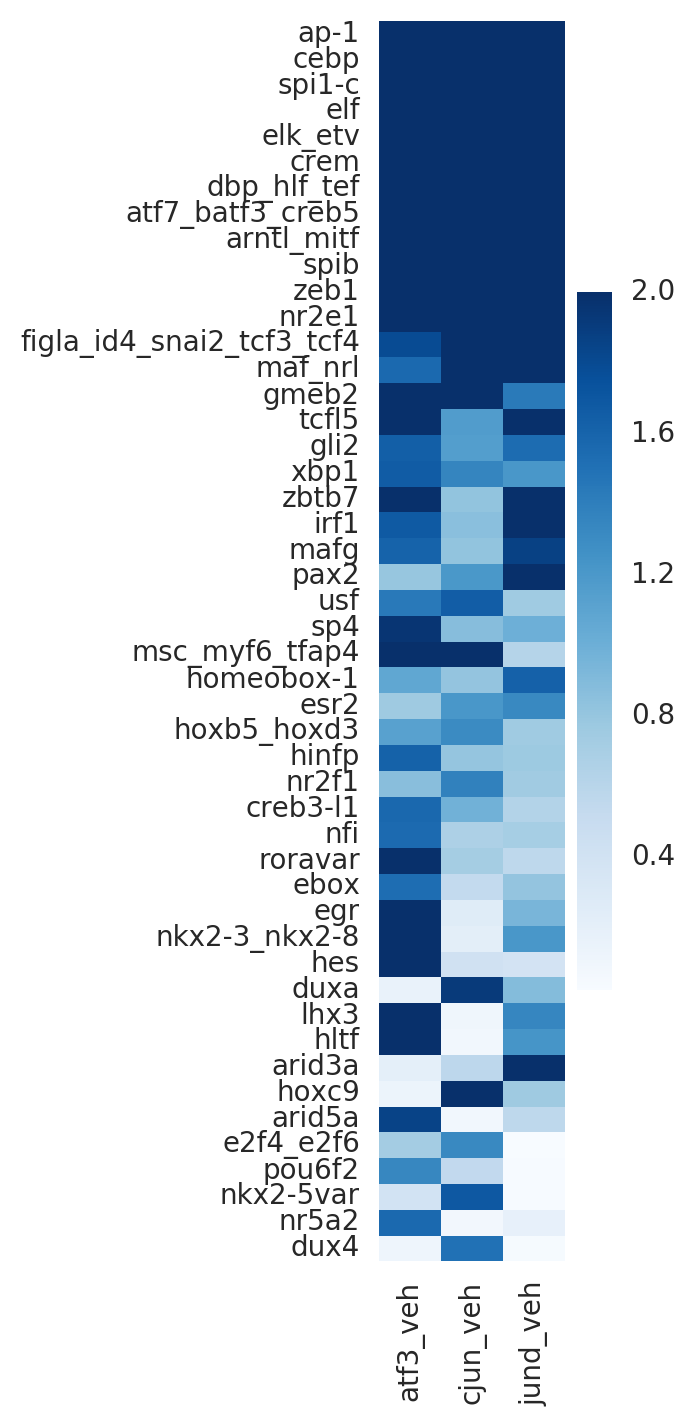

In [1340]:
data = factor_pvals_frame[[x for x in factor_pvals_frame.columns.values if 'veh' in x]]
data = data[data.min(axis=1) < 0.05]
data['mean'] = data.mean(axis=1)
data.sort('mean', inplace=True)
del data['mean']
log_data = -1 * np.log10(data)
plt.figure(figsize=(1.5,8))
cg = sns.heatmap(log_data, cmap = 'Blues',
                 vmax=2)
plt.setp(cg.yaxis.get_majorticklabels(), fontsize=10, rotation=0);
plt.savefig('./figures/figure_06_pval_frame_veh.svg', bbox_inches='tight')




/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


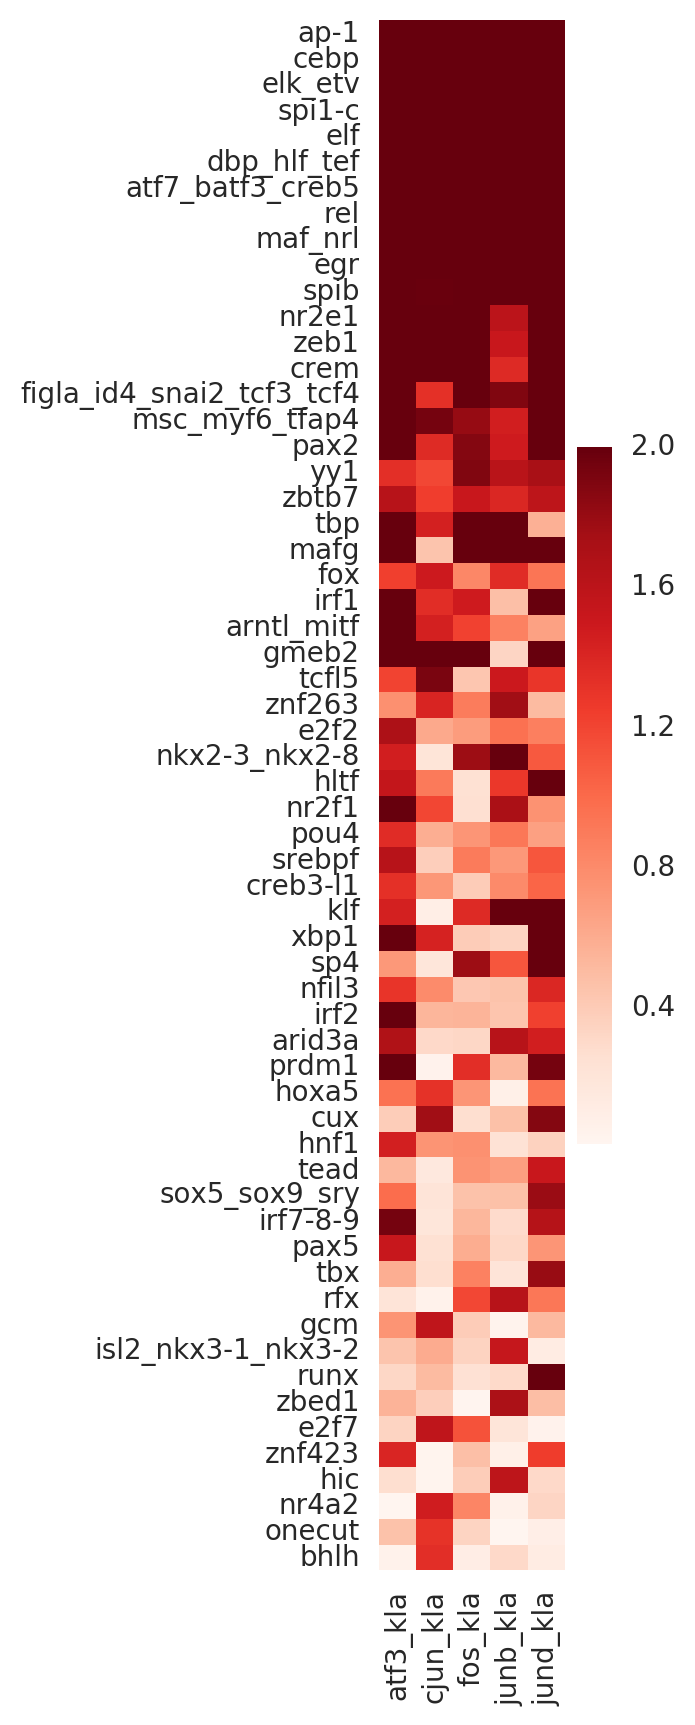

In [1341]:
data = factor_pvals_frame[[x for x in factor_pvals_frame.columns.values if 'kla' in x]]
data = data[data.min(axis=1) < 0.05]
data['mean'] = data.mean(axis=1)
data.sort('mean', inplace=True)
del data['mean']
log_data = -1 * np.log10(data)
plt.figure(figsize=(1.5,10))
cg = sns.heatmap(log_data, cmap = 'Reds',
                 vmax=2)
plt.setp(cg.yaxis.get_majorticklabels(), fontsize=10, rotation=0);
plt.savefig('./figures/figure_06_pval_frame_kla.svg', bbox_inches='tight')



#### Callout boxplot

In [1346]:
threshold = 0.5
treatment = 'veh'
monomer = 'cjun'
motif = 'ap-1'
# find where monomer binds
monomer_indices= summary_frame[(summary_frame['c57bl6_' + monomer + '_'+ treatment] > 0) |
                               summary_frame['balbc_' + monomer + '_'+ treatment] > 0].index.values 
mutated_indices = []
for ind in monomer_indices:
    c57bl6_seq = c57bl6_seq_arrays[ind]
    balbc_seq = balbc_seq_arrays[ind]
    # if sequence lengths are the same
    if c57bl6_seq.shape[0] == balbc_seq.shape[0]:
        has_snp = ((c57bl6_seq + balbc_seq).max(axis=1) == 1)
        if np.sum(has_snp) > 0:
            mutated_indices.append(ind)


balbc_tags = ap1_meanTag_frame.ix[mutated_indices,'balbc_' + monomer + '_' + treatment] 
c57bl6_tags = ap1_meanTag_frame.ix[mutated_indices,'c57bl6_' + monomer + '_' + treatment]

normed_balbc_tags, normed_c57bl6_tags = quantile_normalize(balbc_tags, c57bl6_tags)  

fold_changes = (normed_c57bl6_tags + pseudocount) / (normed_balbc_tags + pseudocount)
fold_changes = pd.Series(fold_changes, index = mutated_indices)
log_fold_changes = np.log2(fold_changes)

current_score_differences = motif_score_differences_frame.ix[mutated_indices,motif]

predicted_increase_indices = current_score_differences[current_score_differences>=threshold].index.values
predicted_decrease_indices = current_score_differences[current_score_differences<=-1*threshold].index.values

grouped_fold_changes = [fold_changes[predicted_increase_indices],
                        fold_changes[predicted_decrease_indices]
                       ]
grouped_log_fold_changes = [log_fold_changes[predicted_increase_indices],
                            log_fold_changes[predicted_decrease_indices]
                           ]

if len(predicted_increase_indices) > 1 and len(predicted_decrease_indices) > 1:
    stat, increase_vs_decrease = scipy.stats.ttest_ind(grouped_log_fold_changes[0], 
                                                       grouped_log_fold_changes[1])


NameError: name 'groupd_log_fold_changes' is not defined

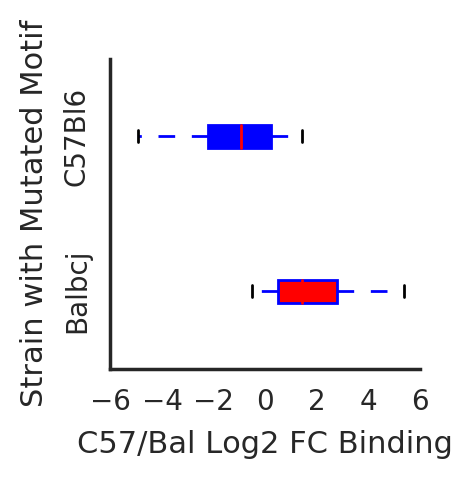

In [1370]:
plt.figure(figsize=(2,2))
box = plt.boxplot(grouped_log_fold_changes, vert=0, patch_artist=True, );
colors = ['red', 'blue']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.yticks(range(1,3),['Balbcj', 'C57Bl6'], rotation =90)
plt.ylabel('Strain with Mutated Motif')
plt.xlabel('C57/Bal Log2 FC Binding')
sns.despine()
plt.savefig('./figures/figure_06_boxplot_example.pdf', bbox_inches='tight')

In [1345]:
increase_vs_decrease

1.2947283907538948e-12

#### Heatmap of significance changes

In [ ]:
veh_bool =  (factor_pvals_frame[['atf3_veh', 'cjun_veh', 'jund_veh']] < 0.05) + 0
kla_bool =  (factor_pvals_frame[['atf3_kla', 'cjun_kla', 'jund_kla']] < 0.05) + 0
kla_bool[kla_bool==1]=2
change_bool = veh_bool.values + kla_bool.values
change_frame = pd.DataFrame(change_bool, columns =['atf3', 'cjun', 'kla'], index = veh_bool.index.values)
data = change_frame[change_frame.max(axis=1)>0]
data['sum'] = data.sum(axis=1)
data = data.sort('sum', ascending=False)
del data['sum']
plt.figure(figsize=(2,12))
cg = sns.heatmap(data,cmap='Set3',annot=True, annot_kws={'size':6})
plt.savefig('./figures/figure_06_significance_change_matrix.svg',bbox_inches='tight')

### show that models trained on one strain works for the other strain

In [ ]:
numIterations = 1
test_size = 0.2
background_ratio = 1.0
ap1_members = ['atf3','cjun', 'fos', 'fra2', 'junb','jund']    
factors = ['atf3','cjun', 'fos', 'junb','jund', 'cebpa', 'pu1', 'p65']

In [ ]:
# for monomers using motif counts and best motif score 
strain = 'c57bl6'
roc_list = []
precision_list = []
factor_list = []
treatment_list = []
training_strain_list = []
testing_strain_list = []
test_train_list = []
for training_strain in ['balbc', 'c57bl6']:
    for testing_strain in ['balbc', 'c57bl6']:
        for treatment in ['veh', 'kla']:
            if treatment == 'veh':
                monomers = monomers = ['atf3', 'cjun', 'jund']
            else:
                monomers = monomers = ['atf3', 'cjun', 'fos', 'junb', 'jund']    
            for monomer in ['atf3','cjun', 'fos', 'junb','jund']:
                target_indices = summary_frame[
                    summary_frame[training_strain + '_' + monomer + '_' + treatment] > 0.0
                    ].index.values
                background_indices = motif_score_background_frame[
                    motif_score_background_frame['Factors'] == 'c57bl6' + '_' + monomer + '_' + treatment + '-background'
                    ].index.values

                # select subset of background indices to use
                shuffle(background_indices)
                background_indices = background_indices[:np.ceil(background_ratio*len(target_indices))]
                
                if training_strain == 'c57bl6':
                    target_features = all_standardized_score_frame[
                        all_standardized_score_frame.index.isin(target_indices)]
                elif training_strain == 'balbc':
                    target_features = all_standardized_score_balbc_frame[
                        all_standardized_score_balbc_frame.index.isin(target_indices)]

                background_features = all_standardized_score_frame[
                    all_standardized_score_frame.index.isin(background_indices)]

                # merge target and background features together 
                features = pd.concat([target_features, background_features])

                labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                                   index = features.index.values)

                results = train_classifier(features, 
                                            labels,
                                            numIterations = 5,
                                            test_size = test_size,
                                            )
                # unpack result tuples
                all_coefficients = results[2]
                mean_coefficients = np.mean(all_coefficients, axis=0)
                
                # test on testing strain
                target_testing_indices = summary_frame[
                    summary_frame[testing_strain + '_' + monomer + '_' + treatment] > 0.0
                    ].index.values
                if testing_strain == 'c57bl6':
                    target_testing_features = all_standardized_score_frame[
                        all_standardized_score_frame.index.isin(target_testing_indices)]
                elif testing_strain == 'balbc':
                    target_testing_features = all_standardized_score_balbc_frame[
                        all_standardized_score_balbc_frame.index.isin(target_testing_indices)]
                    
                testing_features = pd.concat([target_testing_features, background_features])
                testing_labels = pd.Series(
                    data = [True] * len(target_testing_features) + [False] * len(background_indices),
                    index = testing_features.index.values)
                testing_scores = (testing_features* mean_coefficients).sum(axis=1)
                normed_scores = (testing_scores + abs(np.min(testing_scores)))/np.max(testing_scores)
                roc = sklearn.metrics.roc_auc_score(testing_labels, normed_scores)
                precision = sklearn.metrics.average_precision_score(testing_labels, normed_scores)

                roc_list.append(roc)
                precision_list.append(precision)
                
                factor_list.append(monomer)
                treatment_list.append(treatment)
                training_strain_list.append(training_strain)
                testing_strain_list.append(testing_strain)
                test_train_list.append(testing_strain + ' '+ training_strain)
                
                print(training_strain, testing_strain, monomer, treatment, roc, precision)

In [ ]:
strain_performance_frame = pd.DataFrame({'Training Strain':training_strain_list,
                            'Testing Strain':testing_strain_list,
                            'Train Test Strain':test_train_list,
                            'ROC':roc_list,
                            'Precision':precision_list,
                            'Monomer':factor_list,
                            'Treatment':treatment_list})

In [ ]:
strain_color_dict = dict(zip(['balbc', 'c57bl6'], sns.color_palette('coolwarm',2)))
treatment_color_dict = dict(zip(['veh','kla'], sns.color_palette('deep',2)))
monomer_color_dict = dict(zip(['atf3','cjun','fos','fra2','junb','jund'], sns.color_palette('husl',6)))

In [ ]:
training_colors = []
testing_colors = []
treatment_colors = []
monomer_colors = []
matrix_dict = {}


for training_strain in ['balbc', 'c57bl6']:
    for testing_strain in ['balbc', 'c57bl6']:
        matrix_dict[training_strain+ '_'+testing_strain] = []
        training_colors.append(strain_color_dict[training_strain])
        testing_colors.append(strain_color_dict[testing_strain])
        
        treatment_index_list = []
        monomer_index_list = []
        for treatment in ['veh', 'kla']:
            if treatment == 'veh':
                monomers = monomers = ['atf3', 'cjun', 'jund']
            else:
                monomers = monomers = ['atf3', 'cjun', 'fos', 'junb', 'jund']    
            for monomer in monomers:
                treatment_colors.append(treatment_color_dict[treatment])
                monomer_colors.append(monomer_color_dict[monomer])
                roc = strain_performance_frame[(strain_performance_frame['Training Strain'] == training_strain) &
                                         (strain_performance_frame['Testing Strain'] == testing_strain) &
                                         (strain_performance_frame['Monomer'] == monomer) &
                                         (strain_performance_frame['Treatment'] == treatment)]['ROC'].values[0]

                matrix_dict[training_strain+ '_'+testing_strain].append(roc)
                treatment_index_list.append(treatment)
                monomer_index_list.append(monomer)

In [ ]:
frame = pd.DataFrame(matrix_dict, index = pd.MultiIndex.from_arrays([treatment_index_list, monomer_index_list]))
sns.clustermap(data = frame, 
               row_colors =[treatment_colors, monomer_colors],
               col_colors = [training_colors, testing_colors],
               row_cluster = False,
               col_cluster = False,
               annot = True,
               cmap = 'Reds',
               vmin = 0.5,
               vmax = 1.0,
              )
plt.savefig('./figures/figure_06_cross_strain_performance.svg',bbox_inches='tight')

# Figure 7 

In [ ]:
zscore_threshold = 0.5
# indices = zscore_coeff_affinity_veh_frame[
#     (zscore_coeff_affinity_veh_frame.max(axis=1) > 1* zscore_threshold) |
#     (zscore_coeff_affinity_veh_frame.min(axis=1) < -1* zscore_threshold)
#     ].index.values
indices = zscore_coeff_affinity_veh_frame[
    (zscore_coeff_affinity_veh_frame.max(axis=1) > 1* zscore_threshold)
    ].index.values
data = mean_coeff_affinity_veh_frame.ix[indices,:]
mins = data.min(axis=1)
maxes = data.mean(axis=1)
differences = data[[]]
for col in data.columns:
    differences[col] = data[col].values - mins.values
mins.sort()
sorted_maxes = maxes[mins.index.values]
sorted_differences = differences.ix[mins.index.values,:]
sorted_fractional_differences = (sorted_differences.T/sorted_maxes).T
cm = sns.clustermap(sorted_fractional_differences,
                    col_cluster=False,
                    row_cluster=False,
                    cmap='Blues',
                   )
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), 
         fontsize=10, 
         rotation=0);
plt.setp(cm.ax_heatmap.xaxis.get_majorticklabels(), 
         fontsize=10, 
         rotation=90);

cm.ax_row_dendrogram.clear()
cm.ax_row_dendrogram.plot(sorted(mins, reverse=True), range(len(mins)))
cm.ax_row_dendrogram.set_yticks([])
cm.ax_row_dendrogram.set_xlim(0,1)
cm.ax_row_dendrogram.set_ylim(0,len(mins)-1)

hm = cm.ax_heatmap.get_position()
cm.ax_heatmap.set_position([hm.x0, hm.y0, hm.width*0.25, hm.height])
col = cm.ax_col_dendrogram.get_position()
cm.ax_col_dendrogram.set_position([col.x0, col.y0, col.width*0.25, col.height*0.5])
plt.savefig('./figures/figure_06_weight_heatmap.svg', bbox_inches='tight')



### Motif Distance Plots

In [ ]:
def plot_motif_positions_unique(target, target_length, 
                                intersecting_indices = None, 
                                thresholds = [5,6,7,8,9,10], 
                                motif = 'ap-1',
                                max_dist=50,
                                max_height = 0.035):
    with sns.axes_style('ticks'):
        treatment = 'veh'
        monomer_frequencies_dict = {} # {motif:frequency_array}
        positions = range(max_dist)
        strain = 'c57bl6'
        factors = ['atf3', 'cjun', 'jund']

        factor_numPeaks_dict = {}
        f, axarr = plt.subplots(2,1, sharex=True, figsize=(5,5))
        top_ax  = axarr[0]
        bottom_ax = axarr[1]
        palette = sns.color_palette("Set1")
        factor_color_dict = dict(zip(factors, palette))
        for factor in factors:
            factor_indices = set(summary_frame[summary_frame['_'.join([strain, factor, treatment])] > 0].index.values)

            other_factor_indices = set()
            for of in factors:
                if not of == factor:
                    of_indices = set(summary_frame[summary_frame['_'.join([strain, of, treatment])] > 0].index.values)
                    other_factor_indices = other_factor_indices.union(of_indices)

            factor_unique_indices = factor_indices - other_factor_indices
            if not intersecting_indices == None:
                indices = set(intersecting_indices).intersection(factor_unique_indices)
            else:
                indices = factor_unique_indices
            factor_numPeaks_dict[factor] = len(indices)

            all_frequencies = []
            for motif_threshold in thresholds:
                for target_threshold in thresholds:
                    distances = []
                    num_peaks=0
                    for ind in indices:
                        motif_score = motif_score_frame.ix[ind, motif]
                        motif_pos = motif_start_frame.ix[ind, motif]

                        if motif_score >= motif_threshold:
                            target_score = motif_score_frame.ix[ind, target]
                            target_pos = motif_start_frame.ix[ind, target]
                            target_orientation = motif_strand_frame.ix[ind, target]
                            if target_score >= target_threshold:
                                if target_orientation == '+':
                                    dist = motif_pos - target_pos
                                else:
                                    dist = motif_pos - (target_pos + target_length)
                                abs_dist = abs(dist)

                                if abs_dist <= max_dist:
                                    num_peaks += 1
                                    distances.append(abs_dist)
                    distances_counter = Counter(distances)
                    num_matches = len(distances)

                    frequencies = [distances_counter[x]/num_peaks if x in distances_counter else 0 for x in positions]
#                     frequencies = [distances_counter[x] if x in distances_counter else 0 for x in positions]
                    print(np.sum(frequencies))
                    all_frequencies.append(frequencies)

                monomer_frequencies_dict[factor] = np.array(all_frequencies)
            sns.tsplot(monomer_frequencies_dict[factor], 
                       c=factor_color_dict[factor], 
                       condition=factor+' (' + str(factor_numPeaks_dict[factor]) + ')', 
                       ax = top_ax)
            top_ax.set_ylabel('Normalized Frequency')
            top_ax.legend()
            top_ax.set_ylim(0,max_height)
            sns.despine()
        sns.tsplot(monomer_frequencies_dict['cjun'] - monomer_frequencies_dict['atf3'], 
                  c=factor_color_dict['atf3'],  condition = 'atf3', ax=bottom_ax)
        sns.tsplot(monomer_frequencies_dict['cjun'] - monomer_frequencies_dict['jund'], 
                   c=factor_color_dict['jund'], condition = 'jund', ax=bottom_ax)
        bottom_ax.set_xlabel('Distance from AP-1 Motif')
        bottom_ax.set_ylabel('Difference')
        bottom_ax.set_ylim(-1*max_height,max_height)
        bottom_ax.set_xlim(0,max_dist)
        sns.despine()
        return distances_counter

In [ ]:
def plot_motif_positions(target, 
                         target_length, 
                         thresholds = [5,6,7,8,9,10], 
                         motif='ap-1'):
    
    monomers = ['atf3', 'cjun', 'jund']
    ppar_indices = summary_frame[summary_frame['c57bl6_pparg_veh'] > 0].index.values
    palette = sns.color_palette("Set1")
    treatment = 'veh'
    monomer_frequencies_dict = {} # {motif:frequency_array}
    positions = range(200)
    for i in range(len(monomers)):
        monomer = monomers[i]
        print(monomer, treatment)
        # find where monomer binds
        monomer_indices= summary_frame[summary_frame['c57bl6_' + monomer + '_'+ treatment] > 0].index.values 
        # find where pparg intersects with monomer
        indices = set(ppar_indices).intersection(set(monomer_indices))
        all_frequencies = []
        for motif_threshold in thresholds:
            for target_threshold in thresholds:
                distances = []
                num_peaks = 0
                for ind in indices:
                    motif_score = motif_score_frame.ix[ind, motif]
                    motif_pos = motif_start_frame.ix[ind, motif]

                    if motif_score > motif_threshold:
                        target_score = motif_score_frame.ix[ind, target]
                        target_pos = motif_start_frame.ix[ind, target]
                        target_orientation = motif_strand_frame.ix[ind, target]
                        if target_score > target_threshold:
                            num_peaks +=1
                            if target_orientation == '+':
                                dist = motif_pos - target_pos
                            else:
                                dist = motif_pos - (target_pos + target_length)
                            distances.append(abs(dist))
                distances_counter = Counter(distances)
                numMatches = len(distances)
                
#                 frequencies = [distances_counter[x]/num_peaks if x in distances_counter else 0 for x in positions]
                frequencies = [distances_counter[x] if x in distances_counter else 0 for x in positions]
                all_frequencies.append(frequencies)
                print(monomer, num_peaks, np.sum(frequencies))
            monomer_frequencies_dict[monomer] = np.array(all_frequencies)
    with sns.axes_style('ticks'):      
        sns.tsplot(monomer_frequencies_dict['atf3'], c='blue', condition='atf3')
        sns.tsplot(monomer_frequencies_dict['jund'], c='red', condition='jund')
        sns.tsplot(monomer_frequencies_dict['cjun'], c='black', condition='cjun')
        plt.xlabel('Distance from AP-1 Motif')
        plt.ylabel('Normalized Frequency')
        plt.legend()
#         plt.ylim(0,0.15)
        plt.xlim(0,50)
        sns.despine()
        plt.show()
    
        sns.tsplot(monomer_frequencies_dict['cjun'] - monomer_frequencies_dict['jund'], c='blue', condition = 'jund')
        sns.tsplot(monomer_frequencies_dict['cjun'] - monomer_frequencies_dict['atf3'], c='red',  condition = 'atf3')
        plt.xlabel('Distance from AP-1 Motif')
        plt.ylabel('Difference in Normalized Frequency')
#         plt.ylim(-0.1,0.1)
        plt.xlim(0,50)
        plt.legend()
        sns.despine()

In [ ]:
target = 'nr2f1'
target_length = 12
intersecting_indices = summary_frame[summary_frame['c57bl6_pparg_veh'] > 0].index.values
thresholds = [3]

vals = plot_motif_positions(target, 
                            target_length, 
                            thresholds = thresholds,
                                    )
# plt.savefig('./figures/figure_04_motif_distance_nr2f1.svg', bbox_inches='tight')




In [ ]:
target = 'nr2f1'
target_length = 12
intersecting_indices = summary_frame[summary_frame['c57bl6_pparg_veh'] > 0].index.values
thresholds = [3]

vals = plot_motif_positions_unique(target, 
                                    target_length, 
                                    thresholds = thresholds,
                                    intersecting_indices=None,
                                    max_dist=50,
                                    max_height=0.1)
plt.savefig('./figures/figure_04_motif_distance_nr2f1.svg', bbox_inches='tight')



In [ ]:
target = 'cebp'
target_length = 10
intersecting_indices = summary_frame[summary_frame['c57bl6_cebpa_veh'] > 0].index.values

thresholds = [1,2,3,4,5,6,7,8,9,10]

vals = plot_motif_positions_unique(target, 
                                    target_length, 
                                    thresholds = thresholds,
                                    intersecting_indices=intersecting_indices,
                                    max_dist=25,
                                    max_height=0.4)
plt.savefig('./figures/figure_04_motif_distance_cebpa.svg', bbox_inches='tight')

 

In [ ]:
target = 'spi1-c'
target_length = 14
intersecting_indices = summary_frame[summary_frame['c57bl6_pu1_veh'] > 0].index.values

thresholds = [1,2,3,4,5,6,7,8,9,10]

vals = plot_motif_positions_unique(target, 
                                    target_length, 
                                    thresholds = thresholds,
                                    intersecting_indices=intersecting_indices,
                                    max_dist=25,
                                    max_height=0.4)    
plt.savefig('./figures/figure_04_motif_distance_pu1.svg', bbox_inches='tight')



In [ ]:
summary_new_frame = pd.read_pickle('/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis_features/summary_frame.pickle')

In [ ]:
motif_start_new_frame = pd.read_pickle('/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis_features/motif_start_frame_C57BL6J.pickle')

In [ ]:
motif_score_new_frame = pd.read_pickle('/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis_features/motif_score_frame_C57BL6J.pickle')

In [ ]:
motif_strand_new_frame = pd.read_pickle('/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis_features/motif_strand_frame_C57BL6J.pickle')

In [ ]:
import re

In [ ]:
ap1_pattern = re.compile('TGA[ACGT]{1,2}TCA')

In [ ]:
ap1_pattern = re.compile('TGA')

In [ ]:
pparg_pattern = re.compile('AGGTCA')

In [ ]:
pparg_pattern = re.compile('GTCA')


In [ ]:
positions = range(100)
for treatment in ['veh']:
    if treatment == 'veh':
        monomers = ['atf3', 'cjun', 'jund']
    else:
        monomers = ['atf3', 'cjun', 'fos', 'junb', 'jund']
    for i in range(len(monomers)):
        monomer = monomers[i]
        # find where monomer binds
        monomer_indices= summary_frame[summary_frame['c57bl6_' + monomer + '_'+ treatment] > 0].index.values 
        
        other_monomer_indices = set()
        for om in monomers:
            if not om == monomer:
                om_indices = set(summary_frame[summary_frame['_'.join(['c57bl6', om, treatment])] > 0].index.values)
                other_monomer_indices = other_factor_indices.union(om_indices)

        monomer_unique_indices = set(monomer_indices) - other_monomer_indices


            
        ap1_count = 0
        pparg_count = 0
        distances = []
        for ind in monomer_unique_indices:
            seq=_id_sequence_dict[ind]
            ap1_match = ap1_pattern.finditer(seq)
            pparg_match = pparg_pattern.finditer(seq)
            ap1_positions = []
            for m in ap1_match:
                pos = m.span()
                center = pos[1]-pos[0]/2
                ap1_positions.append(center)
            num_pparg = 0
            if len(ap1_positions) > 0:
#             if True:
                ap1_count+=1
                pparg_positions = []
                pparg_match = pparg_pattern.finditer(seq)
                for m in pparg_match:
                    pos = m.span()
                    center = pos[1]-pos[0]/2
                    pparg_positions.append(center)
                if len(pparg_positions) >0:
                    pparg_count+=1
        
                for x in ap1_positions:
                    for y in pparg_positions:
                        dist = abs(x - y)
                        if dist > 3:
                            distances.append(dist)
        distances_counter = Counter(distances)
        frequencies = [distances_counter[x]/ap1_count if x in distances_counter else 0 for x in positions]


        print(monomer, treatment, ap1_count, pparg_count, len(monomer_unique_indices))
#         sns.distplot(np.array(distances), label = monomer, bins=100)
        plt.plot(frequencies, label =monomer)
    plt.legend()
#     plt.xlim(0,50)
#         plt.show()
    

### PPARg Venn Diagrams

In [ ]:
%%capture
! mergePeaks -d 100 -venn validation_venn.txt ./peak_files/c57bl6_atf3_veh_peaks.tsv ./peak_files/c57bl6_cjun_veh_peaks.tsv ./peak_files/c57bl6_jund_veh_peaks.tsv ./peak_files_validation/* > merged_validation_peaks.tsv



In [ ]:
! makeSummaryFile.py ./merged_validation_peaks.tsv ./group_validation_summary.tsv ./peak_files/c57bl6_atf3_veh_peaks.tsv ./peak_files/c57bl6_cjun_veh_peaks.tsv ./peak_files/c57bl6_jund_veh_peaks.tsv ./peak_files_validation/* 

In [ ]:
# read in peak data data
summary_validation_frame = pd.read_csv('./group_validation_summary.tsv' , sep='\t')
summary_validation_frame = summary_validation_frame.fillna('0')
for col in summary_validation_frame.columns[5:]:
    floatValues = []
    for val in summary_validation_frame[col].values.astype(str):
        if ',' in val:
            maxVal = np.mean([float(x) for x in val.split(',')])
            floatValues.append(maxVal)
        else:
            floatValues.append(float(val))
    summary_validation_frame[col] = floatValues
summary_validation_frame.index = summary_validation_frame['ID'].values

# remove peaks in unknown/random chromosomes
summary_validation_frame = summary_validation_frame[~summary_validation_frame['chr'].str.contains('random')]
summary_validation_frame = summary_validation_frame[~summary_validation_frame['chr'].str.contains('Un')]

### Search for browser shots

In [ ]:
summary_validation_frame[(summary_validation_frame['c57bl6_pparg_veh'] == 0) &
#                          (summary_validation_frame['c57bl6-ppargko_atf3_veh'] > 0) &
                         (summary_validation_frame['c57bl6-ppargko_cjun_veh'] > 0) &
                         (summary_validation_frame['c57bl6-ppargko_jund_veh'] > 0)].sort('c57bl6-ppargko_cjun_veh', ascending=False)

### Venn Diagrams

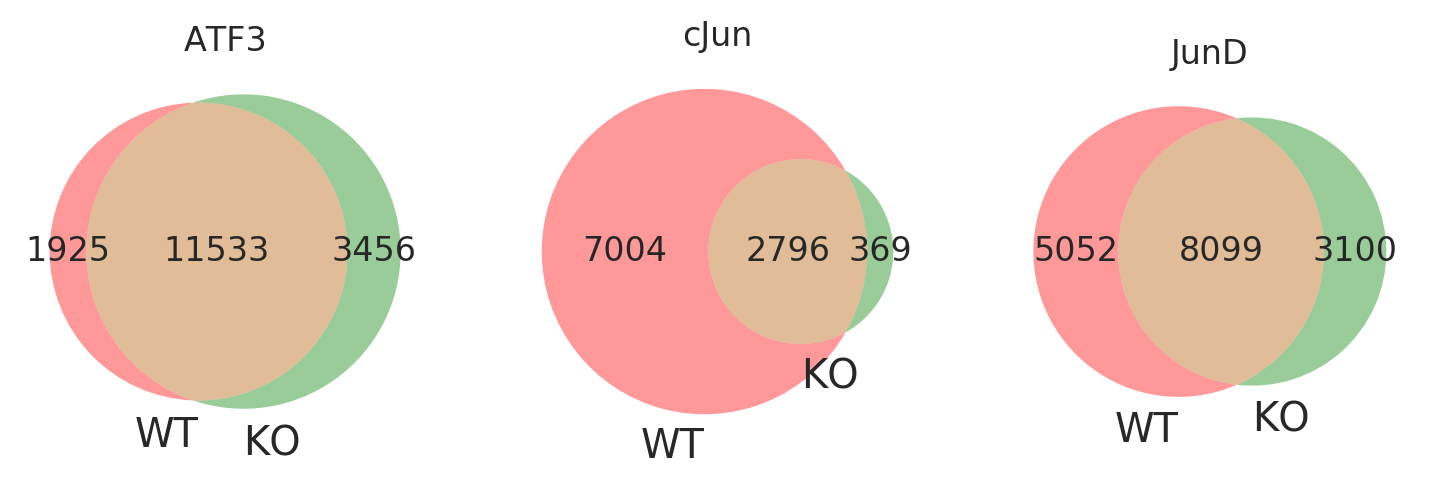

In [1381]:
ppar_indices = set(summary_validation_frame[summary_validation_frame['c57bl6_pparg_veh'] > 0].index.values)

atf3_wt_indices = set(summary_validation_frame[summary_validation_frame['c57bl6_atf3_veh'] > 0].index.values)
atf3_ko_indices = set(summary_validation_frame[summary_validation_frame['c57bl6-ppargko_atf3_veh'] > 0].index.values)

cjun_wt_indices = set(summary_validation_frame[summary_validation_frame['c57bl6_cjun_veh'] > 0].index.values)
cjun_ko_indices = set(summary_validation_frame[summary_validation_frame['c57bl6-ppargko_cjun_veh'] > 0].index.values)

jund_wt_indices = set(summary_validation_frame[summary_validation_frame['c57bl6_jund_veh'] > 0].index.values)
jund_ko_indices = set(summary_validation_frame[summary_validation_frame['c57bl6-ppargko_jund_veh'] > 0].index.values)

fig, ax = plt.subplots(1,3, figsize=(9,3))
plt.subplot(1,3,1)
matplotlib_venn.venn2([ppar_indices.intersection(atf3_wt_indices),
                       ppar_indices.intersection(atf3_ko_indices)],
                      set_labels = ['WT', 'KO'])
plt.title('ATF3')

plt.subplot(1,3,2)
matplotlib_venn.venn2([ppar_indices.intersection(cjun_wt_indices),
                       ppar_indices.intersection(cjun_ko_indices)],
                     set_labels = ['WT', 'KO'])
plt.title('cJun')
plt.subplot(1,3,3)
matplotlib_venn.venn2([ppar_indices.intersection(jund_wt_indices),
                       ppar_indices.intersection(jund_ko_indices)],
                     set_labels = ['WT', 'KO'])
plt.title('JunD')
plt.savefig('./figures/figure_07_pparko_venn.svg', bbox_inches='tight')



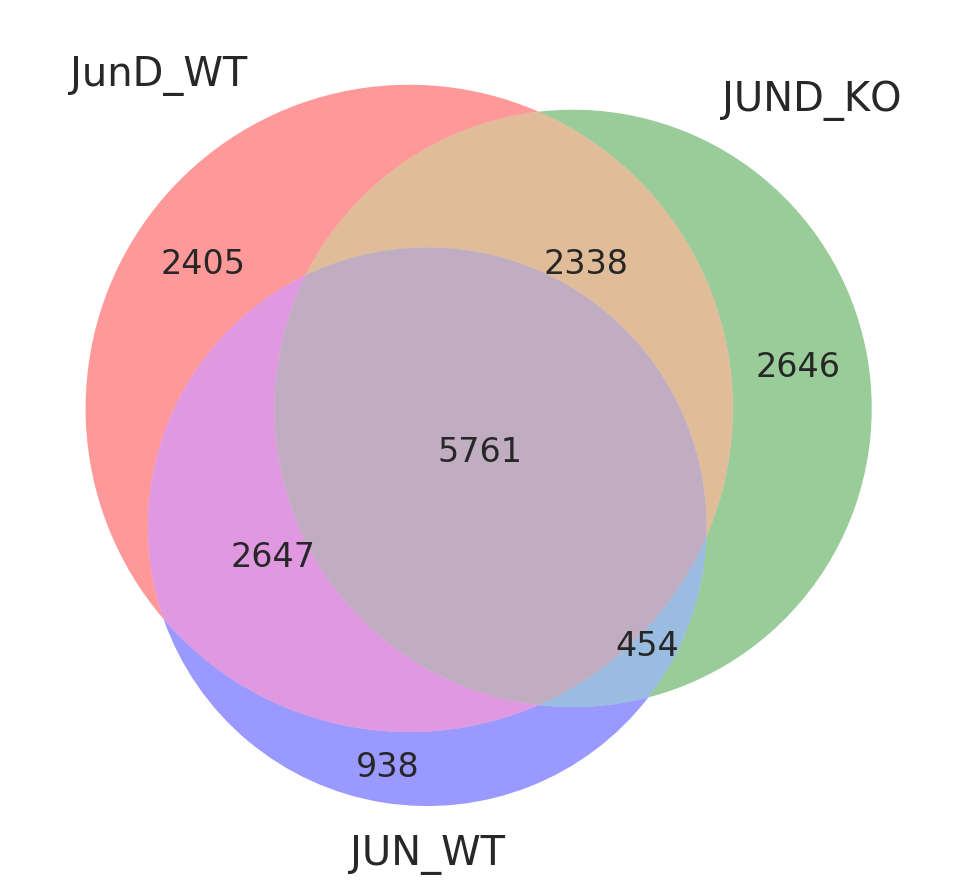

In [1382]:
ppar_indices = set(summary_validation_frame[summary_validation_frame['c57bl6_pparg_veh'] > 0].index.values)

atf3_wt_indices = set(summary_validation_frame[summary_validation_frame['c57bl6_atf3_veh'] > 0].index.values)
atf3_ko_indices = set(summary_validation_frame[summary_validation_frame['c57bl6-ppargko_atf3_veh'] > 0].index.values)

cjun_wt_indices = set(summary_validation_frame[summary_validation_frame['c57bl6_cjun_veh'] > 0].index.values)
cjun_ko_indices = set(summary_validation_frame[summary_validation_frame['c57bl6-ppargko_cjun_veh'] > 0].index.values)

jund_wt_indices = set(summary_validation_frame[summary_validation_frame['c57bl6_jund_veh'] > 0].index.values)
jund_ko_indices = set(summary_validation_frame[summary_validation_frame['c57bl6-ppargko_jund_veh'] > 0].index.values)





matplotlib_venn.venn3([ppar_indices.intersection(jund_wt_indices),
                       ppar_indices.intersection(jund_ko_indices),
                       ppar_indices.intersection(cjun_wt_indices)],
                      set_labels = ['JunD_WT', 'JUND_KO', 'JUN_WT'])

plt.savefig('./figures/figure_07_pparko_jund_jun_venn.svg', bbox_inches='tight')



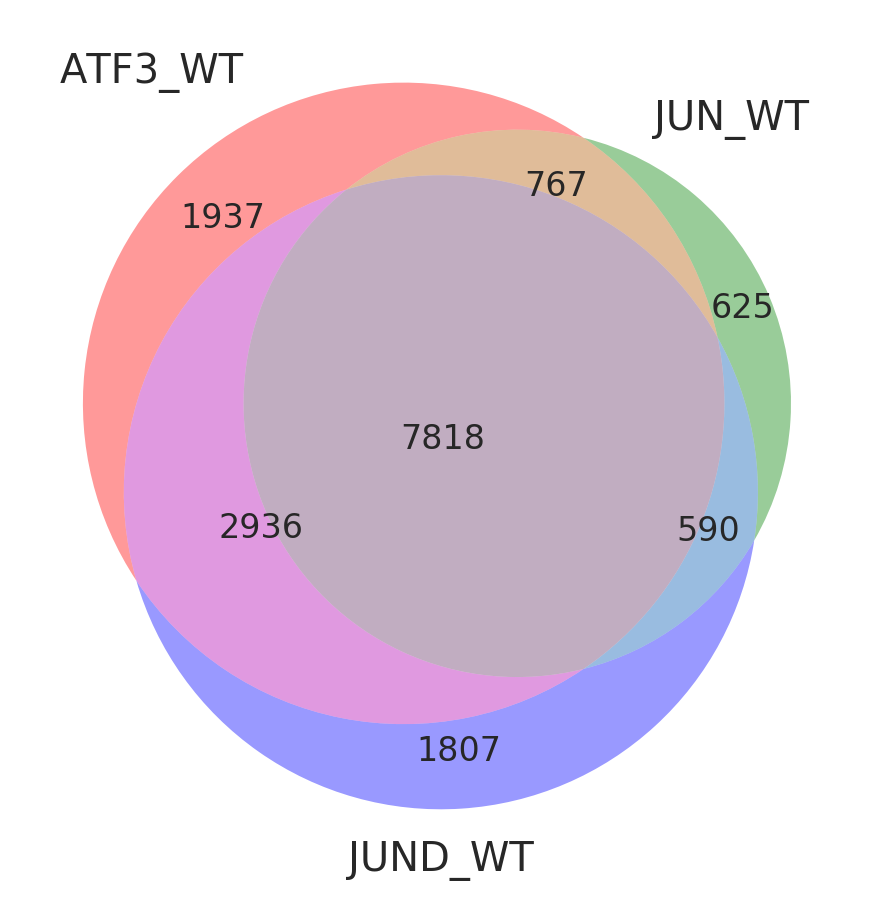

In [1383]:
ppar_indices = set(summary_validation_frame[summary_validation_frame['c57bl6_pparg_veh'] > 0].index.values)

atf3_wt_indices = set(summary_validation_frame[summary_validation_frame['c57bl6_atf3_veh'] > 0].index.values)
atf3_ko_indices = set(summary_validation_frame[summary_validation_frame['c57bl6-ppargko_atf3_veh'] > 0].index.values)

cjun_wt_indices = set(summary_validation_frame[summary_validation_frame['c57bl6_cjun_veh'] > 0].index.values)
cjun_ko_indices = set(summary_validation_frame[summary_validation_frame['c57bl6-ppargko_cjun_veh'] > 0].index.values)

jund_wt_indices = set(summary_validation_frame[summary_validation_frame['c57bl6_jund_veh'] > 0].index.values)
jund_ko_indices = set(summary_validation_frame[summary_validation_frame['c57bl6-ppargko_jund_veh'] > 0].index.values)





matplotlib_venn.venn3([ppar_indices.intersection(atf3_wt_indices),
                       ppar_indices.intersection(cjun_wt_indices),
                       ppar_indices.intersection(jund_wt_indices)],
                     set_labels = ['ATF3_WT', 'JUN_WT', 'JUND_WT'])

plt.savefig('./figures/figure_07_wt_venn.svg', bbox_inches='tight')




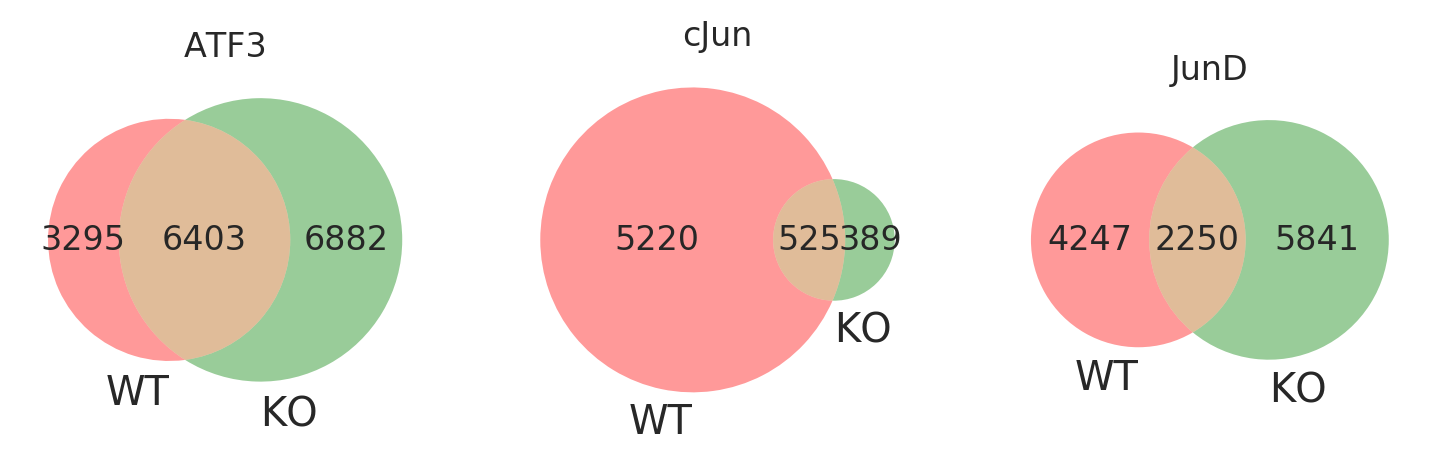

In [1384]:
fig, ax = plt.subplots(1,3, figsize=(9,3))
plt.subplot(1,3,1)
matplotlib_venn.venn2([atf3_wt_indices - ppar_indices,
                       atf3_ko_indices - ppar_indices],
                      set_labels = ['WT', 'KO'])
plt.title('ATF3')

plt.subplot(1,3,2)
matplotlib_venn.venn2([cjun_wt_indices - ppar_indices,
                       cjun_ko_indices - ppar_indices],
                     set_labels = ['WT', 'KO'])
plt.title('cJun')
plt.subplot(1,3,3)
matplotlib_venn.venn2([jund_wt_indices - ppar_indices,
                       jund_ko_indices - ppar_indices],
                     set_labels = ['WT', 'KO'])
plt.title('JunD')

### Expression of AP-1 Monomers in nuclear receptor knockouts

In [ ]:
! analyzeRepeats.pl rna mm10 -count exons -condenseGenes -rpkm -d  ~/analysis/ap1_analysis/tag_directories_rna/*Veh*UT*CR*/ ~/analysis/ap1_analysis/tag_directories_rna/*Veh*UT*VML*/ /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6-PPARgKO_*/ /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6-LXRDKO_Thiomac_RNA_Veh_NJS_15-08-21/> rpkm_ppargko.tsv



In [ ]:
# read in rpkm values
rpkm_pparko_frame = pd.read_csv('./rpkm_ppargko.tsv', sep='\t')

rpkm_pparko_frame.index = [x.split('|')[0].upper() for x in rpkm_pparko_frame['Annotation/Divergence']]
rpkm_pparko_frame = rpkm_pparko_frame.ix[:,8:]
rpkm_pparko_frame.columns = [x.split('/')[-2].split('_')[0] for x in rpkm_pparko_frame.columns.values]

# rotate frame for plotting
rpkm_plotting_frame = pd.DataFrame(rpkm_pparko_frame.stack(), 
                                   columns=['RPKM'])
rpkm_plotting_frame['Gene'] = [x[0] for x in rpkm_plotting_frame.index.values]
rpkm_plotting_frame['Genotype'] = [x[1] for x in rpkm_plotting_frame.index.values]
rpkm_plotting_frame['Log2 RPKM'] = np.log2(rpkm_plotting_frame['RPKM'].values + 1)

In [ ]:
gene_list = ['ATF3', 'JUN' , 'JUND',
#              'PPARG',
#              'NR1H2',
#              'RXRA',
#              'RXRB',
#              'GCGR',
#              'ESR1'
             ]

plottingFrame = rpkm_plotting_frame[rpkm_plotting_frame['Gene'].isin(gene_list)]

with sns.axes_style('ticks'):
    sns.factorplot(data = plottingFrame, x='Gene', y='Log2 RPKM', hue='Genotype', kind='bar', 
                   order = gene_list,
#                    hue_order=['Veh','KLA-1h'], 
                   ci=100,
                  size=3)

plt.xticks(rotation=90)
plt.savefig('./figures/figure_04_ppargko_monomer_expression.svg', bbox_inches='tight')




### Motif Weight Callout

In [ ]:
plt.figure(figsize=(2,2))
with sns.axes_style('ticks'):
    plt.bar(range(3),zscore_coeff_affinity_veh_frame.ix['nr2f1'].values)
    sns.despine()
    plt.xticks(np.arange(0.5,3.5,1), ['atf3_veh', 'cjun_veh', 'jund_veh'], rotation=90)
    plt.ylim(0,1)
    plt.ylabel('Weight')
plt.savefig('./figures/figure_04_nr2f1_callout.svg', bbox_inches='tight')



## GRO-seq Analysis

In [ ]:
%%capture
!annotatePeaks.pl ./merged_peaks_filtered_resized.tsv mm10 -size 1000 -d ./tag_directories_gro/*/ > ./merged_peaks_filtered_resized_gro.tsv

In [ ]:
# average tag counts from both replicates
gro_tag_frame = pd.read_csv('merged_peaks_filtered_resized_gro.tsv', sep='\t')
gro_tag_frame.index = gro_tag_frame.ix[:,0].values
annotations = pd.Series([x.split()[0] for x in gro_tag_frame['Annotation'].values], index = gro_tag_frame.index.values)
gro_tag_frame = gro_tag_frame[[x for x in gro_tag_frame.columns.values if 'Tag Count' in x]]
columns = [x.split(' ')[0].split('/')[2].lower() for x in gro_tag_frame.columns.values]
gro_tag_frame.columns = columns

factor_treatments = sorted(set(['_'.join(x.split('_')[:5]) for x in columns]))

mean_gro_tag_dict = {}
for ft in factor_treatments:
    cleaned_ft = ft.split('_')[3].split('-')[0]
    mean_gro_tag_dict[cleaned_ft] = gro_tag_frame[[x for x in gro_tag_frame.columns if ft in x]].mean(axis=1).values
mean_gro_frame = pd.DataFrame(mean_gro_tag_dict)
mean_gro_frame.index = gro_tag_frame.index.values



In [ ]:
# normalized_gro_frame = mean_gro_frame[[]]
# normed_veh_reads, normed_kla_reads = quantile_normalize(mean_gro_frame['veh'].values,
#                                                         mean_gro_frame['kla'].values)
# normalized_gro_frame['veh'] = normed_veh_reads
# normalized_gro_frame['kla'] = normed_kla_reads

In [ ]:
intergenic_indices = annotations[annotations == 'Intergenic'].index.values
fold_changes = np.log2((mean_gro_frame['kla'] + 0.1)/(mean_gro_frame['veh'] + 0.1))

fold_change_list = []
condition_list = []
monomer_list = []
for monomer in ['atf3','cjun', 'jund']:
    veh_indices = summary_frame[(summary_frame.index.isin(intergenic_indices)) &
                                (summary_frame['c57bl6_' + monomer + '_veh'] > 0)].index.values
    kla_indices = summary_frame[(summary_frame.index.isin(intergenic_indices)) &
                                (summary_frame['c57bl6_' + monomer + '_kla'] > 0)].index.values
    
    veh_indices = set(veh_indices)
    kla_indices = set(kla_indices)
    
    veh_specific_indices = veh_indices - kla_indices
    kla_specific_indices = kla_indices - veh_indices
    shared_indices = veh_indices.intersection(kla_indices)

    fold_change_list = fold_change_list + list(fold_changes[veh_specific_indices])
    fold_change_list = fold_change_list + list(fold_changes[kla_specific_indices])
    fold_change_list = fold_change_list + list(fold_changes[shared_indices])
    
    monomer_list = monomer_list + [monomer] * (len(veh_specific_indices) + len(kla_specific_indices) + len(shared_indices))
    
    condition_list = condition_list + ['Veh Specific'] * len(veh_specific_indices)
    condition_list = condition_list + ['KLA Specific'] * len(kla_specific_indices)
    condition_list = condition_list + ['Shared'] * len(shared_indices)
    
    stat,veh_kla_pval = scipy.stats.ttest_ind(fold_changes[veh_specific_indices],fold_changes[kla_specific_indices])
    stat,veh_shared_pval = scipy.stats.ttest_ind(fold_changes[shared_indices],fold_changes[veh_specific_indices])
    stat,kla_shared_pval = scipy.stats.ttest_ind(fold_changes[shared_indices],fold_changes[kla_specific_indices])
    
    print(monomer, veh_shared_pval, kla_shared_pval, veh_kla_pval)
kla_change_frame = pd.DataFrame({'Condition':condition_list,
                      'GRO-seq Log2 Fold Change':fold_change_list,
                      'Monomer':monomer_list
                     })

sns.factorplot(data = kla_change_frame, 
               x = 'Monomer',
               y = 'GRO-seq Log2 Fold Change',
               hue = 'Condition',
               kind = 'box',
               hue_order = ['Veh Specific', 'Shared', 'KLA Specific'],
               showfliers = False,
               size=3
              )
plt.ylabel('GRO-seq Log2 FC (KLA/Veh)')
plt.savefig('./figures/figure_05_gro_boxplots.svg', bbox_inches='tight')

In [ ]:
intergenic_indices = annotations[annotations == 'Intergenic'].index.values
fold_changes = np.log2((mean_gro_frame['kla'] + 0.1)/(mean_gro_frame['veh'] + 0.1))

fold_change_list = []
condition_list = []
monomer_list = []
for monomer in ['atf3','cjun', 'jund']:
    veh_indices = summary_frame[(summary_frame.index.isin(intergenic_indices)) &
                                (summary_frame['c57bl6_' + monomer + '_veh'] > 0)].index.values
    kla_indices = summary_frame[(summary_frame.index.isin(intergenic_indices)) &
                                (summary_frame['c57bl6_' + monomer + '_kla'] > 0)].index.values
    
    veh_indices = set(veh_indices)
    kla_indices = set(kla_indices)
    
    indices = veh_indices.union(kla_indices)

    current_fold_changes = fold_changes[indices]
    
    current_scores = all_standardized_score_frame.ix[indices,:]
    veh_weights = mean_coeff_affinity_frame[monomer + '_veh']
    kla_weights = mean_coeff_affinity_frame[monomer + '_kla']
    
    veh_products = veh_weights * current_scores
    veh_scores = veh_products.sum(axis=1)
    kla_products = kla_weights * current_scores
    kla_scores = kla_products.sum(axis=1)
    
    differences = kla_scores - veh_scores
    
    high_log_fcs = current_fold_changes[differences[differences > np.percentile(differences,67)].index.values]
    med_log_fcs = current_fold_changes[differences[(differences > np.percentile(differences,33)) &
                                                     (differences < np.percentile(differences,67))].index.values]
    low_log_fcs = current_fold_changes[differences[differences < np.percentile(differences,33)].index.values]
    
    fold_change_list = fold_change_list + list(high_log_fcs)
    fold_change_list = fold_change_list + list(med_log_fcs)
    fold_change_list = fold_change_list + list(low_log_fcs)
    
    condition_list = condition_list + ['Predicted Increase'] * len(high_log_fcs)
    condition_list = condition_list + ['No Change Predicted'] * len(med_log_fcs)
    condition_list = condition_list + ['Predicted Decrease'] * len(low_log_fcs)
    
    monomer_list = monomer_list + [monomer] *len(indices)
    
    stat,high_low_pval = scipy.stats.ttest_ind(high_log_fcs,low_log_fcs)
    stat,med_low_pval = scipy.stats.ttest_ind(med_log_fcs,low_log_fcs)
    stat,med_high_pval = scipy.stats.ttest_ind(med_log_fcs,high_log_fcs)
    print(monomer, treatment, high_low_pval, med_low_pval, med_high_pval)
  

prediction_frame = pd.DataFrame({'Condition':condition_list,
                      'GRO-seq Log2 Fold Change':fold_change_list,
                      'Monomer':monomer_list
                     })

sns.factorplot(data = prediction_frame, 
               x = 'Monomer',
               y = 'GRO-seq Log2 Fold Change',
               hue = 'Condition',
               kind = 'box',
               hue_order = ['Predicted Decrease', 
                            'No Change Predicted',
                            'Predicted Increase'],
               showfliers = False,
               size=3
              )
plt.ylabel('GRO-seq Log2 FC (KLA/Veh)')
plt.savefig('./figures/figure_05_predicted_gro_boxplots.svg', bbox_inches='tight')

In [ ]:
sns.factorplot(data = pd.concat([prediction_frame, kla_change_frame]), 
               x = 'Monomer',
               y = 'GRO-seq Log2 Fold Change',
               hue = 'Condition',
               kind = 'box',
               hue_order = ['Veh Specific', 'Predicted Decrease', 
                            'Shared', 'No Change Predicted',
                            'KLA Specific', 'Predicted Increase'],
               palette='Paired',
               showfliers = False
              )

In [1419]:
summary_frame[summary_frame['Factors'].str.contains('c57bl6_ap-1_veh')].shape

(30303, 40)

In [1418]:
summary_frame[summary_frame['Factors'].str.contains('c57bl6_ap-1_kla')].shape

(43712, 40)

In [1420]:
summary_frame[summary_frame['Factors'].str.contains('c57bl6_ap-1')].shape

(50165, 40)